In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import pandas as pd
import numpy as np
import astropy.units as u
from datetime import date
from random import choices
from math import factorial, erf
from astroquery.simbad import Simbad
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
import h5py
from sklearn.neighbors import KernelDensity
from scipy.integrate import simps
from scipy import stats
# sys.path.append('/Users/lib278/opt/anaconda3/envs/pyKLIP/lib/python3.9/site-packages/')

In [2]:
def make_cmap(colors, position, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    bit_rgb = np.linspace(0,1,256)
    # if position == None:
    #     position = np.linspace(0,1,len(colors))
    # else:
    if len(position) != len(colors):
        sys.exit("position length must be the same as colors")
    elif position[0] != 0 or position[-1] != 1:
        sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap
def choose_cmap(custom_cmap, reverse_cmap=False):

    custom_cmaps = {'my diverging red blue': [(204/255, 230/255, 255/255),
                                              (0/255, 102/255, 204/255),
                                              (51/255, 0/255, 102/255),
                                              (255/255, 0/255, 102/255),
                                              (255/255, 230/255, 243/255)],
                    'my blue yellow red': [(0 / 255, 74 / 255, 171 / 255),
                                        (255 / 255, 209 / 255, 26 / 255),
                                        (178 / 255, 0 / 255, 3 / 255)],
                    'McLaren 2022': [(0/255, 38/255, 77/255),
                                    (211/255, 0/255, 87/255),
                                    (255/255, 153/255, 0/255),
                                    (191/255, 217/255, 217/255)],
                    'vibrant candy': [(0/255, 26/255, 77/255),
                                    (204/255, 0/255, 102/255),
                                    (255/255, 204/255, 0/255),
                                    (153/255, 255/255, 153/255)],
                    'ice queen': [(37/255, 0/255, 51/255),
                                  (0/255, 155/255, 153/255),
                                  (214/255, 255/255, 214/255)],
                    'ice queen2': [(0/255, 0/255, 0/255),
                                   (0/255, 134/255, 179/255),
                                   (255/255, 255/255, 200/255)],
                    'amazon queen': [(0/255, 0/255, 0/255),
                                     (25/255, 103/255, 103/255),
                                     (119/255, 179/255, 105/255),
                                     (255/255, 234/255, 0/255),
                                     (255/255, 255/255, 255/255)],
                    'amazon queen2': [(0/255, 34/255, 51/255),
                                      (25/255, 103/255, 103/255),
                                    #   (119/255, 179/255, 105/255),
                                    #   (63/255, 211/255, 146/255),
                                      (255/255, 234/255, 0/255)],
                    'colorado sunrise': [(0/255, 17/255, 51/255),
                                         (234/255, 74/255, 104/255),
                                         (255/255, 224/255, 102/255)],
                    'muted rbg': [(102/255, 0/255, 51/255),
                                  (0/255, 85/255, 128/255),
                                  (140/255, 153/255, 0/255)],
                    'perceptual rbg': [(102/255, 0/255, 51/255),
                                       (60/255, 40/255, 90/255),
                                       (0/255, 102/255, 153/255),
                                       (134/255, 179/255, 0/255),
                                       (255/255, 200/255, 50/255),
                                       (255/255, 255/255, 160/255)],
                    'mclaren livery': [(0/255, 119/255, 179/255),
                                       (204/255, 0/255, 102/255),
                                    #    (255/255, 128/255, 0/255),
                                       (255/255, 153/255, 0/255),
                                       (207/255, 226/255, 226/255)],
                    'volcanic sunrise': [(0/255, 51/255, 77/255),
                                  (153/255, 0/255, 77/255),
                                  (255/255, 80/255, 80/255),
                                  (255/255, 255/255, 153/255)],
                    'cyber grape': [(51/255, 0/255, 51/255),
                                    (128/255, 0/255, 128/255),
                                    (153/255, 102/255, 255/255),
                                    (204/255, 255/255, 255/255)],
                    'cyber grape2': [(51/255, 0/255, 51/255),
                                     (128/255, 0/255, 128/255),
                                     (255/255, 153/255, 204/255),
                                     (204/255, 255/255, 255/255)],
                    'black limeaid': [(0/255, 0/255, 77/255),
                                      (102/255, 153/255, 153/255),
                                      (204/255, 255/255, 51/255)],
                    }

    chosen_cmap = custom_cmaps[custom_cmap]
    pos_diff = 1./(len(chosen_cmap)-1)
    positions = np.arange(0, 1+pos_diff, pos_diff)
    if reverse_cmap == True:
        chosen_cmap = chosen_cmap[::-1]
    mycolormap = make_cmap(chosen_cmap, position=positions)

    return mycolormap

plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')
# plt.rcParams.keys()

Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.


In [3]:
customSimbad = Simbad()
customSimbad.add_votable_fields('ra(2;A;ICRS;J2017.5;2000)', 'dec(2;D;ICRS;J2017.5;2000)',
                                'sp', 'sp_nature', 'sp_bibcode',
                                'flux(R)', 'flux(I)', 'flux(V)', 'flux(K)')
customSimbad.remove_votable_fields('coordinates')
customSimbad.TIMEOUT = 4 * 60 # sets the timeout to 4 min
customSimbad.ROW_LIMIT = -1

In [4]:
def unique(list_of_values):
    unique_values = []
    for _, value in enumerate(list_of_values):
        if value in unique_values:
            pass
        else:
            unique_values.append(value)
    return unique_values

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [5]:
primordial_disks_directory = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/'
primordial_disks_sample_directory = primordial_disks_directory+'Tables/Condensed_Sample_By_Date/'
test_figures_directory = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Test_Figures/'

HBM_directory = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/HBM/Lauren_epop_analysis_2024-March-6/Final_HBM_Files/'


# os.system('mv ' + downloads_directory + goog_file_download + ' ' + primordial_disks_directory + goog_file_rename)


In [6]:
read_local = False

In [7]:
if read_local != True:
    today = date.today()
    date_str = today.strftime("%Y-%b-%d")

    sheet_url = "https://docs.google.com/spreadsheets/d/1xuMXHVTw3_iwn3tgzBoIaXaMP81ULbpIURthZyvs7iw/edit#gid=0"
    sheet_url_all_radii = "https://docs.google.com/spreadsheets/d/1R63WJN_77V66TMi-AwqUJ2acBxDhPjmZKgeWWvqdZOE/edit#gid=0"
    sheet_url_only_stassun = "https://docs.google.com/spreadsheets/d/1HW0a8tezBjk8fs7Nk_bhTYQYdVLbKsKA3_xs6mVg_ns/edit#gid=0"
    sheet_url_no_stassun = "https://docs.google.com/spreadsheets/d/1rZNM1_Jew0OgJf7kIWhGyD4ncjXgdDkAfwUH65E-iZg/edit#gid=0"

    url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
    url_1_all_radii = sheet_url_all_radii.replace('/edit#gid=', '/export?format=csv&gid=')
    url_1_only_stassun = sheet_url_only_stassun.replace('/edit#gid=', '/export?format=csv&gid=')
    url_1_no_stassun = sheet_url_no_stassun.replace('/edit#gid=', '/export?format=csv&gid=')

    raw_df = pd.read_csv(url_1)
    raw_df_all_radii = pd.read_csv(url_1_all_radii)
    raw_df_only_stassun = pd.read_csv(url_1_only_stassun)
    raw_df_no_stassun = pd.read_csv(url_1_no_stassun)

else:
    date_str = '2023-Dec-9'
    raw_df = pd.read_excel(primordial_disks_directory + 'Primordial_Disks_9-Dec-2023.xlsx')

date_str

'2024-Apr-01'

In [8]:
targets_for_query = unique(raw_df['Target'].values)
len(targets_for_query)
targets = unique(raw_df['True Name'].values)
len(targets)


37

In [9]:
def standardize_uncertainties(targ_name, keyword, meas, meas_err, ulimit_flag=False):

    # possible_keywords = i pp disk (deg), vsini (km/s), Prot (d), Rstar (Rsun), Mstar (Msun)

    verbose = False  # [DONT FORGET TO SET WHICH KEYWORD YOU WANT TO PRINT IF YOU SET VERBOSE = TRUE]
    if verbose == True:
        if keyword == 'vsini (km/s)':
            print('-------------------------------------------')
            print(keyword)
        else:
            verbose = False

    # ----------------------------------------------------------------------------------
    if (len(meas) > 0) and (verbose == True):
        print('INPUT SET OF MEASURED VALUES AND UNCERTAINTIES:')
        for bep_i in range(len(meas)):
            print(meas[bep_i], meas_err[bep_i])
        print(' ')
    # ----------------------------------------------------------------------------------

    
    meas1 = []
    meas_err1 = []
    for meas_i in range(len(meas)):
        meas_val = meas[meas_i]
        err_val = meas_err[meas_i]
        if isinstance(meas_val, str) == True:
            if '>' in meas_val:
                meas_val = float('nan')
                err_val = float('nan')
            elif '<' in meas_val:
                if keyword == 'vsini (km/s)':
                    meas_val_split = meas_val.split('<')
                    meas_val = float(meas_val_split[-1])
                    err_val = 'ulimit'
                else:
                    meas_val = float('nan')
                    err_val = float('nan')
            elif '-' in meas_val:
                meas_val_split = meas_val.split('-')
                meas_val_limits = [float(parval) for parval in meas_val_split]
                meas_val = np.nanmean(meas_val_limits) 
                err_val = np.nanmean(meas_val_limits) - np.nanmin(meas_val_limits)
            else:
                meas_val = float(meas_val)

        elif np.isnan(meas_val) == True:
            continue
            # err_val = float('nan')
        
        if keyword == 'i pp disk (deg)':
            if type(meas_val) != str:
                if meas_val > 90:
                    meas_val = abs(meas_val - 180)
                if meas_val < 0:
                    meas_val = abs(meas_val)

        meas1.append(meas_val)
        meas_err1.append(err_val)

    if len(np.where(np.array(meas1) > 0)[0]) == 0:
        return [], []


    # ----------------------------------------------------------------------------------
    if verbose == True:
        print('MEASUREMENTS NOW CLEANED OF NON-NUMBER CHARACTERS AND CONVERTED TO FLOAT')
        if len(meas1) > 0:
            for bep1_i in range(len(meas1)):
                print(meas1[bep1_i], meas_err1[bep1_i])
        print('  ')
    # ----------------------------------------------------------------------------------


    meas2 = []
    meas_err2 = []
    for meas1_i in range(len(meas1)):
        meas1_val = meas1[meas1_i]
        err1_val = meas_err1[meas1_i]
        if type(err1_val) == str:
            if err1_val == '-':
                err1_val = float('nan')
            elif ',' in err1_val:
                err1_val_split = err1_val.split(',')
                err1_val_limits = [float(parval) for parval in err1_val_split]
                # err1_val = np.nanmax(err1_val_limits)
                err1_val = np.nanmean(err1_val_limits)
        
        meas2.append(meas1_val)
        if err1_val != 'ulimit':
            meas_err2.append(float(err1_val))
        else:
            meas_err2.append(err1_val)


    # ----------------------------------------------------------------------------------
    if verbose == True:
        print('UNCERTAINTIES NOW CLEANED OF NON-NUMBER CHARACTERS AND CONVERTED TO FLOAT')
        if len(meas2) > 0:
            for bep2_i in range(len(meas2)):
                print(meas2[bep2_i], meas_err2[bep2_i])
        print(' ')
    # ----------------------------------------------------------------------------------


    meas3 = []
    meas_err3 = []

    ten_percent_uncertainty_flag = 0

    if len(meas2) > 0:
        meas_with_nan_unc = []
        for meas2_i in range(len(meas2)):
            if meas_err2[meas2_i] == 'ulimit':
                meas3.append(meas2[meas2_i])
                meas_err3.append(meas_err2[meas2_i])
            elif (np.isnan(meas2[meas2_i]) == False) and (np.isnan(meas_err2[meas2_i]) == False):
                meas3.append(meas2[meas2_i])
                meas_err3.append(meas_err2[meas2_i])
            elif (np.isnan(meas2[meas2_i]) == False) and (np.isnan(meas_err2[meas2_i]) == True):
                meas_with_nan_unc.append(meas2[meas2_i])
        if len(meas_with_nan_unc) > 1:
            mean_meas2 = np.mean(meas_with_nan_unc)
            std_meas2 = np.std(meas_with_nan_unc, ddof=1)
            meas3.append(mean_meas2)
            meas_err3.append(std_meas2)
        # IF THERE IS ONLY ONE MEASUREMENT WITH NO UNCERTAINTY, ADOPT 5% UNCERTAINTY FOR VSINI, 16% FOR RSTAR, 10% FOR PROT, AND 10% FOR ALL ELSE
        if (len(meas_with_nan_unc) == 1) and (len(meas3) == 0):
            meas3.append(meas2[0])
            if keyword == 'vsini (km/s)':
                meas_err3.append(0.05 * meas2[0])
            elif keyword == 'Rstar (Rsun)':
                meas_err3.append(0.16 * meas2[0])
                ten_percent_uncertainty_flag = 1
            elif keyword == 'Prot (d)':
                meas_err3.append(0.10 * meas2[0])
                ten_percent_uncertainty_flag = 1
            else:
                meas_err3.append(0.10 * meas2[0])


    # ----------------------------------------------------------------------------------
    if verbose == True:
        print('MEASUREMENTS WITHOUT UNCERTAINTIES NOW COMBINED. IF ONLY 1 AMONG SEVERAL, IT HAS BEEN REMOVED')
        if len(meas3) > 0:
            for bep3_i in range(len(meas3)):
                print(meas3[bep3_i], meas_err3[bep3_i])
            print(' ')
    # ----------------------------------------------------------------------------------


    # IMPOSE LOWER LIMIT OF 5% UNCERTAINTY FOR VSINI VALUES (AND ONLY VSINI VALUES)
    meas4 = []
    meas_err4 = []
    if len(meas3) > 0:
        if keyword == 'vsini (km/s)':
            for meas3_i in range(len(meas3)):
                if meas_err3[meas3_i] == 'ulimit':
                    meas4.append(meas3[meas3_i])
                    meas_err4.append(meas_err3[meas3_i])
                elif meas_err3[meas3_i] >= 0.05 * meas3[meas3_i]:
                    meas4.append(float(meas3[meas3_i]))
                    meas_err4.append(float(meas_err3[meas3_i]))
                else:
                    meas4.append(float(meas3[meas3_i]))
                    meas_err4.append(float(0.05 * meas3[meas3_i]))
                    # print('Updated reported uncertainty to minimum value')
        else:
            for meas3_i in range(len(meas3)):
                meas4.append(float(meas3[meas3_i]))
                meas_err4.append(float(meas_err3[meas3_i]))


    # ----------------------------------------------------------------------------------
    if verbose == True:
        print('VSINI LIMIT ON UNCERTAINTY NOW IMPOSED:')
        if len(meas4) > 0:
            for bep4_i in range(len(meas4)):
                print(meas4[bep4_i], meas_err4[bep4_i])
            print(' ')
    # ----------------------------------------------------------------------------------



    meas5 = []
    meas_err5 = []
    if len(meas4) > 0:
        for meas4_i in range(len(meas4)):
            if meas_err4[meas4_i] == 'ulimit':
                meas5.append(meas4[meas4_i])
                meas_err5.append(meas_err4[meas4_i])
            elif (np.isnan(meas4[meas4_i]) == False) and (np.isnan(meas_err4[meas4_i]) == False):
                meas5.append(meas4[meas4_i])
                meas_err5.append(meas_err4[meas4_i])
    

    # ----------------------------------------------------------------------------------
    if verbose == True:
        print('FINAL SET OF MEASURED VALUES AND UNCERTAINTIES:')
        if len(meas5) > 0:
            for bep5_i in range(len(meas5)):
                print(meas5[bep5_i], meas_err5[bep5_i])
            print('-------------------------------------------')
    # ----------------------------------------------------------------------------------

    

    return meas5, meas_err5  # , ten_percent_uncertainty_flag


In [10]:
def determine_sptype(letters, numbers):

    possible_letters = ['B', 'A', 'F', 'G', 'K', 'M']

    full_del1 = []
    full_del1_std = []
    for let_i in range(len(letters)):
        let_val = letters[let_i]
        num_val = numbers[let_i]
        # print('let_val: ', let_val)
        if isinstance(let_val, str) == True:
            # Determine if a specral type exists for this star. If not, return nans
            if (let_val == '-') and (num_val == '-'):
                return [float('nan')], [float('nan')]
            elif '+' in let_val:
                is_binary = True
                return [float('nan')], [float('nan')]
            elif '-' in let_val:
                let_val_split = str(let_val).split('-')
                num_val_split = str(num_val).split('-')
                temp_full_del = []
                for let_j in range(len(let_val_split)):
                    let_val_space_removed = let_val_split[let_j].replace(' ','')
                    for poss_let in range(len(possible_letters)):
                        if possible_letters[poss_let] == let_val_space_removed:
                            temp_del = poss_let
                            break
                    temp_num = float(num_val_split[let_j].replace(' ',''))
                    if temp_num == '?':
                        temp_num = 5.
                    temp_full_del.append(temp_del + 0.1*temp_num)
                mean_full_del = np.mean(temp_full_del)
                std_full_del = np.std(temp_full_del, ddof=1)

                full_del1.append(mean_full_del)
                full_del1_std.append(std_full_del)
            else:
                let_val_space_removed = let_val.replace(' ','')
                for poss_let in range(len(possible_letters)):
                    if possible_letters[poss_let] == let_val_space_removed:
                        let_del = poss_let
                        break
                if num_val == '?':
                    num_val = 5.
                full_del1.append(let_del + 0.1*float(num_val))
                full_del1_std.append(float('nan'))
        else:
            continue

    # print('full_del1')
    # print(full_del1, full_del1_std)

    full_del2 = []
    full_del2_std = []

    full_del2_no_std = []
    for del1_i in range(len(full_del1)):
        if np.isnan(full_del1_std[del1_i]) == True:
            full_del2_no_std.append(full_del1[del1_i])
        else:
            full_del2.append(full_del1[del1_i])
            full_del2_std.append(full_del1_std[del1_i])
    if len(full_del2_no_std) == 1:
        full_del2.append(full_del2_no_std[0])
        full_del2_std.append(1e-4)
    if len(full_del2_no_std) == 2:
        full_del2.append(np.nanmean(full_del1))
        full_del2_std.append(0.5*abs(full_del1[1] - full_del1[0]))
    if len(full_del2_no_std) > 2:
        full_del2.append(np.nanmean(full_del1))
        full_del2_std.append(np.nanstd(full_del1))
            
    
    # print('full_del2')
    # print(full_del2, full_del2_std)
    
    
    return full_del2, full_del2_std


In [11]:
def weighted_mean(meas, meas_err):
    try:
        weight = 1./(np.array(meas_err)**2)
    except:
        print('Error calculating weighted mean!')
        print(meas, ',', meas_err)
    else:
        w_mean = sum(weight * np.array(meas)) / sum(weight)
        w_mean_err = 1./np.sqrt(sum(weight))

    return w_mean, w_mean_err

In [12]:
def i_unc(x, PDF):
    CDF = []
    for x_i in range(len(x)):
        CDF.append(np.trapz(PDF[0:x_i], x[0:x_i]))

    # plt.plot(x, CDF)

    where_peak = np.where(PDF == max(PDF))[0][0]
    sig1_perc = 1 - 0.6826
    sig2_perc = 1 - 0.9544
    sig1_sub = abs(np.array(CDF) - sig1_perc)
    sig2_sub = abs(np.array(CDF) - sig2_perc)

    where_sig1 = np.where(sig1_sub == min(sig1_sub))[0]
    where_sig2 = np.where(sig2_sub == min(sig2_sub))[0]
    sig1 = x[where_peak] - x[where_sig1]
    sig2 = x[where_peak] - x[where_sig2]

    if len(sig1) > 1:
        sig1 = float('nan')
        sig2 = float('nan')
    else:
        sig1 = sig1[0]
        sig2 = sig2[0]

    return sig1, sig2

def sigfig(value, uncertainty, return_uncertainty=True, cutoff=35):
    exp = np.floor(np.log10(uncertainty))
    if uncertainty / 10**(exp - 1) < cutoff:
        exp -= 1
    
    exp *= -1
    exp = int(exp)

    value_rounded = round(value, exp)

    # needed to avoid -0.0 being printed in table
    value_rounded_str = str(value_rounded)
    value_rounded_str_only_digits = value_rounded_str.replace('.', '').replace('-', '')
    if value_rounded_str.find('-') != -1 and value_rounded_str_only_digits == len(value_rounded_str_only_digits) * '0':
        value_rounded *= -1

    uncertainty_rounded = round(uncertainty, exp)
    
    if uncertainty_rounded < cutoff / 10:
        # in this case, exp represents number of decimal places to include
        output_tuple = f"{value_rounded:.{exp}f}", f"{uncertainty_rounded:.{exp}f}"
        return output_tuple if return_uncertainty else output_tuple[0]
    else:
        output_tuple = f"{int(value_rounded)}", f"{int(uncertainty_rounded)}"
        return output_tuple if return_uncertainty else output_tuple[0]

def quantile(x, q, weights=None):
    """
    Compute sample quantiles with support for weighted samples.
    Note
    ----
    When ``weights`` is ``None``, this method simply calls numpy's percentile
    function with the values of ``q`` multiplied by 100.
    Parameters
    ----------
    x : array_like[nsamples,]
       The samples.
    q : array_like[nquantiles,]
       The list of quantiles to compute. These should all be in the range
       ``[0, 1]``.
    weights : Optional[array_like[nsamples,]]
        An optional weight corresponding to each sample. These
    Returns
    -------
    quantiles : array_like[nquantiles,]
        The sample quantiles computed at ``q``.
    Raises
    ------
    ValueError
        For invalid quantiles; ``q`` not in ``[0, 1]`` or dimension mismatch
        between ``x`` and ``weights``.
    """
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if np.any(q < 0.0) or np.any(q > 1.0):
        raise ValueError("Quantiles must be between 0 and 1")
    
    if weights is None:
        return np.percentile(x, list(100.0 * q))
    else:
        weights = np.atleast_1d(weights)
        if len(x) != len(weights):
            raise ValueError("Dimension mismatch: len(weights) != len(x)")
        idx = np.argsort(x)
        sw = weights[idx]
        cdf = np.cumsum(sw)[:-1]
        cdf /= cdf[-1]
        cdf = np.append(0, cdf)
        return np.interp(q, cdf, x[idx]).tolist()

def median_pm_confidence_interval(x, pdf_y, sigma=0.6826):
    """
    Calculates output for median +- 1 sigma column.
    Parameters
    ----------
    par_chain : array_like
        Array of parameter
    sigma_per : float, optional
        Area under +- 1 sigma
    
    Returns
    -------
    str : Latex expression to go in final table
    """
    lower_bound, median, upper_bound = quantile(x, [0.5 - sigma / 2, 0.5, 0.5 + sigma / 2], pdf_y)

    if np.isnan(median) == False:
        lower_sig = abs(median - lower_bound)
        upper_sig = abs(upper_bound - median)
    else:
        median = float('nan')
        lower_sig = float('nan')
        upper_sig = float('nan')

    # if median == 0.:
    #     lower_sig = 0
    # elif lower_sig > mode:
    #     lower_sig = mode
    # if median == 90:
    #     upper_sig = 0
    # elif upper_sig > 90 - mode:
    #     upper_sig = 90 - mode

    return median, lower_sig, upper_sig

def mode_pm_highest_density_interval(x, pdf_y, sigma):
    # 1sigma makes sigma = 0.6826

    cdf_y = np.cumsum(pdf_y)
    cdf_y = cdf_y / cdf_y[-1]  # Normalize the cdf so that it sums to 1.

    delta_xlist = []
    xlower = []
    xupper = []

    sigma_lower = 0
    delta = 1e-6

    for _ in range(0,round((1 - sigma)/delta)):
        x1 = np.interp(sigma_lower,cdf_y,x)
        xu = np.interp(sigma,cdf_y,x)
        delta_xlist.append(xu-x1)
        xlower.append(x1)
        xupper.append(xu)
        sigma += delta
        sigma_lower += delta

    index = delta_xlist.index(min(delta_xlist))
    mode = np.mean(x[pdf_y == max(pdf_y)]).round(1)
    # print('The lower x value (for minimum credible interval) is ', xlower[index])
    # print('The upper x value (for minimum credible interval) is ', xupper[index])

    lower = mode - xlower[index]
    upper = xupper[index] - mode

    return mode, lower, upper






In [13]:
def condense_iDisk_data(df, targs, sample_type, verbose=False):
    parameter_value_columns = ['i pp disk (deg)']
    parameter_err_columns = ['i pp disk Unc']
    condensed_data = {'Target': [],
                      'Simbad Name': [],
                      'RA': [],
                      'DEC': [],
                      }
    for col_i, column in enumerate(parameter_value_columns):
        condensed_data[column] = []
        condensed_data[parameter_err_columns[col_i]] = []
    
    if targs == 'all':
        targets = unique(df['True Name'].values)
    else:
        targets = [targs]

    for _, target in enumerate(targets):

        if verbose == True:
            print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print(target)
            print(' ')
        temporary_df = df[df['True Name'] == target]

        multiplicity_flags = temporary_df['Multiplicity'].values
        multiplicity_flag = False
        for m_val in multiplicity_flags:
            if isinstance(m_val, str) == True:
                multiplicity_flag = True
                break
        if multiplicity_flag == True:
            print('Skipping Multiple Star System: ' + target)
            continue

        condensed_data['Target'].append(target)
        condensed_data['Simbad Name'].append(temporary_df['Target'].values[0])
        condensed_data['RA'].append(temporary_df['RA'].values[0])
        condensed_data['DEC'].append(temporary_df['Dec'].values[0])
        for parcol_i, parameter in enumerate(parameter_value_columns):
            # if parcol_i == 0:  # CONDITIONAL FOR TESTING
            parameter_values = temporary_df[parameter].values
            if len(parameter_values) > 0:
                
                w_mean_val, w_mean_err = float('nan'), float('nan')  # initialize these so the ide doesn't yell at us

                if parameter == 'SpType':
                    sptype_letter = temporary_df['SpType Letter'].values
                    sptype_number = temporary_df['SpType Number'].values
                    standardized_vals, standardized_errs = determine_sptype(letters=sptype_letter, numbers=sptype_number)
                else:
                    parameter_values = temporary_df[parameter].values
                    parameter_errs = temporary_df[parameter_err_columns[parcol_i]].values
                    # print(parameter_values, parameter_errs)
                    standardized_vals, standardized_errs = standardize_uncertainties(targ_name=target, keyword=parameter, meas=parameter_values, meas_err=parameter_errs)
                        
                if len(standardized_vals) == 0:
                    w_mean_val, w_mean_err = float('nan'), float('nan')

                elif len(standardized_vals) == 1:
                    w_mean_val, w_mean_err = standardized_vals[0], standardized_errs[0]

                elif len(standardized_vals) > 1:
                    w_mean_val, w_mean_err = weighted_mean(meas=standardized_vals, meas_err=standardized_errs)


                if verbose == True:
                    print(parameter + '  |  Weighted Mean: {:.4f} +/- {:.4f}'.format(w_mean_val, w_mean_err))
                    

                condensed_data[parameter].append(w_mean_val)
                condensed_data[parameter_err_columns[parcol_i]].append(w_mean_err)
            
            if len(parameter_values) == 0:
                condensed_data[parameter].append(float('nan'))
                condensed_data[parameter_err_columns[parcol_i]].append(float('nan'))

    condensed_data_df = pd.DataFrame(condensed_data)

    

    return condensed_data_df

In [14]:
def read_all_iDisk(print_stuff=False):
    print('\n---------------------------- HOPELESS ----------------------------')
    sample_type='hopeless'
    sheet_url_hopeless = "https://docs.google.com/spreadsheets/d/1yJSBBA5r8-NZ1-SOrzMpat25HnzwIDK8ELFQWKZH1Ck/edit#gid=0"
    url_hopeless = sheet_url_hopeless.replace('/edit#gid=', '/export?format=csv&gid=')
    raw_df_hopeless = pd.read_csv(url_hopeless)
    condensed_hopeless = condense_iDisk_data(df=raw_df_hopeless, targs='all', sample_type=sample_type, verbose=print_stuff)
    targets_hopeless = condensed_hopeless['Simbad Name'].values
    iDisks_hopeless = condensed_hopeless['i pp disk (deg)'].values
    iDisks_hopeless_err = condensed_hopeless['i pp disk Unc'].values
    source_hopeless = [sample_type]*len(iDisks_hopeless)

    print('\n---------------------------- SUSPICIOUS ----------------------------')
    sample_type='suspicious'
    sheet_url_suspicious = "https://docs.google.com/spreadsheets/d/1z2LJTjV8Qm-a2AE_PZAulCXiv4EtCSjHrLPuYnKISbk/edit#gid=0"
    url_suspicious = sheet_url_suspicious.replace('/edit#gid=', '/export?format=csv&gid=')
    raw_df_suspicious = pd.read_csv(url_suspicious)
    condensed_suspicious = condense_iDisk_data(df=raw_df_suspicious, targs='all', sample_type=sample_type, verbose=print_stuff)
    targets_suspicious = condensed_suspicious['Simbad Name'].values
    iDisks_suspicious = condensed_suspicious['i pp disk (deg)'].values
    iDisks_suspicious_err = condensed_suspicious['i pp disk Unc'].values
    source_suspicious = [sample_type]*len(iDisks_suspicious)

    print('\n---------------------------- SIDEBURNER ----------------------------')
    sample_type='sideburner'
    sheet_url_sideburner = "https://docs.google.com/spreadsheets/d/1lO_7YWJXGe7DF61_4qmYJMd-uPCV8962-cfUyGxISwA/edit#gid=0"
    url_sideburner = sheet_url_sideburner.replace('/edit#gid=', '/export?format=csv&gid=')
    raw_df_sideburner = pd.read_csv(url_sideburner)
    condensed_sideburner = condense_iDisk_data(df=raw_df_sideburner, targs='all', sample_type=sample_type, verbose=print_stuff)
    targets_sideburner = condensed_sideburner['Simbad Name'].values
    iDisks_sideburner = condensed_sideburner['i pp disk (deg)'].values
    iDisks_sideburner_err = condensed_sideburner['i pp disk Unc'].values
    source_sideburner = [sample_type]*len(iDisks_sideburner)

    print('\n---------------------------- FILTERED SAMPLE ----------------------------')
    sample_type='filtered'
    sheet_url_filtered = "https://docs.google.com/spreadsheets/d/1xuMXHVTw3_iwn3tgzBoIaXaMP81ULbpIURthZyvs7iw/edit#gid=0"
    url_filtered = sheet_url_filtered.replace('/edit#gid=', '/export?format=csv&gid=')
    raw_df_filtered = pd.read_csv(url_filtered)
    condensed_filtered = condense_iDisk_data(df=raw_df_filtered, targs='all', sample_type=sample_type, verbose=print_stuff)
    targets_filtered = condensed_filtered['Simbad Name'].values
    iDisks_filtered = condensed_filtered['i pp disk (deg)'].values
    iDisks_err_filtered = condensed_filtered['i pp disk Unc'].values
    source_filtered = [sample_type]*len(iDisks_filtered)

    # multiple_occurrences = {'target': [],
    #                         'where found': [],
    #                         }
    # for hopeless_i in range(len(targets_hopeless)):
    #     if targets_hopeless[hopeless_i] in targets_suspicious:
    #         multiple_occurrences['target'].append(targets_hopeless[hopeless_i])
    #         if len(np.where(multiple_occurrences['target'] == targets_hopeless[hopeless_i])[0]) == 1:
    #             multiple_occurrences['where found'].append('hopeless')
    #         multiple_occurrences['where found'].append('suspicious')


    print('\n---------------------------- MASTER ----------------------------')
    iDisks_master = np.concatenate((iDisks_hopeless, iDisks_suspicious, iDisks_sideburner, iDisks_filtered))
    iDisks_err_master = np.concatenate((iDisks_hopeless_err, iDisks_suspicious_err, iDisks_sideburner_err, iDisks_err_filtered))
    iDisks_targets_master = np.concatenate((targets_hopeless, targets_suspicious, targets_sideburner, targets_filtered))
    iDisks_source_master = np.concatenate((source_hopeless, source_suspicious, source_sideburner, source_filtered))

    multiple_occurrences = {'target': [],
                            'where found': [],
                            'index found': [],
                            }
    for occurrence_i in range(len(iDisks_targets_master)):
        occurrences = np.where(iDisks_targets_master == iDisks_targets_master[occurrence_i])[0]
        if (len(occurrences) > 1) and (iDisks_targets_master[occurrence_i] not in multiple_occurrences['target']):
            where_found = iDisks_source_master[occurrences]
            multiple_occurrences['target'].append(iDisks_targets_master[occurrence_i])
            multiple_occurrences['where found'].append(where_found)
            multiple_occurrences['index found'].append(occurrences)


    if print_stuff == True:
        for iDisk_i, iDisk in enumerate(iDisks_master):
            print(iDisk, '+/-', iDisks_err_master[iDisk_i])

    return iDisks_master, iDisks_err_master, iDisks_targets_master, iDisks_source_master, multiple_occurrences

iDisks_master, iDisks_err_master, iDisks_targets_master, iDisks_source_master, multiple_occurrences = read_all_iDisk(print_stuff=False)



---------------------------- HOPELESS ----------------------------

---------------------------- SUSPICIOUS ----------------------------

---------------------------- SIDEBURNER ----------------------------

---------------------------- FILTERED SAMPLE ----------------------------

---------------------------- MASTER ----------------------------


In [15]:
for targ_occurrence_i in range(len(multiple_occurrences['target'])):
    print(multiple_occurrences['target'][targ_occurrence_i], multiple_occurrences['where found'][targ_occurrence_i])

[H97b] 429 ['suspicious' 'suspicious']


In [16]:
def condense_target_data(df, systematic_Rshift, systematic_Pshift, targs='all', resolution='low', dist_dir='', which_radii='stassun', print_stuff=True, save_stuff=False, plot_stuff=False):
    parameter_value_columns = ['SpType', 'i pp disk (deg)', 'Rstar (Rsun)', 'Mstar (Msun)', 'Prot (d)', 'vsini (km/s)', 'Teff (K)', 'Age (Myr)']
    parameter_err_columns = ['SpType Unc', 'i pp disk Unc', 'Rstar Unc', 'Mstar Unc', 'Prot Unc', 'vsini Unc', 'Teff Unc', 'Age Unc']
    condensed_data = {'Target': [],
                      'Simbad Name': [],
                      'RA': [],
                      'DEC': [],
                      }
    for col_i, column in enumerate(parameter_value_columns):
        condensed_data[column] = []
        condensed_data[parameter_err_columns[col_i]] = []
    
    if targs == 'all':
        targets = unique(df['True Name'].values)
    else:
        targets = [targs]

    for _, target in enumerate(targets):

        if (len(targets) == 1):
            if which_radii == 'all':
                print('\n~~~~~~~~~~~~~~~~~~~~ ALL ~~~~~~~~~~~~~~~~~~~~~~')
            else:
                print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print(target)
            print(' ')
        # print(target)
        temporary_df = df[df['True Name'] == target]

        multiplicity_flags = temporary_df['Multiplicity'].values
        multiplicity_flag = False
        for m_val in multiplicity_flags:
            if isinstance(m_val, str) == True:
                multiplicity_flag = True
                break
        if multiplicity_flag == True:
            print('Skipping Multiple Star System: ' + target)
            continue

        condensed_data['Target'].append(target)
        condensed_data['Simbad Name'].append(temporary_df['Target'].values[0])
        condensed_data['RA'].append(temporary_df['RA'].values[0])
        condensed_data['DEC'].append(temporary_df['Dec'].values[0])
        for parcol_i, parameter in enumerate(parameter_value_columns):
            # if parcol_i == 0:  # CONDITIONAL FOR TESTING
            parameter_values = temporary_df[parameter].values
            if len(parameter_values) > 0:
                
                w_mean_val, w_mean_err = float('nan'), float('nan')  # initialize these so the ide doesn't yell at us

                if parameter == 'SpType':
                    sptype_letter = temporary_df['SpType Letter'].values
                    sptype_number = temporary_df['SpType Number'].values
                    standardized_vals, standardized_errs = determine_sptype(letters=sptype_letter, numbers=sptype_number)
                else:
                    parameter_values = temporary_df[parameter].values
                    parameter_errs = temporary_df[parameter_err_columns[parcol_i]].values
                    standardized_vals, standardized_errs = standardize_uncertainties(targ_name=target, keyword=parameter, meas=parameter_values, meas_err=parameter_errs)
                    # if parameter == 'Rstar (Rsun)':
                    #     print(target)
                    #     print('standardized_vals, standardized_errs: ', standardized_vals, standardized_errs)
                        
                if len(standardized_vals) == 0:
                    w_mean_val, w_mean_err = float('nan'), float('nan')

                elif len(standardized_vals) == 1:
                    w_mean_val, w_mean_err = standardized_vals[0], standardized_errs[0]

                elif len(standardized_vals) > 1:
                    w_mean_val, w_mean_err = weighted_mean(meas=standardized_vals, meas_err=standardized_errs)

                
                if (parameter == 'Rstar (Rsun)') and (which_radii == 'stassun'):
                    if temporary_df['Rstar Reference'].values[0] == 'https://ui.adsabs.harvard.edu/abs/2019AJ....158..138S/abstract':  # Stassun Radius
                        w_mean_err = np.sqrt(w_mean_err**2 + (0.07*w_mean_val)**2)
                    elif temporary_df['Rstar Reference'].values[0] == 'https://ui.adsabs.harvard.edu/abs/2023ApJS..264...41Y/abstract':  # Yu Radius
                        w_mean_err = np.sqrt(w_mean_err**2 + (0.049*w_mean_val)**2)
                    else:
                        print(' ')
                        print(target)
                        print('RSTAR REFERENCE NOT CONSISTENT WITH KNOWN REFERENCES\n')

                    w_mean_val *= systematic_Rshift
                # Inflate the measured rotation period by adding the error associated with the star's shear in quadrature
                if parameter == 'Prot (d)':
                    absolute_shear = 0.07  # rad / day
                    err_shear = 0.5*(w_mean_val - ((absolute_shear/(2*np.pi)) + (1./w_mean_val))**-1)
                    w_mean_err = np.sqrt(w_mean_err**2 + err_shear**2)
                    w_mean_val *= systematic_Pshift


                if len(targets) == 1:
                    if w_mean_err != 'ulimit':
                        print(parameter + '  |  Weighted Mean: {:.4f} +/- {:.4f}'.format(w_mean_val, w_mean_err))
                    else:
                        print(parameter + '  |  Upper Limit: {:.4f}'.format(w_mean_val))
                    print(' ')
                    

                condensed_data[parameter].append(w_mean_val)
                condensed_data[parameter_err_columns[parcol_i]].append(w_mean_err)
            
            if len(parameter_values) == 0:
                condensed_data[parameter].append(float('nan'))
                condensed_data[parameter_err_columns[parcol_i]].append(float('nan'))
            # else:
            #     condensed_data[parameter].append(float('nan'))
            #     condensed_data[parameter_err_columns[parcol_i]].append(float('nan'))

    # for tab_key in condensed_data.keys():
    #     print(tab_key, len(condensed_data[tab_key]))
    condensed_data_df = pd.DataFrame(condensed_data)









    

    if resolution == 'high':
        n_draws = int(1e8)
        sampling_res = 0.1
    elif resolution == 'med':
        n_draws = int(5e5)
        sampling_res = 0.5
    else:
        n_draws = int(1e3)
        sampling_res = 1.0
    
    istars = np.arange(0, 90+sampling_res, sampling_res)
    i_bins = np.concatenate((istars, np.array([istars[-1] + sampling_res])))



    istar = []
    istar_err_p = []
    istar_err_m = []
    idiff = []
    idiff_err_p = []
    idiff_err_m = []
    eq_vel = []
    eq_vel_err = []
    for targ_i in range(len(condensed_data_df['Target'].values)):
        # if condensed_data_df['Target'].values[targ_i] != 'AA Tau':
        #     continue
        # print(condensed_data_df['Target'].values[targ_i])

        target_str = condensed_data['Simbad Name'][targ_i].replace(' ', '')
        if '/' in condensed_data['Simbad Name'][targ_i]:
            target_str = target_str.replace('/', '-')

        # ------------------------------------------------------------------------------------- #
        # ---------------------- COMPUTE i STAR PROBABILITY DISTRIBUTION ---------------------- #
        # ------------------------------------------------------------------------------------- #
        vsini = condensed_data_df['vsini (km/s)'].values[targ_i]
        sigma_vsini = condensed_data_df['vsini Unc'].values[targ_i]

        Prot = (condensed_data_df['Prot (d)'].values[targ_i] * u.d).to(u.s).value
        sigma_Prot = (condensed_data_df['Prot Unc'].values[targ_i] * u.d).to(u.s).value
        
        Rstar = (condensed_data_df['Rstar (Rsun)'].values[targ_i] * u.Rsun).to(u.km).value
        sigma_Rstar = (condensed_data_df['Rstar Unc'].values[targ_i] * u.Rsun).to(u.km).value

        veq = (2 * np.pi * Rstar)/(Prot)
        sigma_veq = veq * np.sqrt((sigma_Rstar/Rstar)**2 + (sigma_Prot/Prot)**2)

        sini = np.sin(np.radians(istars))

        if sigma_vsini != 'ulimit':
            part1 = vsini - veq * sini
            part2 = 2 * (sigma_vsini**2 + sigma_veq**2 * sini**2)
            i_star_dist = sini * (np.exp(-(part1**2)/part2))/np.sqrt(part2)
        else:
            i_star_dist_list = []
            for sini_element in range(len(sini)):
                part1 = vsini - veq * sini[sini_element]
                part2 = np.sqrt(2) * sigma_veq * sini[sini_element]
                part3 = np.sqrt(2) * np.pi * Rstar
                part4 = sigma_veq * Prot
                istar_element = sini[sini_element] * (erf(part1/part2) + erf(part3/part4))
                i_star_dist_list.append(istar_element)
            i_star_dist = np.array(i_star_dist_list)

        istars = istars[np.isnan(i_star_dist) == False]
        i_star_dist = i_star_dist[np.isnan(i_star_dist) == False]

        # if np.shape(i_star_dist)[0] == 0:
        #     print('Skpping ' + condensed_data_df['Target'].values[targ_i])
        #     istar_val, sig1_i_star_m, sig1_i_star_p, sig2_i_star_m, sig2_i_star_p, i_diff, sig1_i_diff_p, sig1_i_diff_m, sig2_i_diff_p, sig2_i_diff_m = float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan')
        # else:
        # -------------------------------- i STAR UNCERTAINTY --------------------------------- #
        i_star_MAP, sig1_i_star_m, sig1_i_star_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_star_dist, sigma=0.6826)
        _, sig2_i_star_m, sig2_i_star_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_star_dist, sigma=0.9540)




        # ------------------------------------------------------------------------------------- #
        # ---------------------- COMPUTE i DISK PROBABILITY DISTRIBUTION ---------------------- #
        # ------------------------------------------------------------------------------------- #
        # i_disk_dist_unnormalized = 1.0 / (np.sqrt(2.0 * np.pi) * condensed_data_df['i pp disk Unc'].values[targ_i]) * np.exp(-np.power((istars - condensed_data_df['i pp disk (deg)'].values[targ_i]) / condensed_data_df['i pp disk Unc'].values[targ_i], 2.0) / 2)
        # i_disk_dist = i_disk_dist_unnormalized / (np.sum(i_disk_dist_unnormalized) * sampling_res)
        i_disk_dist = norm.pdf(x=istars, loc=condensed_data_df['i pp disk (deg)'].values[targ_i], scale=condensed_data_df['i pp disk Unc'].values[targ_i])

        # -------------------------------- i DISK UNCERTAINTY --------------------------------- #
        i_disk_MAP, sig1_i_disk_m, sig1_i_disk_p = condensed_data_df['i pp disk (deg)'].values[targ_i], condensed_data_df['i pp disk Unc'].values[targ_i], condensed_data_df['i pp disk Unc'].values[targ_i]
        _, sig2_i_disk_m, sig2_i_disk_p = condensed_data_df['i pp disk (deg)'].values[targ_i], 2 * condensed_data_df['i pp disk Unc'].values[targ_i], 2 * condensed_data_df['i pp disk Unc'].values[targ_i]




        # ------------------------------------------------------------------------------------- #
        # --------------------- COMPUTE DELTA i PROBABILITY DISTRIBUTION ---------------------- #
        # ------------------------------------------------------------------------------------- #
        i_disk_rand = choices(istars, i_disk_dist, k=n_draws)
        i_star_rand = choices(istars, i_star_dist, k=n_draws)
        i_diff_rand = abs(np.array(i_disk_rand) - i_star_rand)

        bin_vals_i_diff, _ = np.histogram(i_diff_rand, bins=i_bins)  # , density=True)

        smooth_on = True
        if smooth_on == True:
            smooth_over_deg = 1
            smooth_over_points = int(smooth_over_deg/sampling_res)
            if np.mod(smooth_over_points,2) == 0:
                smooth_over_points += 1
            smooth_vals_i_diff = gaussian_filter1d(bin_vals_i_diff, smooth_over_points)
            i_diff_dist = smooth_vals_i_diff / (sum(smooth_vals_i_diff) * sampling_res)
        else:
            i_diff_dist = bin_vals_i_diff/ (sum(bin_vals_i_diff) * sampling_res)

        # -------------------------------- DELTA i UNCERTAINTY --------------------------------- #
        i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_diff_dist, sigma=0.6826)
        _, sig2_i_diff_m, sig2_i_diff_p = mode_pm_highest_density_interval(x=istars, pdf_y=i_diff_dist, sigma=0.9540)








        # -------------------------------- SAVE STUFF --------------------------------- #
        if save_stuff == True:
            probability_densities = pd.DataFrame({'i (deg)':  istars,
                                                  'P(i Disk | i)': i_disk_dist,
                                                  'P(i Star | i)': i_star_dist,
                                                  'P(Delta i | i)': i_diff_dist,
                                                  'i Disk MAP' : [i_disk_MAP]*len(istars),
                                                  'i Disk -Unc1' : [sig1_i_disk_m]*len(istars),
                                                  'i Disk +Unc1' : [sig1_i_disk_p]*len(istars),
                                                  'i Disk -Unc2' : [sig2_i_disk_m]*len(istars),
                                                  'i Disk +Unc2' : [sig2_i_disk_p]*len(istars),
                                                  'i Star MAP' : [i_star_MAP]*len(istars),
                                                  'i Star -Unc1' : [sig1_i_star_m]*len(istars),
                                                  'i Star +Unc1' : [sig1_i_star_p]*len(istars),
                                                  'i Star -Unc2' : [sig2_i_star_m]*len(istars),
                                                  'i Star +Unc2' : [sig2_i_star_p]*len(istars),
                                                  'Delta i MAP' : [i_diff_MAP]*len(istars),
                                                  'Delta i -Unc1' : [sig1_i_diff_m]*len(istars),
                                                  'Delta i +Unc1' : [sig1_i_diff_p]*len(istars),
                                                  'Delta i -Unc2' : [sig2_i_diff_m]*len(istars),
                                                  'Delta i +Unc2' : [sig2_i_diff_p]*len(istars),
                                                  })
            probability_densities.to_csv(dist_dir + 'Prob_' + target_str + '.csv', index=False)








        # -------------------------------- PRINT STUFF --------------------------------- #
        if print_stuff == True:
            if which_radii == 'all':
                print('\n~~~~~~~~~~~~~~~~~~~~ ALL ~~~~~~~~~~~~~~~~~~~~~~')
            else:
                print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            if len(targets) != 1:
                print(condensed_data_df['Target'].values[targ_i])
            print('i_disk: {:.2f} -/+{:.2f} '.format(i_disk_MAP, sig1_i_disk_p))
            print('i_star: {:.2f} -{:.2f} +{:.2f}'.format(i_star_MAP, sig1_i_star_m, sig1_i_star_p))
            print('i_diff: {:.2f} -{:.2f} +{:.2f}\n'.format(i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p))










        # -------------------------------- PLOT STUFF --------------------------------- #
        if plot_stuff == True:
            # ------------------------------------------------------------------------------------- #
            # ------------------------------------ PLOT i DISK ------------------------------------ #
            # ------------------------------------------------------------------------------------- #
            if len(np.where(np.isnan(i_disk_rand) == False)[0]) > 0:
                
                fig_i_disk_dist = plt.figure(figsize=(8, 7))
                ax = fig_i_disk_dist.add_axes([0.16, 0.12, 1-(0.16+0.04), 1-(0.12+0.05)])
                ax.set_title('Disk Inclination')
                ax.set_xlabel(r'$i_{disk}$ (deg)', labelpad=12)
                ax.set_ylabel(r'$P$ ($i_{disk}$ | $i$)', labelpad=12)
                ax.minorticks_on()

                # fill_color = '#3d4d5c'
                fill_color = '#cc8800'  # '#527a7a'
                fill_alpha_sig2 = 0.4
                fill_alpha_sig1 = 1 - fill_alpha_sig2
                
                sig1_idisk_val_l = i_disk_MAP - sig1_i_disk_m
                sig2_idisk_val_l = i_disk_MAP - sig2_i_disk_m
                sig1_sub_l = np.array(abs(istars - sig1_idisk_val_l))
                sig2_sub_l = np.array(abs(istars - sig2_idisk_val_l))
                where_sig1_l = np.where(sig1_sub_l == min(sig1_sub_l))[0][0]
                where_sig2_l = np.where(sig2_sub_l == min(sig2_sub_l))[0][0]

                sig1_idisk_val_r = i_disk_MAP + sig1_i_disk_p
                sig2_idisk_val_r = i_disk_MAP + sig2_i_disk_p
                sig1_sub_r = np.array(abs(istars - sig1_idisk_val_r))
                sig2_sub_r = np.array(abs(istars - sig2_idisk_val_r))
                where_sig1_r = np.where(sig1_sub_r == min(sig1_sub_r))[0][0]
                where_sig2_r = np.where(sig2_sub_r == min(sig2_sub_r))[0][0]

                ax.plot(istars, i_disk_dist, color='#000000', lw=4, zorder=2)

                where_fill_sig1 = np.where((istars >= istars[where_sig1_l]) & (istars <= istars[where_sig1_r]))
                where_fill_sig2 = np.where((istars >= istars[where_sig2_l]) & (istars <= istars[where_sig2_r]))
                ax.fill_between(istars[where_fill_sig1], [0.]*len(istars[where_fill_sig1]),
                                i_disk_dist[where_fill_sig1], color=fill_color, alpha=fill_alpha_sig1, zorder=-1)
                ax.fill_between(istars[where_fill_sig2], [0.]*len(istars[where_fill_sig2]),
                                i_disk_dist[where_fill_sig2], color=fill_color, alpha=fill_alpha_sig2, zorder=-1)

                ymin, ymax = 0, 1.20*max(i_disk_dist)
                xmin, xmax = 0, 90
                ax.set_ylim(ymin, ymax)
                ax.set_xlim(xmin, xmax)

                ax.set_xticks(np.arange(0, 90 + 15, 15))

                ax.text(0.03*xmax, 0.925*ymax, condensed_data['Simbad Name'][targ_i],
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                ax.text(0.03*xmax, 0.875*ymax, r'$i_{disk}$  MAP = ' + '{:.2f} +/- {:.2f}'.format(i_disk_MAP, sig1_i_disk_p),
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                
                fig_i_disk_dist.savefig('/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Test_Figures/Inclinations/' + target_str + '_i_disk_dist.pdf')
                plt.close()



            # ------------------------------------------------------------------------------------- #
            # ------------------------------------ PLOT i STAR ------------------------------------ #
            # ------------------------------------------------------------------------------------- #
            if np.isnan(np.nanmax(i_star_dist)) == False:

                fig_i_star = plt.figure(figsize=(8, 7))
                ax = fig_i_star.add_axes([0.16, 0.12, 1-(0.16+0.04), 1-(0.12+0.05)])
                ax.set_title('Stellar Inclination')
                ax.set_xlabel(r'$i_{\mathdefault{\star}}$ (deg)', labelpad=12, fontsize=16)
                ax.set_ylabel(r'$P$ ($i_{\mathdefault{\star}}$ | $P_{rot}$, $R_{\mathdefault{\star}}$, $v\mathrm{sin}i$)', labelpad=12)
                ax.minorticks_on()

                ymin, ymax = 0, 1.20*max(i_star_dist)
                xmin, xmax = 0, 90

                fill_color = '#8542c5'  # '#739900'
                fill_alpha_sig2 = 0.4
                fill_alpha_sig1 = 1 - fill_alpha_sig2

                sig1_ival_l = i_star_MAP - sig1_i_star_m
                sig2_ival_l = i_star_MAP - sig2_i_star_m
                sig1_sub_l = np.array(abs(istars - sig1_ival_l))
                sig2_sub_l = np.array(abs(istars - sig2_ival_l))
                where_sig1_l = np.where(sig1_sub_l == min(sig1_sub_l))[0][0]
                where_sig2_l = np.where(sig2_sub_l == min(sig2_sub_l))[0][0]

                sig1_ival_r = i_star_MAP + sig1_i_star_p
                sig2_ival_r = i_star_MAP + sig2_i_star_p
                sig1_sub_r = np.array(abs(istars - sig1_ival_r))
                sig2_sub_r = np.array(abs(istars - sig2_ival_r))
                where_sig1_r = np.where(sig1_sub_r == min(sig1_sub_r))[0][0]
                where_sig2_r = np.where(sig2_sub_r == min(sig2_sub_r))[0][0]


                ax.plot(istars, i_star_dist, color='black', lw=4, zorder=1)

                where_fill_sig1 = np.where((istars >= istars[where_sig1_l]) & (istars <= istars[where_sig1_r]))
                where_fill_sig2 = np.where((istars >= istars[where_sig2_l]) & (istars <= istars[where_sig2_r]))
                ax.fill_between(istars[where_fill_sig1], [0.]*len(istars[where_fill_sig1]),
                                i_star_dist[where_fill_sig1], color=fill_color, alpha=fill_alpha_sig1, zorder=0)
                ax.fill_between(istars[where_fill_sig2], [0.]*len(istars[where_fill_sig2]),
                                i_star_dist[where_fill_sig2], color=fill_color, alpha=fill_alpha_sig2, zorder=0)


                ax.set_ylim(ymin, ymax)
                ax.set_xlim(xmin, xmax)
                ax.set_xticks(np.arange(0,105,15))

                ax.text(0.03*xmax, 0.925*ymax, condensed_data['Simbad Name'][targ_i],
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                ax.text(0.03*xmax, 0.875*ymax, r'$i_\mathdefault{\star}$  MAP' + ' = {:.2f}  -{:.2f}  +{:.2f}'.format(i_star_MAP, sig1_i_star_m, sig1_i_star_p),
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)

                fig_i_star.savefig('/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Test_Figures/Inclinations/' + target_str + '_i_star_dist.pdf')
                plt.close()



            # ------------------------------------------------------------------------------------- #
            # ----------------------------------- PLOT DELTA i ------------------------------------ #
            # ------------------------------------------------------------------------------------- #
            if len(np.where(np.isnan(i_diff_dist) == False)[0]) > 0:
                
                fig_i_diff_dist = plt.figure(figsize=(8, 7))
                ax = fig_i_diff_dist.add_axes([0.16, 0.12, 1-(0.16+0.04), 1-(0.12+0.05)])
                ax.set_title(r'Difference in $i$')
                ax.set_xlabel(r'$\Delta i$ (deg)', labelpad=12)
                ax.set_ylabel(r'$P$ ($\Delta i$ | $i_{\mathdefault{\star}}$, $i_{disk}$)', labelpad=12)

                # fill_color = '#3d4d5c'
                fill_color = '#007399'
                fill_alpha_sig2 = 0.4
                fill_alpha_sig1 = 1 - fill_alpha_sig2


                sig1_diff_val_l = i_diff_MAP - sig1_i_diff_m
                sig2_diff_val_l = i_diff_MAP - sig2_i_diff_m
                sig1_sub_l = np.array(abs(istars - sig1_diff_val_l))
                sig2_sub_l = np.array(abs(istars - sig2_diff_val_l))
                where_sig1_l = np.where(sig1_sub_l == min(sig1_sub_l))[0][0]
                where_sig2_l = np.where(sig2_sub_l == min(sig2_sub_l))[0][0]

                sig1_idiff_val_r = i_diff_MAP + sig1_i_diff_p
                sig2_idiff_val_r = i_diff_MAP + sig2_i_diff_p
                sig1_sub_r = np.array(abs(istars - sig1_idiff_val_r))
                sig2_sub_r = np.array(abs(istars - sig2_idiff_val_r))
                where_sig1_r = np.where(sig1_sub_r == min(sig1_sub_r))[0][0]
                where_sig2_r = np.where(sig2_sub_r == min(sig2_sub_r))[0][0]


                ax.plot(istars, i_diff_dist, color='#000000', lw=4, zorder=2)
                # ax.plot([i_diff_MAP, i_diff_MAP], [0, max(i_diff_dist)], '--', color='#000000', lw=2, zorder=2)

                where_fill_sig1 = np.where((istars >= istars[where_sig1_l]) & (istars <= istars[where_sig1_r]))
                where_fill_sig2 = np.where((istars >= istars[where_sig2_l]) & (istars <= istars[where_sig2_r]))
                ax.fill_between(istars[where_fill_sig1], [0.]*len(istars[where_fill_sig1]),
                                i_diff_dist[where_fill_sig1], color=fill_color, alpha=fill_alpha_sig1, zorder=-1)
                ax.fill_between(istars[where_fill_sig2], [0.]*len(istars[where_fill_sig2]),
                                i_diff_dist[where_fill_sig2], color=fill_color, alpha=fill_alpha_sig2, zorder=-1)


                ymin, ymax = 0, 1.20*max(i_diff_dist)
                xmin, xmax = 0, 90
                ax.set_ylim(ymin, ymax)
                ax.set_xlim(xmin, xmax)

                ax.set_xticks(np.arange(0, 90 + 15, 15))

                ax.text(0.03*xmax, 0.925*ymax, condensed_data['Simbad Name'][targ_i],
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                ax.text(0.03*xmax, 0.875*ymax, r'$\Delta i$  MAP = ' + '{:.2f}  -{:.2f}  +{:.2f}'.format(i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p),
                        horizontalalignment='left', verticalalignment='bottom', zorder=2)
                    

                fig_i_diff_dist.savefig('/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Test_Figures/Inclinations/' + target_str + '_Delta_i_dist.pdf')
                plt.close()


        istar.append(i_star_MAP)
        istar_err_p.append(sig1_i_star_p)
        istar_err_m.append(sig1_i_star_m)
        idiff.append(i_diff_MAP)
        idiff_err_p.append(sig1_i_diff_p)
        idiff_err_m.append(sig1_i_diff_m)
        eq_vel.append(veq)
        eq_vel_err.append(sigma_veq)
    
    condensed_data_df['i star (deg)'] = istar
    condensed_data_df['i star +Unc'] = istar_err_p
    condensed_data_df['i star -Unc'] = istar_err_m
    condensed_data_df['disk diff'] = idiff
    condensed_data_df['disk diff +Unc'] = idiff_err_p
    condensed_data_df['disk diff -Unc'] = idiff_err_m
    condensed_data_df['Veq'] = eq_vel
    condensed_data_df['Veq Unc'] = eq_vel_err

    return condensed_data_df

In [17]:
# # raw_df_all_radii = raw_df_all_radii[raw_df_all_radii.index >= 277]
# # # raw_df_all_radii
# raw_df = raw_df[(raw_df.index >= 88) & (raw_df.index <= 116)]
# # raw_df = raw_df[raw_df.index >= 283]
# raw_df

In [18]:
compute_new_posteriors = False

do_all_radii = False
run_physicality_tests = True
if do_all_radii == False:
    run_physicality_tests = False

save_dists = True
save_plots = True

which_targs = 'all'  # 'RX J1852.3-3700 (2MASS J18521730-3700119)'  # 'all'

R_shift = int(1)
P_shift = int(1)
sampling_resolution = 'med'  # 'high'  # 'med'  # 'low'

if sampling_resolution == 'high':
    distribution_dir = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Tables/Probability_Distributions/High/'
if sampling_resolution == 'med':
    distribution_dir = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Tables/Probability_Distributions/Med/'
if sampling_resolution == 'low':
    distribution_dir = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Tables/Probability_Distributions/Low/'


plot_lightfigure = False
plot_transparent = False

if plot_lightfigure == True:
    hist_linecolor = '#9e0da5'  # Histogram
    point_color = '#b3d9ff'  # veq - vsini
    zeroline_color = '#e6e6e6'  # veq - vsini
    edge_color = '#b3d9ff'  # par vs. Delta i 
    point_color_no_z = '#b3d9ff'  # par vs. Delta i 
    kde_color = '#6fdcdc'
    
    plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle_light.mplstyle')
else:
    hist_linecolor = '#2f0431'  # Histogram
    zeroline_color = '#404040'  # veq - vsini
    point_color = '#003366'   # veq - vsini
    edge_color = '#005580'  # par vs. Delta i 
    point_color_no_z = '#0086b3'  # par vs. Delta i 
    kde_color = '#6fdcdc'
    
    plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')


Rshift_text = 'Rshift' + str(R_shift)
Pshift_text = 'Pshift' + str(P_shift)
resolution_text = sampling_resolution + 'Res'

if plot_transparent == True:
    transparent_text = 'transparent'
else:
    transparent_text = 'opaque'

if plot_lightfigure == True:
    light_or_dark_dext = 'lightVersion'
else:
    light_or_dark_dext = 'darkVersion'



if compute_new_posteriors == True:
    for file in os.listdir(primordial_disks_sample_directory):
        if ('Primordial_Disks' in file) and (date_str not in file) and ('5x5' not in file):
            os.system('mv ' + primordial_disks_sample_directory + file + ' ' + primordial_disks_sample_directory + 'Old/' + file)
        if ('KDE_' in file) and (date_str not in file):
            os.system('mv ' + primordial_disks_sample_directory + file + ' ' + primordial_disks_sample_directory + 'Old/' + file)

    sample_filepath_stassun = primordial_disks_sample_directory + 'Primordial_Disks_Condensed_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_' + date_str + '.csv'

    print('File Will Be Saved To: ', sample_filepath_stassun.split('/')[-1])
    if do_all_radii == True:
        sample_filepath_all = primordial_disks_sample_directory + 'Primordial_Disks_Condensed_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_all_' + date_str + '.csv'
        print('File Will Be Saved To: ', sample_filepath_all.split('/')[-1])
        if run_physicality_tests == True:
            sample_filepath_only_stassun = primordial_disks_sample_directory + 'Primordial_Disks_Condensed_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_only_stassun_' + date_str + '.csv'
            print('File Will Be Saved To: ', sample_filepath_only_stassun.split('/')[-1])
            sample_filepath_no_stassun = primordial_disks_sample_directory + 'Primordial_Disks_Condensed_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_no_stassun_' + date_str + '.csv'
            print('File Will Be Saved To: ', sample_filepath_no_stassun.split('/')[-1])

else:
    for file in os.listdir(primordial_disks_sample_directory):
        if ('Primordial_Disks_Condensed_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_' in file) and (date_str not in file) and ('5x5' not in file) and ('_all_' not in file):
            sample_filepath_stassun = primordial_disks_sample_directory + file
    print('Opening Condensed File: ', sample_filepath_stassun.split('/')[-1])

    if do_all_radii == True:
        for file in os.listdir(primordial_disks_sample_directory):
            if ('Primordial_Disks_Condensed_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_' in file) and (date_str not in file) and ('5x5' not in file) and ('_all_' in file):
                sample_filepath_all = primordial_disks_sample_directory + file
        print('Opening Condensed File: ', sample_filepath_all.split('/')[-1])

        if run_physicality_tests == True:
            for file in os.listdir(primordial_disks_sample_directory):
                if ('Primordial_Disks_Condensed_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_' in file) and (date_str not in file) and ('5x5' not in file) and ('_only_stassun_' in file):
                    sample_filepath_only_stassun = primordial_disks_sample_directory + file
            print('Opening Condensed File: ', sample_filepath_only_stassun.split('/')[-1])
            
            for file in os.listdir(primordial_disks_sample_directory):
                if ('Primordial_Disks_Condensed_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_' in file) and (date_str not in file) and ('5x5' not in file) and ('_no_stassun_' in file):
                    sample_filepath_no_stassun = primordial_disks_sample_directory + file
            print('Opening Condensed File: ', sample_filepath_no_stassun.split('/')[-1])

date_str = sample_filepath_stassun.split('/')[-1].split('_')[-1].split('.')[0]

for fig_file in os.listdir(test_figures_directory):
    if ('.pdf' in fig_file) and (date_str not in fig_file) and ('5x5' not in fig_file):
        os.system('mv ' + test_figures_directory + fig_file + ' ' + test_figures_directory + 'Old/' + fig_file)


Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.


Opening Condensed File:  Primordial_Disks_Condensed_medRes_Rshift1_Pshift1_no_stassun_2024-Mar-25.csv


In [19]:

if compute_new_posteriors == True:

    condensed_df_stassun = condense_target_data(df=raw_df, systematic_Rshift=R_shift, systematic_Pshift=P_shift, targs=which_targs, resolution=sampling_resolution, dist_dir=distribution_dir, which_radii='stassun', save_stuff=save_dists, plot_stuff=save_plots)
    condensed_df_stassun.to_csv(sample_filepath_stassun, index=False)

    if do_all_radii == True:
        condensed_df_all = condense_target_data(df=raw_df_all_radii, systematic_Rshift=R_shift, systematic_Pshift=P_shift, targs=which_targs, resolution=sampling_resolution, dist_dir=distribution_dir, which_radii='all', save_stuff=save_dists, plot_stuff=save_plots)
        condensed_df_all.to_csv(sample_filepath_all, index=False)

        if run_physicality_tests == True:
            condensed_df_only_stassun = condense_target_data(df=raw_df_only_stassun, systematic_Rshift=R_shift, systematic_Pshift=P_shift, targs=which_targs, resolution=sampling_resolution, dist_dir=distribution_dir, which_radii='all', save_stuff=save_dists, plot_stuff=save_plots)
            condensed_df_only_stassun.to_csv(sample_filepath_only_stassun, index=False)

            condensed_df_no_stassun = condense_target_data(df=raw_df_no_stassun, systematic_Rshift=R_shift, systematic_Pshift=P_shift, targs=which_targs, resolution=sampling_resolution, dist_dir=distribution_dir, which_radii='all', save_stuff=save_dists, plot_stuff=save_plots)
            condensed_df_no_stassun.to_csv(sample_filepath_no_stassun, index=False)

else:

    condensed_df_stassun = pd.read_csv(sample_filepath_stassun)
    condensed_df_stassun['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
    condensed_df_stassun['vsini Unc'] = condensed_df_stassun['vsini Unc'].astype(float)


    if do_all_radii == True:
        condensed_df_all = pd.read_csv(sample_filepath_all)
        condensed_df_all['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
        condensed_df_all['vsini Unc'] = condensed_df_all['vsini Unc'].astype(float)

        if run_physicality_tests == True:
            condensed_df_only_stassun = pd.read_csv(sample_filepath_only_stassun)
            condensed_df_only_stassun['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
            condensed_df_only_stassun['vsini Unc'] = condensed_df_only_stassun['vsini Unc'].astype(float)

            condensed_df_no_stassun = pd.read_csv(sample_filepath_no_stassun)
            condensed_df_no_stassun['vsini Unc'].replace('ulimit', 0.0000, inplace=True)
            condensed_df_no_stassun['vsini Unc'] = condensed_df_no_stassun['vsini Unc'].astype(float)

    



In [20]:
# condensed_df_stassun_copy = np.copy(condensed_df_stassun)
# condensed_df_stassun = condensed_df_stassun[condensed_df_stassun['Simbad Name'] != 'WSB 67']

In [21]:
print(len(condensed_df_stassun))  # , len(condensed_df_all))

37


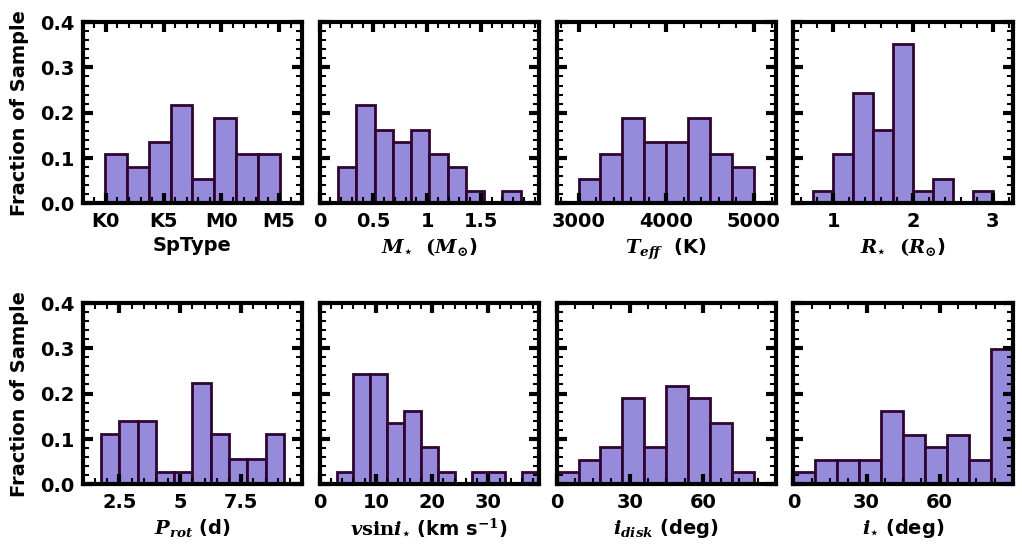

In [22]:
hist_fontsize = 14
hist_title_fontsize = 14
hist_color = '#958bda'  # '#669999'
hist_ylabel = 'Fraction of Sample'
hist_linecolor = '#2f0431'


hists_to_create = {'SpType': {'Title': 'SpType',
                                      'Label': 'SpType',
                                      'Save Text': 'SpType',
                                      'Bin Width': 0.19,
                                      'Bin Range': [3.80, 5.65]
                                      },
                            'Mstar (Msun)': {'Title': 'Stellar Mass',
                                            'Label': r'$M_{\mathdefault{\star}}$  $(M_{\odot}$)',
                                            'Save Text': 'Mstar_distribution_stassun_',
                                            'Bin Width': 0.17,
                                            'Bin Range': [0, 2]
                                            },
                            'Teff (K)': {'Title': r'Stellar $T_{eff}$',
                                            'Label': r'$T_{eff}$  (K)',
                                            'Save Text': 'Teff_distribution_stassun_',
                                            'Bin Width': 250,
                                            'Bin Range': [2750, 5250]  # [2750, 5500]
                                            },
                            'Rstar (Rsun)': {'Title': 'Stellar Radius',
                                            'Label': r'$R_{\mathdefault{\star}}$  $(R_{\odot}$)',
                                            'Save Text': 'radii_distribution_stassun_',
                                            'Bin Width': 0.25,
                                            'Bin Range': [0.50, 3.10]  # [0.30, 3.60]
                                            },
                            'Prot (d)': {'Title': 'Rotation Period',
                                        'Label': r'$P_{rot}$ (d)',
                                        'Save Text': 'Prot_distribution_stassun_',
                                        'Bin Width': 0.75,  # 0.8 
                                        'Bin Range': [1, 10]
                                        },
                            'vsini (km/s)': {'Title': r'Stellar $v\mathrm{sin}i_{\mathdefault{\star}}$',
                                            'Label': r'$v\mathrm{sin}i_{\mathdefault{\star}}$ (km s$^{-1}$)',
                                            'Save Text': 'vsini_distribution_stassun_',
                                            'Bin Width': 3,
                                            'Bin Range': [3, 38]
                                            },
                            'i pp disk (deg)': {'Title': 'Disk Incl',
                                               'Label': r'$i_{disk}$ (deg)',
                                               'Save Text': 'iDisk_distribution_stassun_',
                                               'Bin Width': 9,
                                               'Bin Range': [0, 90]
                                               },
                            'i star (deg)': {'Title': 'Stellar Incl',
                                            'Label': r'$i_{\mathdefault{\star}}$ (deg)',
                                            'Save Text': 'iStar_distribution_stassun_',
                                            'Bin Width': 9,
                                            'Bin Range': [0, 90]
                                            },
                           }


grid_width = 4
grid_height = 2

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(grid_height , grid_width , width_ratios=[1, 1, 1, 1], wspace=0.08, hspace=0.55)
axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height ) for jj in range(grid_width )]
ax_keys = list(hists_to_create.keys())

for ax_i, ax in enumerate(axes):

    ax.minorticks_on()

    bin_width = hists_to_create[ax_keys[ax_i]]['Bin Width']
    hist_bins = np.arange(hists_to_create[ax_keys[ax_i]]['Bin Range'][0], hists_to_create[ax_keys[ax_i]]['Bin Range'][1] + bin_width, bin_width)
    bin_vals_stassun, bin_edges = np.histogram(condensed_df_stassun[ax_keys[ax_i]].values, bins=hist_bins)
    bin_vals_fraction_stassun = bin_vals_stassun / sum(bin_vals_stassun)

    ax.minorticks_on()

    # ax.set_title(hists_to_create[ax_keys[ax_i]]['Title'], fontsize=hist_fontsize)

    # if '\n' not in hists_to_create[ax_keys[ax_i]]['Title']:
    #     ax.text(0.50, 0.86, hists_to_create[ax_keys[ax_i]]['Title'], fontsize=hist_fontsize,
    #             horizontalalignment='center', verticalalignment='bottom', zorder=2, transform=ax.transAxes)
    # else:
    #     ax.text(0.50, 0.78, hists_to_create[ax_keys[ax_i]]['Title'], fontsize=hist_fontsize,
    #             horizontalalignment='center', verticalalignment='bottom', zorder=2, transform=ax.transAxes)
    
    # ax.set_title(hists_to_create[ax_keys[ax_i]]['Title'], fontsize=hist_title_fontsize)
    ax.set_xlabel(hists_to_create[ax_keys[ax_i]]['Label'], fontsize=hist_fontsize)
    if np.mod(ax_i, grid_width ) == 0:
        ax.set_ylabel(hist_ylabel, fontsize=hist_fontsize, labelpad=8)
    else:
        ax.set_yticklabels([])

    ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_fraction_stassun, edgecolor=hist_linecolor, color=hist_color, lw=2, width=bin_width, align='center', label='TIC')

    if ((ax_keys[ax_i] == 'Rstar (Rsun)') or (ax_keys[ax_i] == 'i star (deg)')) and (do_all_radii == True):
        bin_vals_all, bin_edges = np.histogram(condensed_df_all[ax_keys[ax_i]].values, bins=hist_bins)
        bin_vals_fraction_all = bin_vals_all / sum(bin_vals_all)
        ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_fraction_all, hatch='///', edgecolor='#33cccc', color='None', lw=2, width=bin_width, align='center', label='Lit')
        ax.legend(loc='upper left', prop={'size': 12}, ncol=2)  # , bbox_to_anchor=(0., 0.5, 0.5, 0.35))

    xmin, xmax = min(hist_bins), max(hist_bins)
    ymin, ymax = 0, 0.40  # 14  # 1.15*max(bin_vals)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    if ax_keys[ax_i] == 'SpType':
        sptype_designations = {'3.75': 'G7.5',
                       '4.00': 'K0',
                       '4.25': 'K2.5',
                       '4.50': 'K5',
                       '4.75': 'K7.5',
                       '5.00': 'M0',
                       '5.25': 'M2.5',
                       '5.50': 'M5',
                       '5.75': 'M7.5',
                       }
        keys_list = list(sptype_designations.keys())
        xtickvals = [float(key) for key in keys_list]
        xticklabs = []
        xticks = []
        for xtick_i, xtick in enumerate(xtickvals):
            if (np.mod(xtick,0.5) == 0):  #  and (xtick >= xlims[0]):
                xticks.append(xtick)
                xticklabs.append(sptype_designations[keys_list[xtick_i]])
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabs, fontsize=hist_fontsize)

    if ax_keys[ax_i] == 'Mstar (Msun)':
        xtickvals = [0, 0.5, 1, 1.5]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if ax_keys[ax_i] == 'Prot (d)':
        xtickvals = [2.5, 5, 7.5]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if (ax_keys[ax_i] == 'i pp disk (deg)') or (ax_keys[ax_i] == 'i star (deg)'):
        xtickvals = [0, 30, 60]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if ax_keys[ax_i] == 'vsini (km/s)':
        xtickvals = [0, 10, 20, 30]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)




    ax.tick_params(labelsize=hist_fontsize)

    ax.set_rasterized(True)


if do_all_radii == False:
    save_hist_string = 'Histograms_' + resolution_text + '_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text + '_'  + date_str + '.pdf'
else:
    save_hist_string = 'Histograms_' + resolution_text + '_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text + '_all_'  + date_str + '.pdf'

if plot_transparent == True:
    fig.savefig(test_figures_directory + save_hist_string, dpi=300, transparent=True)
else:
    fig.savefig(test_figures_directory + save_hist_string, dpi=300, transparent=False)

plt.show()


In [23]:
# where_iDisks_master_nan = np.where(np.isnan(iDisks_master) == True)[0]
# print(iDisks_targets_master[where_iDisks_master_nan])
# print(iDisks_source_master[where_iDisks_master_nan])

In [24]:
def truncate_and_normalize(convolution, original_x_array, normalize=False):
    """
    Truncate and normalize the convolution of two probability distributions and
    return the corresponding x-array.

    :param convolution: The convolution result array.
    :param original_x_array: The original x-values array.
    :return: A tuple containing the truncated and normalized convolution array and the corresponding x-array.
    """
    # Determine the spacing between x values (dx)
    dx = np.mean(np.diff(original_x_array))

    # Extend the original x-array to match the convolution range
    extended_x_min = original_x_array[0] - (len(convolution) - len(original_x_array)) / 2 * dx
    extended_x_max = original_x_array[-1] + (len(convolution) - len(original_x_array)) / 2 * dx
    extended_x_array = np.arange(extended_x_min, extended_x_max, dx)

    # Ensure extended array is not longer than the convolution array
    extended_x_array = extended_x_array[:len(convolution)]

    # Find indices where the extended x-array overlaps with the original x-array range
    indices = np.where((extended_x_array >= original_x_array[0]) & (extended_x_array <= original_x_array[-1]))[0]
    truncated_convolution = convolution[indices[0]:indices[-1] + 1]

     # Normalize the truncated convolution
    normalized_convolution = truncated_convolution / (np.sum(truncated_convolution) * dx)

    adjusted_x_array = extended_x_array[indices[0]:indices[-1] + 1]

    if normalize == False:
        return_convolution = truncated_convolution
    else:
        return_convolution = normalized_convolution

    return return_convolution, adjusted_x_array









Number of Disks In Master Population:  151
iDisk_master_mean: 3.980197519331188
iDisk_filtered_mean: 1.7056478159963997
istar_mean: 3.980197519331188
 
bandwidth_master:  1.990098759665594
bandwidth_filtered:  1.990098759665594
bandwidth_istars:  1.990098759665594
 


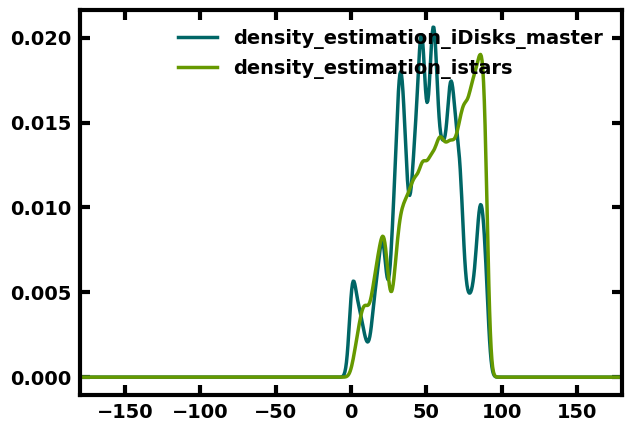

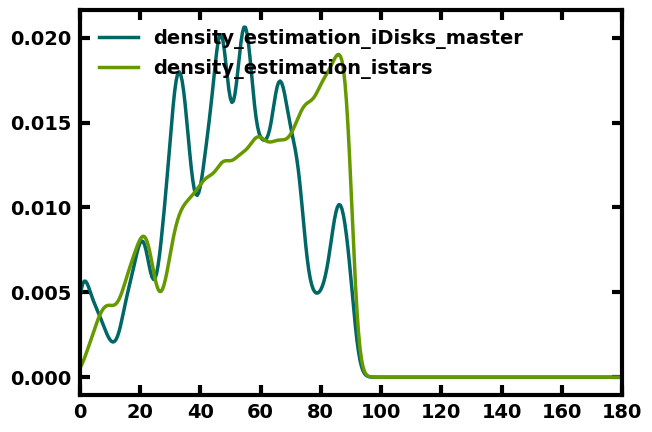

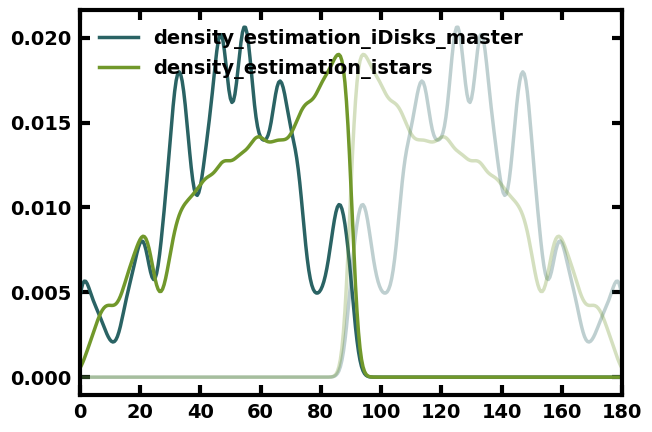

In [445]:


# hist_iDisk_bin_width = 9
# hist_iDisk_bins = np.arange(0, 90 + hist_iDisk_bin_width, hist_iDisk_bin_width)

# bin_vals_master, bin_edges_master = np.histogram(iDisks_master, bins=hist_iDisk_bins)
# bin_vals_filtered, bin_edges_filtered = np.histogram(condensed_df_stassun['i pp disk (deg)'].values, bins=hist_iDisk_bins)
# bin_vals_istars, bin_edges_istars = np.histogram(condensed_df_stassun['i star (deg)'].values, bins=hist_iDisk_bins)

# ax.bar(bin_edges_master[:-1] + 0.5*hist_iDisk_bin_width, bin_vals_master/max(bin_vals_master), edgecolor=hist_linecolor, color=hist_color, lw=2, width=hist_iDisk_bin_width, align='center', label=r'$i_{disk}$ Master', zorder=-2)
# ax.bar(bin_edges_filtered[:-1] + 0.5*hist_iDisk_bin_width, bin_vals_filtered/max(bin_vals_filtered), hatch='///', edgecolor='#33cccc', color='None', lw=2, width=hist_iDisk_bin_width, align='center', label=r'$i_{disk}$ Filtered', zorder=-1)
# ax.bar(bin_edges_istars[:-1] + 0.5*hist_iDisk_bin_width, bin_vals_istars/max(bin_vals_istars), hatch=".", edgecolor='#ff3385', color='None', lw=2, width=hist_iDisk_bin_width, align='center', label=r'$i_{\mathdefault{\star}}$ (deg)', zorder=0)


# ------------------- COMPUTE AND PLOT KDE ------------------- # 


# Q1_master, Q3_master = np.percentile(iDisks_master, 25), np.percentile(iDisks_master, 75)
# IQR_master = Q3_master - Q1_master
# bandwidth_master = (2 * IQR_master) / (len(iDisks_master)**(1/3))

# Q1_filtered, Q3_filtered = np.percentile(condensed_df_stassun['i pp disk (deg)'].values, 25), np.percentile(condensed_df_stassun['i pp disk (deg)'].values, 75)
# IQR_filtered = Q3_filtered - Q1_filtered
# bandwidth_filtered = (2 * IQR_filtered) / (len(condensed_df_stassun['i pp disk (deg)'].values)**(1/3))

# Q1_istars, Q3_istars = np.percentile(condensed_df_stassun['i star (deg)'].values, 25), np.percentile(condensed_df_stassun['i star (deg)'].values, 75)
# IQR_istars = Q3_istars - Q1_istars
# bandwidth_istars = bandwidth_filtered  #  = (2 * IQR_istars) / (len(condensed_df_stassun['i star (deg)'].values)**(1/3))

print('Number of Disks In Master Population: ', len(iDisks_master))

kde_n_draws = int(1e3)

x_grid_increment = 0.5
x_grid_values = np.arange(0, 180 + x_grid_increment, x_grid_increment)
x_grid = x_grid_values.reshape(-1, 1)
reverse_x_grid_values = -x_grid_values[::-1][:-1]
all_x_grid_values = np.concatenate((np.array(reverse_x_grid_values), np.array(x_grid_values)))
x_grid_all = np.array(all_x_grid_values).reshape(-1, 1)

kde_color_master = '#666699'
kde_color_filtered = hist_color
kde_color_istars = '#ff527d'  # '#ff3385'

do_MAPs = False
if do_MAPs == False:
    # ------------------ DETERMINE X_GRID ------------------ #
    Posteriors = pd.read_csv(distribution_dir + 'Prob_CXTau.csv')
    # print(Posteriors.columns)
    x_grid_increment = np.diff(Posteriors['i (deg)'].values)[0]
    x_grid_values = np.arange(0, 180 + x_grid_increment, x_grid_increment)
    x_grid = x_grid_values.reshape(-1, 1)
    reverse_x_grid_values = -x_grid_values[::-1][:-1]
    all_x_grid_values = np.concatenate((np.array(reverse_x_grid_values), np.array(x_grid_values)))
    x_grid_draws = x_grid_all[(all_x_grid_values >= 0) & (all_x_grid_values <= 90)]
    x_grid_all = np.array(all_x_grid_values).reshape(-1, 1)
    
    istar_err_ratio = []
    iDisk_filtered_err_ratio = []
    
    # ------------------ DRAW FROM POSTERIORS ------------------ #
    data_for_kde_iDisks_master = [] 
    data_for_kde_iDisks_filtered = []
    data_for_kde_istars = []
    did_plot = 0
    for targetnum in range(len(iDisks_targets_master)):
        # print(iDisks_targets_master[targetnum])

        if iDisks_targets_master[targetnum] in condensed_df_stassun['Simbad Name'].values:

            target_str = iDisks_targets_master[targetnum].replace(' ', '')
            if '/' in iDisks_targets_master[targetnum]:
                target_str = target_str.replace('/', '-')

            Posteriors = pd.read_csv(distribution_dir + 'Prob_' + target_str + '.csv')
            iDisk_filtered_err_ratio.append(Posteriors['i Disk +Unc1'].values[0])  # /Posteriors['i Disk MAP'].values[0])
            istar_err_ratio.append(np.nanmean([Posteriors['i Star +Unc1'].values[0], Posteriors['i Star -Unc1'].values[0]]))  #  / 90.)  # Posteriors['i Star MAP'].values[0])


            P_Delta_i_target_filtered = np.array(Posteriors['P(i Disk | i)'].values)
            P_istar_target = np.array(Posteriors['P(i Star | i)'].values)
            # P_istar_target = norm.pdf(x=x_grid_draws, loc=5, scale=0.1)
            data_for_kde_iDisks_master.extend(choices(x_grid_draws, P_Delta_i_target_filtered, k=kde_n_draws)) 
            data_for_kde_iDisks_filtered.extend(choices(x_grid_draws, P_Delta_i_target_filtered, k=kde_n_draws))
            data_for_kde_istars.extend(choices(x_grid_draws, P_istar_target, k=kde_n_draws))
        else:
            i_disk_dist = norm.pdf(x=x_grid_draws, loc=iDisks_master[targetnum], scale=iDisks_err_master[targetnum])
            disk_draws = choices(x_grid_draws, i_disk_dist, k=kde_n_draws)
            data_for_kde_iDisks_master.extend(disk_draws)   

    data_for_kde_iDisks_master = np.array(data_for_kde_iDisks_master).reshape(-1, 1)
    data_for_kde_iDisks_filtered = np.array(data_for_kde_iDisks_filtered).reshape(-1, 1)
    data_for_kde_istars = np.array(data_for_kde_istars).reshape(-1, 1)

    iDisk_master_err_ratio = iDisks_err_master  # / 90.  # iDisks_master

    print('2 * iDisk_master_mean:', 2 * np.nanmean(iDisk_master_err_ratio))
    print(' ')

    bandwidth_master = 0.5 * np.nanmean(iDisk_master_err_ratio)
    bandwidth_filtered = bandwidth_master
    bandwidth_istars = bandwidth_master
    # bandwidth_master = 6
    # bandwidth_filtered = 6
    # bandwidth_istars = 3

    # Q1_master, Q3_master = np.percentile(data_for_kde_iDisks_master, 25), np.percentile(data_for_kde_iDisks_master, 75)
    # IQR_master = Q3_master - Q1_master
    # bandwidth_master = (2 * IQR_master) / (len(data_for_kde_iDisks_master)**(1/3))

    # Q1_filtered, Q3_filtered = np.percentile(data_for_kde_iDisks_filtered, 25), np.percentile(data_for_kde_iDisks_filtered, 75)
    # IQR_filtered = Q3_filtered - Q1_filtered
    # bandwidth_filtered = (2 * IQR_filtered) / (len(data_for_kde_iDisks_filtered)**(1/3))

    # Q1_istars, Q3_istars = np.percentile(data_for_kde_istars, 25), np.percentile(data_for_kde_istars, 75)
    # IQR_istars = Q3_istars - Q1_istars
    # bandwidth_istars = (2 * IQR_istars) / (len(data_for_kde_istars)**(1/3))
    
else:
    data_for_kde_iDisks_master = np.array(iDisks_master).reshape(-1, 1)
    data_for_kde_iDisks_filtered = np.array(condensed_df_stassun['i pp disk (deg)'].values).reshape(-1, 1)
    data_for_kde_istars = np.array(condensed_df_stassun['i star (deg)'].values).reshape(-1, 1)

    bandwidth_master = 7
    bandwidth_filtered = 9
    bandwidth_istars = 9

print('bandwidth_master: ', bandwidth_master)
print('bandwidth_filtered: ', bandwidth_filtered)
print('bandwidth_istars: ', bandwidth_istars)
print(' ')



kde_iDisks_master = KernelDensity(kernel='gaussian', bandwidth=bandwidth_master).fit(data_for_kde_iDisks_master)
kde_iDisks_filtered = KernelDensity(kernel='gaussian', bandwidth=bandwidth_filtered).fit(data_for_kde_iDisks_filtered)
kde_istars = KernelDensity(kernel='gaussian', bandwidth=bandwidth_istars).fit(data_for_kde_istars)


log_density_iDisks_master = kde_iDisks_master.score_samples(x_grid_all)
log_density_iDisks_filtered = kde_iDisks_filtered.score_samples(x_grid_all)
log_density_istars = kde_istars.score_samples(x_grid_all)

density_estimation_iDisks_master = np.array(np.exp(log_density_iDisks_master))
density_estimation_iDisks_filtered = np.array(np.exp(log_density_iDisks_filtered))
density_estimation_istars = np.array(np.exp(log_density_istars))
# density_estimation_iDisks_master_convolved_with_istars_untruncated = np.convolve(density_estimation_iDisks_master, density_estimation_istars, mode='full')
# density_estimation_iDisks_master_convolved_with_istars, conv_x = truncate_and_normalize(convolution=density_estimation_iDisks_master_convolved_with_istars_untruncated, original_x_array=all_x_grid_values, normalize=True)



# print('len(convolution)', len(density_estimation_iDisks_master_convolved_with_istars))
# print('len(all_grid_x_values)', len(all_x_grid_values))
# print('len(conv_x)', len(conv_x))
# print('min max conv_x', min(conv_x), max(conv_x))
# print(' ')

plt.plot(x_grid_all, density_estimation_iDisks_master, label='density_estimation_iDisks_master')
plt.plot(x_grid_all, density_estimation_istars, label='density_estimation_istars')
# plt.plot(conv_x, density_estimation_iDisks_master_convolved_with_istars, label='convolution')
plt.xlim(min(x_grid_all), max(x_grid_all))
plt.legend(loc='best')
plt.show()

# x_full = np.arange(0, len(density_estimation_iDisks_master_convolved_with_istars), np.diff(all_x_grid_values)[0])
# xtest_convolve = 0.5 * np.array(x_full[0::2]) * np.diff(all_x_grid_values)[0]
# xtest_convolve = xtest_convolve[0::2] - 180
# density_estimation_iDisks_master_convolved_with_istars = density_estimation_iDisks_master_convolved_with_istars[0::2]

density_estimation_mirrored_iDisks_master_1 = density_estimation_iDisks_master[::-1]
density_estimation_mirrored_iDisks_filtered_1 = density_estimation_iDisks_filtered[::-1]
density_estimation_mirrored_istars_1 = density_estimation_istars[::-1]
# density_estimation_mirrored_iDisks_master_convolved_with_istars_1 = density_estimation_iDisks_master_convolved_with_istars[::-1]


density_estimation_total_iDisks_master_bep = density_estimation_iDisks_master #  + density_estimation_mirrored_iDisks_master_1
density_estimation_total_iDisks_filtered_bep = density_estimation_iDisks_filtered #  + density_estimation_mirrored_iDisks_filtered_1
density_estimation_total_istars_bep = density_estimation_istars #  + density_estimation_mirrored_istars_1
# density_estimation_total_iDisks_master_convolved_with_istars_bep = density_estimation_iDisks_master_convolved_with_istars #  + density_estimation_mirrored_iDisks_master_convolved_with_istars_1

density_estimation_total_positive_x_iDisks_master_bep = density_estimation_total_iDisks_master_bep[all_x_grid_values >= 0]
density_estimation_total_positive_x_iDisks_filtered_bep = density_estimation_total_iDisks_filtered_bep[all_x_grid_values >= 0]
density_estimation_total_positive_x_istars_bep = density_estimation_total_istars_bep[all_x_grid_values >= 0]
# density_estimation_total_iDisks_master_convolved_with_istars_bep = density_estimation_total_iDisks_master_convolved_with_istars_bep[all_x_grid_values >= 0]

conv_x_bep = all_x_grid_values[all_x_grid_values >= 0]

plt.plot(conv_x_bep, density_estimation_total_positive_x_iDisks_master_bep, label='density_estimation_iDisks_master')
plt.plot(conv_x_bep, density_estimation_total_positive_x_istars_bep, label='density_estimation_istars')
# plt.plot(conv_x_bep, density_estimation_total_iDisks_master_convolved_with_istars_bep, label='convolution')
plt.xlim(min(conv_x_bep), max(conv_x_bep))
plt.legend(loc='upper left')
plt.show()

density_estimation_mirrored_iDisks_master_2 = density_estimation_total_positive_x_iDisks_master_bep[::-1]
density_estimation_mirrored_iDisks_filtered_2 = density_estimation_total_positive_x_iDisks_filtered_bep[::-1]
density_estimation_mirrored_istars_2 = density_estimation_total_positive_x_istars_bep[::-1]
# density_estimation_mirrored_iDisks_master_convolved_with_istars_2 = density_estimation_total_iDisks_master_convolved_with_istars_bep[::-1]

plt.plot(conv_x_bep, density_estimation_total_positive_x_iDisks_master_bep, color='#2a6364', label='density_estimation_iDisks_master')
plt.plot(conv_x_bep, density_estimation_mirrored_iDisks_master_2, alpha=0.3, color='#2a6364')
plt.plot(conv_x_bep, density_estimation_total_positive_x_istars_bep, color='#71982b', label='density_estimation_istars')
plt.plot(conv_x_bep, density_estimation_mirrored_istars_2, alpha=0.3, color='#71982b')
# plt.plot(conv_x_bep, density_estimation_total_iDisks_master_convolved_with_istars_bep, color='#c49b33', label='convolution')
# plt.plot(conv_x_bep, density_estimation_mirrored_iDisks_master_convolved_with_istars_2, alpha=0.3, color='#c49b33')
plt.xlim(min(conv_x_bep), max(conv_x_bep))
# plt.ylim(0, 1.25*max(density_estimation_total_iDisks_master_convolved_with_istars_bep))
plt.legend(loc='upper left')
plt.show()

density_estimation_total_iDisks_master = density_estimation_total_positive_x_iDisks_master_bep + density_estimation_mirrored_iDisks_master_2
density_estimation_total_iDisks_filtered = density_estimation_total_positive_x_iDisks_filtered_bep + density_estimation_mirrored_iDisks_filtered_2
density_estimation_total_iDisks_istars = density_estimation_total_positive_x_istars_bep + density_estimation_mirrored_istars_2
# density_estimation_total_iDisks_master_convolved_with_istars = density_estimation_total_iDisks_master_convolved_with_istars_bep + density_estimation_mirrored_iDisks_master_convolved_with_istars_2

x_grid_positive = all_x_grid_values[all_x_grid_values >= 0]

density_estimation_total_positive_x_iDisks_master = density_estimation_total_iDisks_master[x_grid_positive <= 90]
density_estimation_total_positive_x_iDisks_filtered = density_estimation_total_iDisks_filtered[x_grid_positive <= 90]
density_estimation_total_positive_x_istars = density_estimation_total_iDisks_istars[x_grid_positive <= 90]
# density_estimation_total_positive_x_iDisks_master_convolved_with_istars = density_estimation_total_iDisks_master_convolved_with_istars[x_grid_positive <= 90]

# density_estimation_total_positive_x_iDisks_master = density_estimation_total_positive_x_iDisks_master[x_grid_positive <= 90]
# density_estimation_total_positive_x_iDisks_filtered = density_estimation_total_positive_x_iDisks_filtered[x_grid_positive <= 90]
# density_estimation_total_positive_x_istars = density_estimation_total_positive_x_istars[x_grid_positive <= 90]
# density_estimation_total_positive_x_iDisks_master_convolved_with_istars = density_estimation_total_iDisks_master_convolved_with_istars_bep[x_grid_positive <= 90]

# density_estimation_total_positive_x_iDisks_master = density_estimation_total_positive_x_iDisks_master / (sum(density_estimation_total_positive_x_iDisks_master) * np.diff(all_x_grid_values)[0])
# density_estimation_total_positive_x_iDisks_filtered = density_estimation_total_positive_x_iDisks_filtered / (sum(density_estimation_total_positive_x_iDisks_filtered) * np.diff(all_x_grid_values)[0])
# density_estimation_total_positive_x_istars = density_estimation_total_positive_x_istars / (sum(density_estimation_total_positive_x_istars) * np.diff(all_x_grid_values)[0])
# density_estimation_total_positive_x_iDisks_master_convolved_with_istars = density_estimation_total_positive_x_iDisks_master_convolved_with_istars / (sum(density_estimation_total_positive_x_iDisks_master_convolved_with_istars) * np.diff(all_x_grid_values)[0])


density_estimation_total_positive_x_iDisks_master_convolved_with_istars = density_estimation_total_positive_x_iDisks_master * density_estimation_total_positive_x_istars
density_estimation_total_positive_x_iDisks_master_convolved_with_istars = density_estimation_total_positive_x_iDisks_master_convolved_with_istars / (sum(density_estimation_total_positive_x_iDisks_master_convolved_with_istars) * np.diff(all_x_grid_values)[0])

x_grid_plot = x_grid_positive[x_grid_positive <= 90]


# plt.fill_between(x_grid_positive, density_estimation_total_positive_x_iDisks_master, alpha=0.3, color='#2a6364', label='density_estimation_iDisks_master')
# plt.fill_between(x_grid_positive, density_estimation_mirrored_iDisks_master_2, alpha=0.3, color='#2a6364')
# plt.plot(x_grid_plot, density_estimation_total_positive_x_iDisks_master, color='#2a6364')
# plt.plot([x_grid_plot[-1], x_grid_plot[-1]], [0, density_estimation_total_positive_x_iDisks_master[-1]], color='#2a6364')
# plt.fill_between(x_grid_positive, density_estimation_total_positive_x_istars, alpha=0.3, color='#71982b', label='density_estimation_istars')
# plt.fill_between(x_grid_positive, density_estimation_mirrored_istars_2, alpha=0.3, color='#71982b')
# plt.plot(x_grid_plot, density_estimation_total_positive_x_istars, color='#71982b')
# plt.plot([x_grid_plot[-1], x_grid_plot[-1]], [0, density_estimation_total_positive_x_istars[-1]], color='#71982b')
# # plt.fill_between(conv_x_bep, density_estimation_total_iDisks_master_convolved_with_istars_bep, alpha=0.3, color='#c49b33', label='convolution')
# # plt.fill_between(conv_x_bep, density_estimation_mirrored_iDisks_master_convolved_with_istars_2, alpha=0.3, color='#c49b33')
# # plt.plot(x_grid_plot, density_estimation_total_positive_x_iDisks_master_convolved_with_istars, color='#c49b33')
# # plt.plot([x_grid_plot[-1], x_grid_plot[-1]], [0, density_estimation_total_positive_x_iDisks_master_convolved_with_istars[-1]], color='#c49b33')
# plt.xlim(min(x_grid_positive), max(x_grid_positive))
# # plt.ylim(0, 1.25*max(density_estimation_total_positive_x_iDisks_master_convolved_with_istars))
# plt.legend(loc='upper left')
# plt.show()



# Just a lil test

# convolve_test_untruncated = np.convolve(density_estimation_iDisks_master[(all_x_grid_values >= 0) & (all_x_grid_values<= 90)], density_estimation_istars[(all_x_grid_values >= 0) & (all_x_grid_values<= 90)], mode='full')
# # convolve_test, conv_x_test = truncate_and_normalize(convolution=convolve_test_untruncated, original_x_array=x_grid_plot, normalize=True)
# convolve_test_untruncated = convolve_test_untruncated / (sum(convolve_test_untruncated) * np.diff(x_grid_plot)[0])
# extended_x_min = x_grid_plot[0] - (len(convolve_test_untruncated) - len(x_grid_plot)) / 2 * np.diff(x_grid_plot)[0]
# extended_x_max = x_grid_plot[-1] + (len(convolve_test_untruncated) - len(x_grid_plot)) / 2 * np.diff(x_grid_plot)[0]
# extended_x_array = np.arange(extended_x_min, extended_x_max, np.diff(x_grid_plot)[0])
# extended_x_array = extended_x_array[:len(convolve_test_untruncated)]

# where_lt0 = np.where(extended_x_array <= 0)[0]
# where_gt90 = np.where(extended_x_array >= 90)[0]
# where_middle = np.where((extended_x_array > 0) & (extended_x_array < 90))[0]

# # print(len(where_lt0))
# # print(len(where_gt90))

# lt0_reverse = convolve_test_untruncated[where_lt0][::-1]
# gt90_reverse = convolve_test_untruncated[where_gt90][::-1]
# middle = [0]* len(where_middle)
# add_to_convolved = np.concatenate((lt0_reverse, gt90_reverse))

# convolve_test_truncated = convolve_test_untruncated[:-1][(extended_x_array >= 0) & (extended_x_array <= 90)]
# # print(len(convolve_test_truncated), len(add_to_convolved))
# convolve_test = convolve_test_truncated + add_to_convolved

# # print(len(convolve_test), len(x_grid_plot))

# # plt.plot(conv_x_test, density_estimation_total_positive_x_iDisks_master, label='density_estimation_iDisks_master')
# # plt.plot(conv_x_test, density_estimation_total_positive_x_istars, label='density_estimation_istars')
# # plt.plot(conv_x_test, density_estimation_total_positive_x_iDisks_master_convolved_with_istars_test, label='convolution')
# plt.plot(extended_x_array, convolve_test_untruncated[:-1], label='convolution untruncated')
# plt.plot(x_grid_plot, convolve_test, label='convolution test')
# plt.xlim(min(conv_x_test), max(conv_x_test))
# plt.legend(loc='upper left')
# plt.show()


# density_estimation_total_positive_x_iDisks_master_convolved_with_istars = convolve_test



K-S Statistic: 0.3181081081081081
p-value:  0.11571733880808276
 
Area under KDE (Simpson):  0.9946 Close enough to 1:  True
Area under KDE (Trapz):  0.9946 Close enough to 1:  True





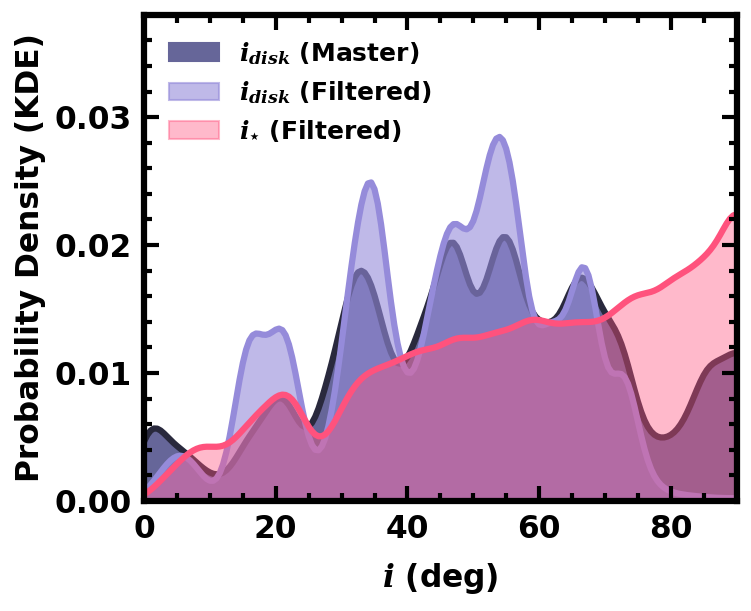

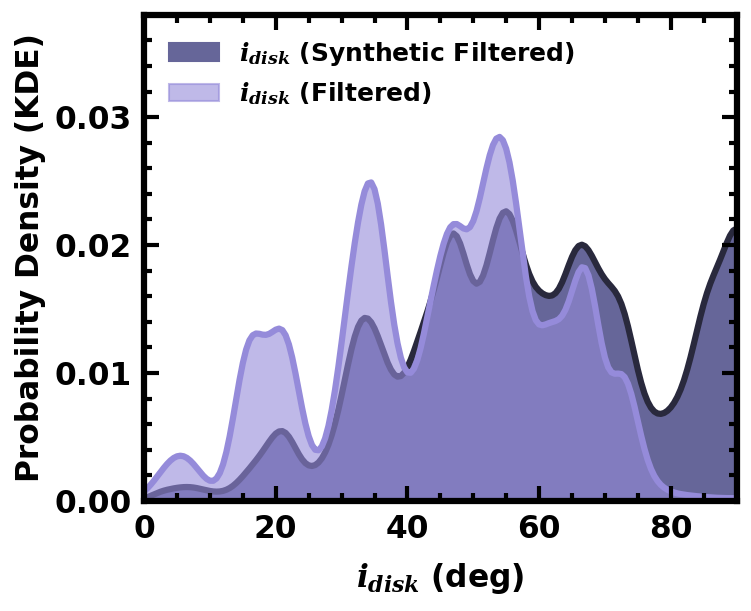

In [446]:
ks_n_draws = 37
ks_rounds = 100
ks_tests = []
p_tests = []
for round_i in range(ks_rounds):
    synthetic_iDisk_population = choices(x_grid_plot, density_estimation_total_positive_x_iDisks_master_convolved_with_istars, k=ks_n_draws)
    filtered_iDisk_population = choices(x_grid_plot, density_estimation_total_positive_x_iDisks_filtered, k=ks_n_draws)
    ks_statistic, p_value = stats.ks_2samp(synthetic_iDisk_population,filtered_iDisk_population)
    ks_tests.append(ks_statistic)
    p_tests.append(p_value)

print('K-S Statistic:', np.mean(ks_tests))
print('p-value: ', np.mean(p_tests))
print(' ')

total_area_simp = simps(density_estimation_total_positive_x_iDisks_master_convolved_with_istars, x_grid_plot)
total_area_trapz = np.trapz(density_estimation_total_positive_x_iDisks_master_convolved_with_istars,  x_grid_plot)
closeness_simp = np.isclose(total_area_simp, 1, atol=1e-2)
closeness_trapz = np.isclose(total_area_simp, 1, atol=1e-2)
print('Area under KDE (Simpson): ', total_area_simp.round(4), 'Close enough to 1: ', closeness_simp)
print('Area under KDE (Trapz): ', total_area_trapz.round(4), 'Close enough to 1: ', closeness_trapz)
print('\n\n')


Delta_i_hist_fontsize = 15

fig = plt.figure(figsize=(5, 4), dpi=150)
ax = fig.add_subplot(111)
ax.minorticks_on()

ax.set_xlabel(r'$i$ (deg)', fontsize=Delta_i_hist_fontsize, labelpad=8)
ax.set_ylabel('Probability Density (KDE)', fontsize=Delta_i_hist_fontsize)

ax.fill_between(x_grid_plot, density_estimation_total_positive_x_iDisks_master, color=kde_color_master, label=r'$i_{disk}$ (Master)', alpha=1, zorder=-2)
ax.plot(x_grid_plot, density_estimation_total_positive_x_iDisks_master, color='#29293d', lw=3, zorder=-2)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_iDisks_filtered, color=kde_color_filtered, label=r'$i_{disk}$ (Filtered)', alpha=0.6, zorder=-1)
ax.plot(x_grid_plot, density_estimation_total_positive_x_iDisks_filtered, color=kde_color_filtered, lw=3, zorder=-1)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_istars, color=kde_color_istars, label=r'$i_{\mathdefault{\star}}$ (Filtered)', alpha=0.4, zorder=0)
ax.plot(x_grid_plot, density_estimation_total_positive_x_istars, color=kde_color_istars, lw=3, zorder=-0)

ax.tick_params(which='minor', length=4, width=2, labelsize=Delta_i_hist_fontsize)
ax.tick_params(which='major', length=7, width=2, labelsize=Delta_i_hist_fontsize)

ax.legend(loc='upper left', prop={'size': 12}, ncol=1)

ax.set_xlim(0, 90)
ax.set_ylim(0, 0.038)
# ax.set_ylim(0, 1.25)

# fig.subplots_adjust(left=0.16, bottom=0.10, right=0.93, top=0.975, wspace=0.12, hspace=0.35)
fig.subplots_adjust(left=0.18, bottom=0.12, right=0.97, top=0.93, wspace=0.12, hspace=0.35)

plt.show()



fig = plt.figure(figsize=(5, 4), dpi=150)
ax = fig.add_subplot(111)
ax.minorticks_on()

ax.set_xlabel(r'$i_{disk}$ (deg)', fontsize=Delta_i_hist_fontsize, labelpad=8)
ax.set_ylabel('Probability Density (KDE)', fontsize=Delta_i_hist_fontsize)

# ax.fill_between(x_convolved, iDisks_master_convolved_with_istars, color=kde_color_master, label=r'$i_{disk}$ Master' + '\n' + r'Convolved with $i_{\mathdefault{\star}}$ (deg)', alpha=1, zorder=-2)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_iDisks_master_convolved_with_istars, color=kde_color_master, label=r'$i_{disk}$ (Synthetic Filtered)', alpha=1, zorder=-2)
ax.plot(x_grid_plot, density_estimation_total_positive_x_iDisks_master_convolved_with_istars, color='#29293d', lw=3, zorder=-2)
# ax.fill_between(x_grid_plot, convolve_test, color='lime', label='convolution test', alpha=0.2, zorder=-2)
# ax.plot(x_grid_plot, convolve_test, color='lime', lw=3, zorder=-2)
ax.fill_between(x_grid_plot, density_estimation_total_positive_x_iDisks_filtered, color=kde_color_filtered, label=r'$i_{disk}$ (Filtered)', alpha=0.6, zorder=-1)
ax.plot(x_grid_plot, density_estimation_total_positive_x_iDisks_filtered, color=kde_color_filtered, lw=3, zorder=-1)

ax.tick_params(which='minor', length=4, width=2, labelsize=Delta_i_hist_fontsize)
ax.tick_params(which='major', length=7, width=2, labelsize=Delta_i_hist_fontsize)

ax.legend(loc='upper left', prop={'size': 12}, ncol=1)

ax.set_xlim(0, 90)
ax.set_ylim(0, 0.038)
# ax.set_ylim(0, 1.25)

# fig.subplots_adjust(left=0.16, bottom=0.10, right=0.93, top=0.975, wspace=0.12, hspace=0.35)
fig.subplots_adjust(left=0.18, bottom=0.12, right=0.97, top=0.93, wspace=0.12, hspace=0.35)

plt.show()

In [447]:
n_draws = int(1e6)
i_disk_rand = choices(x_grid_plot, density_estimation_total_positive_x_iDisks_filtered, k=n_draws)
i_star_rand = choices(x_grid_plot, density_estimation_total_positive_x_istars, k=n_draws)
i_diff_rand = abs(np.array(i_disk_rand) - i_star_rand)


# i_disk_rand = choices(all_x_grid_values[(all_x_grid_values >= 0) & (all_x_grid_values <= 90)], density_estimation_iDisks_filtered[(all_x_grid_values >= 0) & (all_x_grid_values <= 90)], k=n_draws)
# i_star_rand = choices(all_x_grid_values[(all_x_grid_values >= 0) & (all_x_grid_values <= 90)], density_estimation_istars[(all_x_grid_values >= 0) & (all_x_grid_values<= 90)], k=n_draws)
# i_diff_rand = abs(np.array(i_disk_rand) - i_star_rand)


# plt.plot(all_x_grid_values[(all_x_grid_values >= 0) & (all_x_grid_values <= 90)], density_estimation_iDisks_filtered[(all_x_grid_values >= 0) & (all_x_grid_values <= 90)])
# plt.plot(all_x_grid_values[(all_x_grid_values >= 0) & (all_x_grid_values <= 90)], density_estimation_istars[(all_x_grid_values >= 0) & (all_x_grid_values<= 90)])
# plt.show()

bin_vals_i_diff, _ = np.histogram(i_diff_rand, bins=x_grid_plot)  # , density=True)

smooth_on = False
if smooth_on == True:
    smooth_over_deg = 0.5  #  bandwidth_master
    smooth_over_points = int(smooth_over_deg/np.diff(x_grid_plot)[0])
    if np.mod(smooth_over_points,2) != 0:
        smooth_over_points += 1
    smooth_vals_i_diff = gaussian_filter1d(bin_vals_i_diff, smooth_over_points, mode='nearest')
    i_diff_dist_from_kde = smooth_vals_i_diff / (sum(smooth_vals_i_diff) * np.diff(x_grid_plot)[0])
else:
    i_diff_dist_from_kde = bin_vals_i_diff/ (sum(bin_vals_i_diff) * np.diff(x_grid_plot)[0])

# # -------------------------------- DELTA i UNCERTAINTY --------------------------------- #
# i_diff_MAP, sig1_i_diff_m, sig1_i_diff_p = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=i_diff_dist_from_kde, sigma=0.6826)
# _, sig2_i_diff_m, sig2_i_diff_p = mode_pm_highest_density_interval(x=x_grid_plot, pdf_y=i_diff_dist_from_kde, sigma=0.9540)


total_area_simp = simps(i_diff_dist_from_kde, x_grid_plot[:-1])
total_area_trapz = np.trapz(i_diff_dist_from_kde,  x_grid_plot[:-1])
closeness_simp = np.isclose(total_area_simp, 1, atol=1e-2)
closeness_trapz = np.isclose(total_area_simp, 1, atol=1e-2)
print('Area under KDE (Simpson): ', total_area_simp.round(4), 'Close enough to 1: ', closeness_simp)
print('Area under KDE (Trapz): ', total_area_trapz.round(4), 'Close enough to 1: ', closeness_trapz)

print('\ndx = ', np.diff(all_x_grid_values)[0])

Area under KDE (Simpson):  0.9976 Close enough to 1:  True
Area under KDE (Trapz):  0.9972 Close enough to 1:  True

dx =  0.5


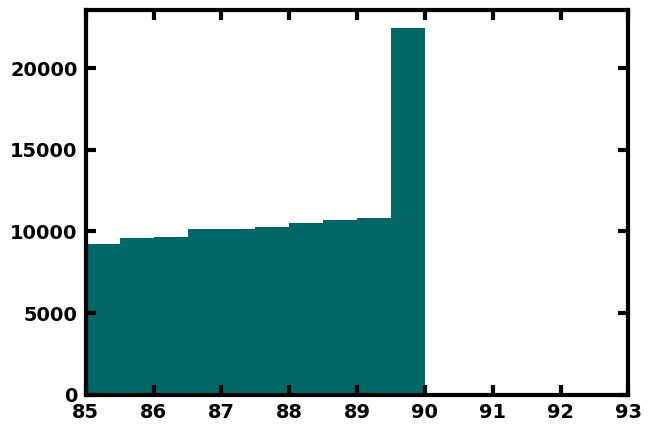

In [448]:
plt.hist(i_star_rand, bins=np.arange(0, 90 + 0.5, 0.5))
plt.xlim(85, 93)
plt.show()

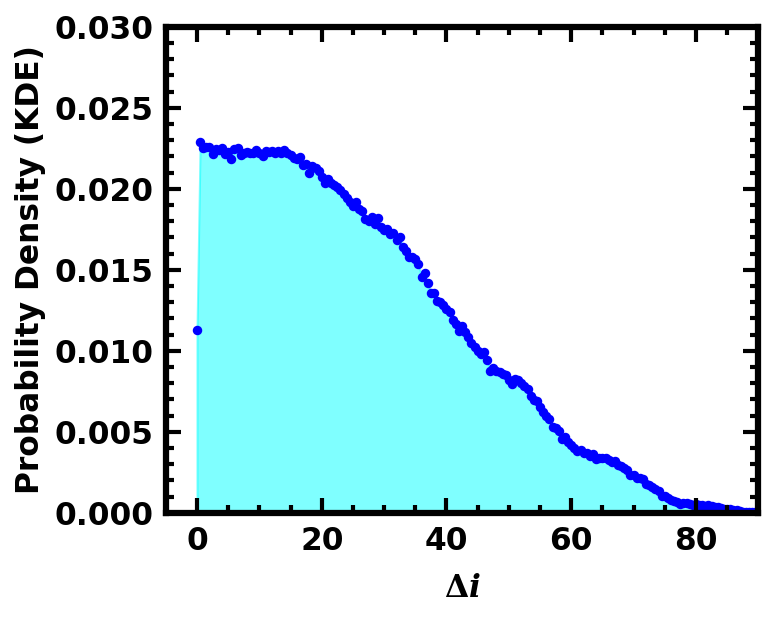

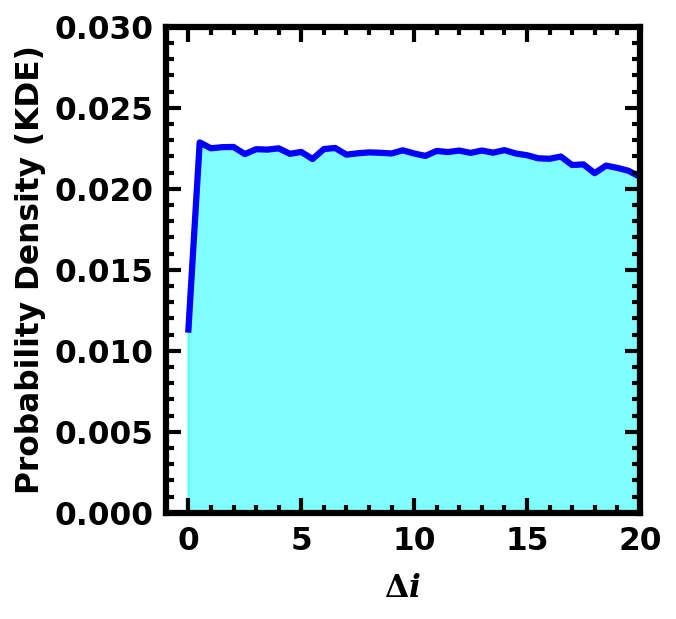

In [449]:
fig = plt.figure(figsize=(5, 4), dpi=150)
ax = fig.add_subplot(111)
ax.minorticks_on()

ax.set_xlabel(r'$\Delta i$', fontsize=Delta_i_hist_fontsize, labelpad=8)
ax.set_ylabel('Probability Density (KDE)', fontsize=Delta_i_hist_fontsize)

ax.fill_between(x_grid_plot[:-1], i_diff_dist_from_kde, color='cyan', alpha=0.5, zorder=-2)
# ax.plot(x_grid_plot[:-1], i_diff_dist_from_kde, color='blue', lw=3, zorder=-2)
ax.scatter(x_grid_plot[:-1], i_diff_dist_from_kde, color='blue', s=np.pi*(2)**2, zorder=-2)

ax.tick_params(which='minor', length=4, width=2, labelsize=Delta_i_hist_fontsize)
ax.tick_params(which='major', length=7, width=2, labelsize=Delta_i_hist_fontsize)

# ax.legend(loc='upper left', prop={'size': 12}, ncol=1)

ax.set_xlim(-5, 90)
ax.set_ylim(0, 0.03)
fig.subplots_adjust(left=0.18, bottom=0.12, right=0.97, top=0.93, wspace=0.12, hspace=0.35)

plt.show()

fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
ax.minorticks_on()

ax.set_xlabel(r'$\Delta i$', fontsize=Delta_i_hist_fontsize, labelpad=8)
ax.set_ylabel('Probability Density (KDE)', fontsize=Delta_i_hist_fontsize)

ax.fill_between(x_grid_plot[:-1], i_diff_dist_from_kde, color='cyan', alpha=0.5, zorder=-2)
ax.plot(x_grid_plot[:-1], i_diff_dist_from_kde, color='blue', lw=3, zorder=-2)

ax.tick_params(which='minor', length=4, width=2, labelsize=Delta_i_hist_fontsize)
ax.tick_params(which='major', length=7, width=2, labelsize=Delta_i_hist_fontsize)

# ax.legend(loc='upper left', prop={'size': 12}, ncol=1)

ax.set_xlim(-1, 20)
ax.set_ylim(0, 0.03)
fig.subplots_adjust(left=0.18, bottom=0.12, right=0.97, top=0.93, wspace=0.12, hspace=0.35)

plt.show()

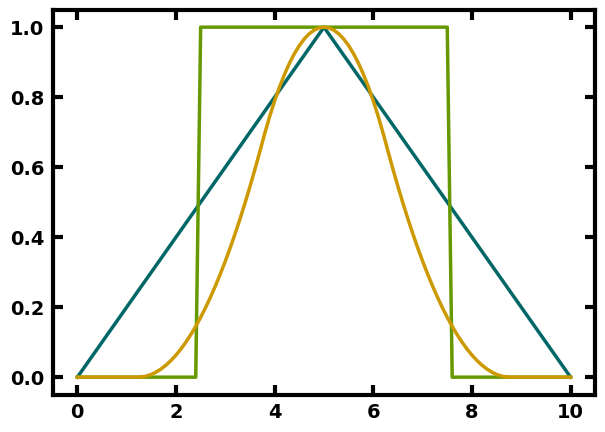

In [450]:
delta_xtest = 0.1
xtest = np.arange(0, 10 + delta_xtest, delta_xtest)
xtest_1 = np.arange(0, 5 + delta_xtest, delta_xtest)
ytest_1 = -xtest_1[::-1] + 5
ytest_2 = -xtest_1 + 5
ytest_triangle = np.concatenate((ytest_1, ytest_2[1::]))


xtest_2 = xtest[xtest < 2.5]
xtest_3 = xtest[(xtest >= 2.5) & (xtest <= 7.5)]
xtest_4 = xtest[xtest > 7.5]
ytest_square = np.concatenate(([0]*len(xtest_2), [2.5]*len(xtest_3), [0]*len(xtest_4)))

ytest_convolve = np.convolve(ytest_triangle, ytest_square, mode='same')
xtest_same = np.arange(0, len(ytest_convolve), 1)

ytest_convolve_full = np.convolve(ytest_triangle, ytest_square, mode='full')
xtest_full = np.arange(0, len(ytest_convolve_full), 1)

xtest_convolve = 0.5 * np.array(xtest_full[0::2]) * delta_xtest
ytest_convolve_full = ytest_convolve_full[0::2]


plt.plot(xtest, ytest_triangle/max(ytest_triangle))
plt.plot(xtest, ytest_square/max(ytest_square))
plt.plot(xtest_convolve, ytest_convolve_full/max(ytest_convolve_full))
plt.show()



In [451]:
condensed_df_stassun.columns

Index(['Target', 'Simbad Name', 'RA', 'DEC', 'SpType', 'SpType Unc',
       'i pp disk (deg)', 'i pp disk Unc', 'Rstar (Rsun)', 'Rstar Unc',
       'Mstar (Msun)', 'Mstar Unc', 'Prot (d)', 'Prot Unc', 'vsini (km/s)',
       'vsini Unc', 'Teff (K)', 'Teff Unc', 'Age (Myr)', 'Age Unc',
       'i star (deg)', 'i star +Unc', 'i star -Unc', 'disk diff',
       'disk diff +Unc', 'disk diff -Unc', 'Veq', 'Veq Unc'],
      dtype='object')

Precision of high incl vsinis: 
0.03 +/- 0.03
Precision of low incl vsinis: 
0.03 +/- 0.05
Precision of full sample vsinis: 
0.03 +/- 0.05


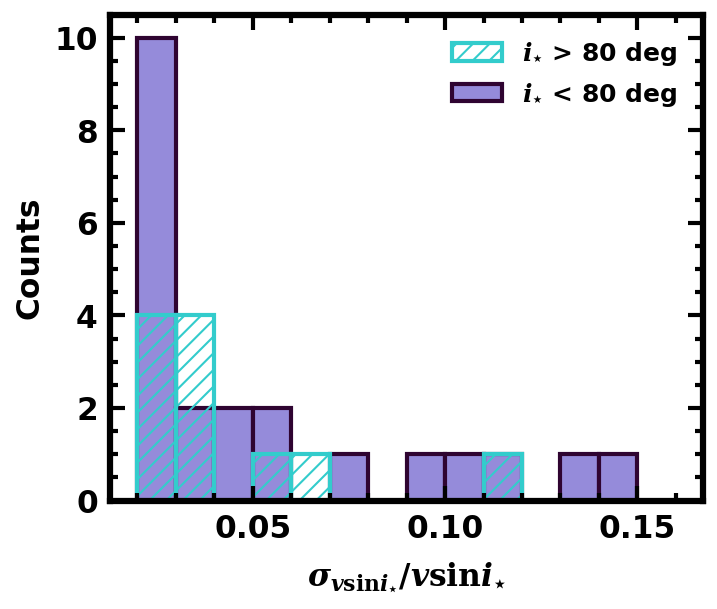

In [452]:
fig = plt.figure(figsize=(5, 4), dpi=150)
ax = fig.add_subplot(111)
# ax_twin = ax.twinx()

ax.minorticks_on()
# ax_twin.minorticks_on()

Delta_i_hist_fontsize = 15

ax.set_xlabel(r'$\sigma_{v\mathrm{sin}i_{\mathdefault{\star}}}$/$v\mathrm{sin}i_{\mathdefault{\star}}$', fontsize=Delta_i_hist_fontsize, labelpad=8)
ax.set_ylabel('Counts', fontsize=Delta_i_hist_fontsize)

high_incl_stars_df = condensed_df_stassun[condensed_df_stassun['i star (deg)'].values >= 80]
low_incl_stars_df = condensed_df_stassun[condensed_df_stassun['i star (deg)'].values < 80]
# all_incl_stars_df = condensed_df_stassun[condensed_df_stassun['vsini Unc'].values != 'ulimit']

# high_incl_stars_df = high_incl_stars_df[high_incl_stars_df['vsini Unc'].values != 'ulimit']
# low_incl_stars_df = low_incl_stars_df[low_incl_stars_df['vsini Unc'].values != 'ulimit']

hist_vsinis_high_incl_stars = np.array(high_incl_stars_df['vsini (km/s)'].values)
hist_vsini_errs_high_incl_stars = np.array([float(fweee) for fweee in high_incl_stars_df['vsini Unc'].values])
hist_vsinis_low_incl_stars = np.array(low_incl_stars_df['vsini (km/s)'].values)
hist_vsini_errs_low_incl_stars = np.array([float(fweee) for fweee in low_incl_stars_df['vsini Unc'].values])
hist_vsinis_all_incl_stars = np.array(condensed_df_stassun['vsini (km/s)'].values)
hist_vsini_errs_all_incl_stars = np.array([float(fweee) for fweee in condensed_df_stassun['vsini Unc'].values])


sigma_vsini_ratio_high_incl_stars = hist_vsini_errs_high_incl_stars / hist_vsinis_high_incl_stars
sigma_vsini_ratio_low_incl_stars = hist_vsini_errs_low_incl_stars / hist_vsinis_low_incl_stars
sigma_vsini_ratio_all_incl_stars = hist_vsini_errs_all_incl_stars / hist_vsinis_all_incl_stars


print('Precision of high incl vsinis: ')
print(np.median(sigma_vsini_ratio_high_incl_stars).round(2), '+/-', np.std(sigma_vsini_ratio_high_incl_stars, ddof=1).round(2))
print('Precision of low incl vsinis: ')
print(np.median(sigma_vsini_ratio_low_incl_stars).round(2), '+/-', np.std(sigma_vsini_ratio_low_incl_stars, ddof=1).round(2))
print('Precision of full sample vsinis: ')
print(np.median(sigma_vsini_ratio_all_incl_stars).round(2), '+/-', np.std(sigma_vsini_ratio_all_incl_stars, ddof=1).round(2))


hist_vsini_bin_width = 0.01
hist_vsini_bins = np.arange(0.02, 0.15 + hist_vsini_bin_width, hist_vsini_bin_width)

bin_vals_high_incl_stars, bin_edges_high_incl_stars = np.histogram(sigma_vsini_ratio_high_incl_stars, bins=hist_vsini_bins)
bin_vals_low_incl_stars, bin_edges_low_incl_stars = np.histogram(sigma_vsini_ratio_low_incl_stars, bins=hist_vsini_bins)

ax.bar(bin_edges_high_incl_stars[:-1] + 0.5*hist_vsini_bin_width , bin_vals_high_incl_stars, hatch='///', edgecolor='#33cccc', color='None', lw=2, width=hist_vsini_bin_width, align='center', label=r'$i_{\mathdefault{\star}}}$ > 80 deg', zorder=-1)
ax.bar(bin_edges_low_incl_stars[:-1] + 0.5*hist_vsini_bin_width , bin_vals_low_incl_stars, edgecolor=hist_linecolor, color=hist_color, lw=2, width=hist_vsini_bin_width, align='center', label=r'$i_{\mathdefault{\star}}}$ < 80 deg', zorder=-2)

ax.tick_params(which='minor', length=4, width=2, labelsize=Delta_i_hist_fontsize)
ax.tick_params(which='major', length=7, width=2, labelsize=Delta_i_hist_fontsize)

ax.legend(loc='upper right', prop={'size': 12}, ncol=1)

# fig.subplots_adjust(left=0.16, bottom=0.10, right=0.93, top=0.975, wspace=0.12, hspace=0.35)
fig.subplots_adjust(left=0.18, bottom=0.12, right=0.97, top=0.93, wspace=0.12, hspace=0.35)

plt.show()

In [453]:
if run_physicality_tests == True:

    Delta_i_hist_fontsize = 15

    temporary_df1 = condensed_df_only_stassun[condensed_df_only_stassun['vsini Unc'].values != 'ulimit']
    temporary_df1_all = condensed_df_no_stassun[condensed_df_no_stassun['vsini Unc'].values != 'ulimit']

    bep_list = ['2MASS J04322210+1827426', 'AA Tau', 'DoAr 25', 'IQ Tau', 'WSB 52']  # , 'WSB 63']
    bep_radii = []
    bep_radii_err = []
    bep_vsini = []
    bep_vsini_err = []
    bep_prot = []
    bep_prot_err = []
    bep_names = []

    bep_radii_all = []
    for bep_i in range(len(bep_list)):
        temporary_df2 = temporary_df1[temporary_df1['Simbad Name'].values == bep_list[bep_i]]
        temporary_df2_all = temporary_df1_all[temporary_df1_all['Simbad Name'].values == bep_list[bep_i]]
        bep_radii.append(temporary_df2['Rstar (Rsun)'].values[0])
        bep_radii_err.append(temporary_df2['Rstar Unc'].values[0])
        bep_vsini.append(temporary_df2['vsini (km/s)'].values[0])
        bep_vsini_err.append(temporary_df2['vsini Unc'].values[0])
        bep_prot.append(temporary_df2['Prot (d)'].values[0])
        bep_prot_err.append(temporary_df2['Prot Unc'].values[0])
        bep_radii_all.append(temporary_df2_all['Rstar (Rsun)'].values[0])
        bep_names.append(bep_list[bep_i])

    check_values = {'Simbad Name': bep_names,
                    'Rstar (Rsun)': bep_radii,
                    'Rstar Unc': bep_radii_err,
                    'vsini (km/s)': bep_vsini,
                    'vsini Unc': bep_vsini_err,
                    'Prot (d)': bep_prot,
                    'Prot Unc': bep_prot_err,
                    }

    check_props = ['Rstar (Rsun)', 'vsini (km/s)', 'Prot (d)']
    for check_prop in check_props:
        fig = plt.figure(figsize=(5, 4), dpi=150)
        ax = fig.add_subplot(111)
        ax.minorticks_on()

        ax.set_xlabel(hists_to_create[check_prop]['Label'], fontsize=Delta_i_hist_fontsize, labelpad=8)
        ax.set_ylabel('Counts', fontsize=Delta_i_hist_fontsize)

        check_bin_width = hists_to_create[check_prop]['Bin Width']
        check_hist_bins = np.arange(hists_to_create[check_prop]['Bin Range'][0], hists_to_create[check_prop]['Bin Range'][1] + check_bin_width, check_bin_width)

        check_hist_vals, check_hist_bin_edges = np.histogram(check_values[check_prop], bins=check_hist_bins)
        all_hist_vals, all_hist_bin_edges = np.histogram(temporary_df1[check_prop].values, bins=check_hist_bins)


        ax.bar(check_hist_bin_edges[:-1] + 0.5*check_bin_width, check_hist_vals, hatch='///', edgecolor='#33cccc', color='None', lw=2, width=check_bin_width, align='center', label='non-physical', zorder=-1)
        ax.bar(all_hist_bin_edges[:-1] + 0.5*check_bin_width, all_hist_vals, edgecolor=hist_linecolor, color=hist_color, lw=2, width=check_bin_width, align='center', label='all', zorder=-2)

        ax.tick_params(which='minor', length=4, width=2, labelsize=Delta_i_hist_fontsize)
        ax.tick_params(which='major', length=7, width=2, labelsize=Delta_i_hist_fontsize)

        ax.legend(loc='upper right', prop={'size': 12}, ncol=1)

        # fig.subplots_adjust(left=0.16, bottom=0.10, right=0.93, top=0.975, wspace=0.12, hspace=0.35)
        fig.subplots_adjust(left=0.18, bottom=0.12, right=0.97, top=0.93, wspace=0.12, hspace=0.35)

        plt.show()


    pass_targets = ['HQ Tau', 'SU Aur', 'Sz 73', 'WSB 67', 'HP Tau']
    no_stassun_radii = []
    only_stassun_radii = []
    check_stassun_radii = []
    check_all_radii = []
    no_stassun_periods = []
    only_stassun_periods = []
    no_stassun_vsini = []
    only_stassun_vsini = []
    for meep in range(len(condensed_df_all['Simbad Name'].values)):
        if (condensed_df_no_stassun['Simbad Name'].values[meep] in condensed_df_only_stassun['Simbad Name'].values) and (condensed_df_no_stassun['Simbad Name'].values[meep] not in bep_list):
            no_stassun_radii.append(condensed_df_no_stassun['Rstar (Rsun)'].values[meep])
            only_stassun_radii.append(condensed_df_only_stassun['Rstar (Rsun)'].values[meep])
            no_stassun_periods.append(condensed_df_no_stassun['Prot (d)'].values[meep])
            only_stassun_periods.append(condensed_df_only_stassun['Prot (d)'].values[meep])
            no_stassun_vsini.append(condensed_df_no_stassun['vsini (km/s)'].values[meep])
            only_stassun_vsini.append(condensed_df_only_stassun['vsini (km/s)'].values[meep])


    fig = plt.figure(figsize=(5, 4), dpi=150)
    ax = fig.add_subplot(111)
    ax.minorticks_on()

    ax.set_xlabel(r'$R_{S19}/R_{lit}$', fontsize=Delta_i_hist_fontsize, labelpad=8)
    ax.set_ylabel('Counts', fontsize=Delta_i_hist_fontsize)

    check_bin_width = 0.15
    check_hist_bins = np.arange(0.4, 2. + check_bin_width, check_bin_width)

    check_fractional_radii = np.array(bep_radii)/np.array(bep_radii_all)
    print(temporary_df1['Rstar (Rsun)'].values)
    print()
    print(print(temporary_df1['Rstar (Rsun)'].values))
    # check_fractional_radii = np.array(check_stassun_radii)/np.array(check_all_radii)
    all_fractional_radii = np.array(only_stassun_radii)/np.array(no_stassun_radii)

    check_hist_vals, check_hist_bin_edges = np.histogram(check_fractional_radii, bins=check_hist_bins)
    all_hist_vals, all_hist_bin_edges = np.histogram(all_fractional_radii, bins=check_hist_bins)


    ax.bar(check_hist_bin_edges[:-1] + 0.5*check_bin_width, check_hist_vals, hatch='///', edgecolor='#33cccc', color='None', lw=2, width=check_bin_width, align='center', label='non-physical', zorder=-1)
    ax.bar(all_hist_bin_edges[:-1] + 0.5*check_bin_width, all_hist_vals, edgecolor=hist_linecolor, color=hist_color, lw=2, width=check_bin_width, align='center', label='all', zorder=-2)

    ax.tick_params(which='minor', length=4, width=2, labelsize=Delta_i_hist_fontsize)
    ax.tick_params(which='major', length=7, width=2, labelsize=Delta_i_hist_fontsize)

    ax.legend(loc='upper right', prop={'size': 12}, ncol=1)

    # fig.subplots_adjust(left=0.16, bottom=0.10, right=0.93, top=0.975, wspace=0.12, hspace=0.35)
    fig.subplots_adjust(left=0.18, bottom=0.12, right=0.97, top=0.93, wspace=0.12, hspace=0.35)

    plt.show()

    check_offset = round((1. - np.mean(check_fractional_radii))*100)
    all_offet = round((1. - np.mean(all_fractional_radii))*100)

    # print('check: ', round((1. - np.mean(check_fractional_radii))*100,2), '+/-', round(np.std(check_fractional_radii, ddof=1)*100,2))
    # print('all: ', round((1. - np.mean(all_fractional_radii))*100,2), '+/-', round(np.std(all_fractional_radii, ddof=1)*100,2))
    print('check: ', check_offset, '+/-', round(np.std(check_fractional_radii, ddof=1)*100))
    print('all: ', all_offet, '+/-', round(np.std(all_fractional_radii, ddof=1)*100))

In [454]:
if do_all_radii == True:

    check_rstars = (np.array(check_values['Rstar (Rsun)']) * u.Rsun).to(u.km).value
    check_rstars_err = (np.array(check_values['Rstar Unc']) * u.Rsun).to(u.km).value
    check_prots = (np.array(check_values['Prot (d)']) * u.d).to(u.s).value
    check_prots_err = (np.array(check_values['Prot Unc']) * u.d).to(u.s).value
    check_vsinis = np.array(check_values['vsini (km/s)'])
    check_vsinis_err = np.array(check_values['vsini Unc'])

    # prot_shift = 25./34.
    # check_prots *= prot_shift
    # check_prots_err *= prot_shift

    check_veqs = (2 * np.pi * check_rstars)/(check_prots)
    check_veqs_err = check_veqs * np.sqrt((check_rstars_err/check_rstars)**2 + (check_prots_err/check_prots)**2)

    # for vsini_err_i in range(len(check_vsinis_err)):
    #     if check_vsinis_err[vsini_err_i] == 'ulimit':
    #         check_vsinis_err[vsini_err_i] = 0.00000

    check_veqs_minus_vsinis = check_veqs - check_vsinis
    check_veqs_minus_vsinis_1sig = []
    check_veqs_minus_vsinis_2sig = []
    for vsini_err_i in range(len(check_vsinis)):
        check_veqs_minus_vsinis_1sig.append(np.sqrt(float(check_vsinis_err[vsini_err_i])**2 + check_veqs_err[vsini_err_i]**2))
        check_veqs_minus_vsinis_2sig.append(2*np.sqrt(float(check_vsinis_err[vsini_err_i])**2 + check_veqs_err[vsini_err_i]**2))

    for rawr in range(len(check_veqs)):
        # print(check_veqs[rawr], '+/-', check_veqs_err[rawr])
        print(check_veqs_minus_vsinis[rawr], '+/-', check_veqs_minus_vsinis_2sig[rawr])



    colormap = choose_cmap('cyber grape', reverse_cmap=False)
    max_cbar_limit = 55  # 
    parameter_z_norm = plt.Normalize(0, max_cbar_limit)
    point_colors = [colormap(parameter_z_norm(bep)) for bep in condensed_df_stassun['disk diff'].values]
    point_size = 8
    point_colors = '#669999'

    fig4 = plt.figure(figsize=(7, 8), dpi=150)
    ax = fig4.add_subplot(111)
    # ax.set_title(r'$v_{eq}$ - $v\mathrm{sin}i$')
    ax.set_ylabel(r'$v_{eq}$ - $v\mathrm{sin}i$  (km s$^{-1}$)', fontsize=16, labelpad=10)

    where_ymin = np.where(check_veqs_minus_vsinis == min(check_veqs_minus_vsinis))[0]
    where_ymax = np.where(check_veqs_minus_vsinis == max(check_veqs_minus_vsinis))[0]

    x_spacing = 1
    x_array = np.arange(0, x_spacing*len(check_veqs_minus_vsinis), x_spacing)
    xmin, xmax = min(x_array) - x_spacing, max(x_array) + x_spacing
    # ymin, ymax =  min(veqs_minus_vsinis_stassun) - 0.15*(max(veqs_minus_vsinis_stassun) - min(veqs_minus_vsinis_stassun)), max(veqs_minus_vsinis_stassun) + 0.15*(max(veqs_minus_vsinis_stassun) - min(veqs_minus_vsinis_stassun))

    ax.plot([xmin, xmax], [0, 0], linestyle=':', color=zeroline_color, lw=2.5, alpha=1., zorder=-3)
    ax.scatter(x_array, check_veqs_minus_vsinis, edgecolors=point_color, linewidth=2, s=np.pi*point_size**2, color=point_colors, linestyle='None')
    ax.errorbar(x_array, check_veqs_minus_vsinis, yerr=check_veqs_minus_vsinis_1sig, elinewidth=3, linewidth=0, capsize=0, ecolor=point_color, capthick=12, zorder=-1)
    ax.errorbar(x_array, check_veqs_minus_vsinis, yerr=check_veqs_minus_vsinis_2sig, elinewidth=3, linewidth=0, capsize=0, ecolor=point_color, capthick=12, alpha=0.3, zorder=-2)

    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', length=4, width=2)
    ax.tick_params(axis='x', which='minor', length=0, width=0)
    ax.tick_params(which='major', length=7, width=2, labelsize=16)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-15, 5)  # ymin,  ymax)

    # test_targs = condensed_df_stassun['Simbad Name'].values
    xlabels = [targ_label.replace('2MASS ', '') for targ_label in bep_names]
    ax.set_xticks(x_array)
    xticklabels = ax.set_xticklabels(xlabels, fontsize=15, rotation=90)

    fig4.tight_layout()

    ax.set_rasterized(True)


    # save_veq_vsini_string = 'veq_vsini_' + resolution_text + '_' +  light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text + '_'  + date_str + '.pdf'

    # if plot_transparent == True:
    #     fig4.savefig(test_figures_directory + save_veq_vsini_string, dpi=300, transparent=True)
    # else:
    #     fig4.savefig(test_figures_directory + save_veq_vsini_string, dpi=300, transparent=False)


    plt.show()

In [455]:
Delta_i_Rayleigh_logUniformPrior_file = HBM_directory + 'Delta_inclination_rayleigh_log-uniform.h5'
Delta_i_Rayleigh_gaussianPrior_file = HBM_directory + 'Delta_inclination_rayleigh_gaussian.h5'
Delta_i_Gaussian_logUniformPrior_file = HBM_directory + 'Delta_inclination_gaussian_log-uniform.h5'
Delta_i_Gaussian_gaussianPrior_file = HBM_directory + 'Delta_inclination_gaussian_gaussian.h5'

Delta_i_HBM_files = {'Rayleigh, log-Uniform Prior': {'File Path': Delta_i_Rayleigh_logUniformPrior_file,
                                                    },
                    'Rayleigh, Gaussian Prior': {'File Path': Delta_i_Rayleigh_gaussianPrior_file ,
                                                 },
                    'Gaussian, log-Uniform Prior': {'File Path': Delta_i_Gaussian_logUniformPrior_file,
                                                    },
                    'Gaussian, Gaussian Prior': {'File Path': Delta_i_Gaussian_gaussianPrior_file,
                                                 },
                    }

In [456]:
def list_datasets(hdf5_file):
    def traverse_datasets(hdf_object):
        """Traverse HDF5 structure and print datasets."""
        if isinstance(hdf_object, h5py.Dataset):
            datasets.append(hdf_object.name)

        elif isinstance(hdf_object, h5py.Group):
            for key in hdf_object:
                traverse_datasets(hdf_object[key])

    datasets = []
    with h5py.File(hdf5_file, 'r') as file:
        traverse_datasets(file)
    return datasets

all_datasets = list_datasets(Delta_i_Rayleigh_logUniformPrior_file)
all_datasets

['/mcmc/accepted', '/mcmc/chain', '/mcmc/log_prob']

In [457]:
# with h5py.File(Delta_i_Gaussian_logUniformPrior_file, 'r') as file:
#     data_accepted = file['/mcmc/accepted'][()]
#     data_chain = file['/mcmc/chain'][()]
#     data_logprob = file['/mcmc/log_prob'][()]
#     # data_mcmc = file['/mcmc']


# # import scipy
# # help(data_mcmc)
# # data_mcmc['accepted']
# print(data_accepted.shape)
# print(data_chain.shape)
# print(data_logprob.shape)
# print(data_accepted)
# print(' ')
# data_accepted = [int(bep) for bep in data_accepted]
# plt.plot(data_logprob[data_accepted])
# plt.show()
# print(data_chain[data_accepted, :, 0][0])

Rayleigh, log-Uniform Prior
Data Chain Shape:  (30000, 50, 1) 

Area under KDE (Simpson):  1.0 Close enough to 1:  True
Area under KDE (Trapz):  1.0 Close enough to 1:  True



Rayleigh, Gaussian Prior
Data Chain Shape:  (30000, 50, 1) 

Area under KDE (Simpson):  1.0 Close enough to 1:  True
Area under KDE (Trapz):  1.0 Close enough to 1:  True



Gaussian, log-Uniform Prior
Data Chain Shape:  (30000, 80, 2) 

Area under KDE (Simpson):  1.0 Close enough to 1:  True
Area under KDE (Trapz):  1.0 Close enough to 1:  True



Gaussian, Gaussian Prior
Data Chain Shape:  (30000, 50, 2) 

Area under KDE (Simpson):  0.9999 Close enough to 1:  True
Area under KDE (Trapz):  0.9999 Close enough to 1:  True





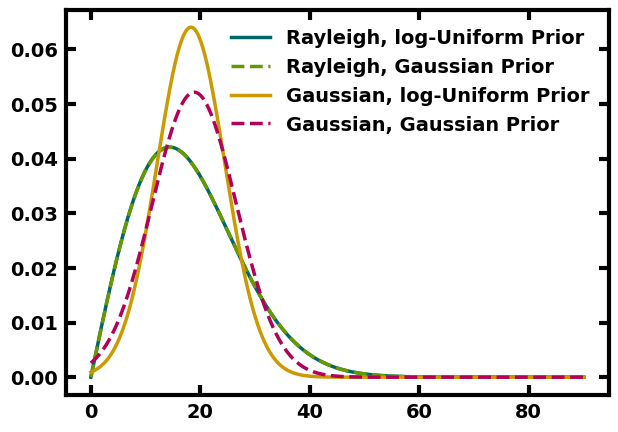

In [458]:
for HBM_key in list(Delta_i_HBM_files.keys()):
    print(HBM_key)
    
    with h5py.File(Delta_i_HBM_files[HBM_key]['File Path'], 'r') as file:
        data_accepted = file['/mcmc/accepted'][()]
        data_chain = file['/mcmc/chain'][()]
        data_logprob = file['/mcmc/log_prob'][()]
    
    data_accepted = [int(bep) for bep in data_accepted]
    x_model = np.linspace(0, 1.001, 1000)
    ivals = x_model*90.
    accepted_models = []

    if 'Rayleigh, ' in HBM_key:
        print('Data Chain Shape: ', data_chain.shape, '\n')
        accepted_chains = data_chain[data_accepted, :, 0]
        for chain_i in range(len(accepted_chains)):
            model_profile = x_model/(np.mean(accepted_chains[chain_i])**2) * np.exp((-x_model**2)/(2*np.mean(accepted_chains[chain_i])**2))
            for beep_i in range(len(model_profile)):
                accepted_models.append(model_profile)

    if 'Gaussian, ' in HBM_key:
        print('Data Chain Shape: ', data_chain.shape, '\n')
        accepted_chains_mu = data_chain[data_accepted, :, 0]
        accepted_chains_sigma = data_chain[data_accepted, :, 1]
        for chain_j in range(len(accepted_chains_mu)):
            model_profile = norm.pdf(x=x_model, loc=np.mean(accepted_chains_mu[chain_j]), scale=np.mean(accepted_chains_sigma[chain_j]))
            for beep_i in range(len(model_profile)):
                accepted_models.append(model_profile)

    rayleighs_transposed = np.transpose(accepted_models)
    mean_profile = []
    for ral_i in range(len(rayleighs_transposed)):
        mean_profile.append(np.mean(rayleighs_transposed[ral_i]))

    mean_profile = mean_profile/(sum(mean_profile) * np.diff(ivals)[0])
    
    Delta_i_HBM_files[HBM_key]['Model Profile'] = mean_profile

    if 'log-Uniform Prior' in HBM_key:
        model_linestyle = '-'
    if 'Gaussian Prior' in HBM_key:
        model_linestyle = '--'

    plt.plot(ivals, mean_profile, linestyle=model_linestyle, label=HBM_key)

    total_area_simp = simps(mean_profile, ivals)
    total_area_trapz = np.trapz(mean_profile, ivals)
    closeness_simp = np.isclose(total_area_simp, 1, atol=1e-2)
    closeness_trapz = np.isclose(total_area_simp, 1, atol=1e-2)
    print('Area under KDE (Simpson): ', total_area_simp.round(4), 'Close enough to 1: ', closeness_simp)
    print('Area under KDE (Trapz): ', total_area_trapz.round(4), 'Close enough to 1: ', closeness_trapz)
    print('\n\n')

plt.legend(loc='upper right')
plt.show()

In [459]:
# Posteriors = pd.read_csv(distribution_dir + 'Prob_CXTau.csv')
# Posteriors.columns
# x_grid = np.array(Posteriors['i (deg)'].values).reshape(-1, 1)
# P_Delta_i = np.array(Posteriors['P(Delta i | i)'].values)


In [478]:
# ------------------ DETERMINE X_GRID ------------------ #
Posteriors = pd.read_csv(distribution_dir + 'Prob_CXTau.csv')
posterior_i_values = Posteriors['i (deg)'].values
x_grid = np.array(posterior_i_values).reshape(-1, 1)

reverse_posterior_i_values = -posterior_i_values[::-1][:-1]
all_posterior_i_values = np.concatenate((np.array(reverse_posterior_i_values), np.array(posterior_i_values)))
x_grid_all = np.array(all_posterior_i_values).reshape(-1, 1)



compute_new_KDE = True
KDE_filepath_stassun = primordial_disks_sample_directory + 'KDE_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_' + date_str + '.csv'
KDE_filepath_all = primordial_disks_sample_directory + 'KDE_' + resolution_text + '_' + Rshift_text + '_' + Pshift_text + '_all_' + date_str + '.csv'
band_width_MAPs = 5

if compute_new_KDE == True:

    kde_n_draws = int(1e4)
    do_scotts_rule = False

    # ------------------ COMPUTE KDE FROM DRAWS ------------------ #
    data_for_kde = []
    for targetnum in range(len(condensed_df_stassun['Simbad Name'].values)):

        target_str = condensed_df_stassun['Simbad Name'][targetnum].replace(' ', '')
        if '/' in condensed_df_stassun['Simbad Name'][targetnum]:
            target_str = target_str.replace('/', '-')

        Posteriors = pd.read_csv(distribution_dir + 'Prob_' + target_str + '.csv')
        P_Delta_i_target = np.array(Posteriors['P(Delta i | i)'].values)
        data_for_kde.extend(choices(x_grid, P_Delta_i_target, k=kde_n_draws))
    data_for_kde_MAPs = np.array(condensed_df_stassun['disk diff'].values).reshape(-1, 1)

    if do_scotts_rule == True:
        n = len(condensed_df_stassun['disk diff'].values)  # len(data_for_kde)
        d = 1
        band_width = n**(-1./(d+4)) # Scotts Rule
    else:
        band_width = bandwidth_master  # 3
    print('KDE Bandwidth = ', band_width)

    data_for_kde = np.array(data_for_kde).reshape(-1, 1)

    kde = KernelDensity(kernel='gaussian', bandwidth=band_width).fit(data_for_kde)
    kde_MAPs = KernelDensity(kernel='gaussian', bandwidth=band_width_MAPs).fit(data_for_kde_MAPs)
    log_density = kde.score_samples(x_grid_all)
    log_density_MAPs = kde_MAPs.score_samples(x_grid_all)

    density_estimation = np.array(np.exp(log_density))
    density_estimation_MAPs = np.array(np.exp(log_density_MAPs))

    density_estimation_mirrored = density_estimation[::-1]
    density_estimation_mirrored_MAPs = density_estimation_MAPs[::-1]

    density_estimation_total = density_estimation + density_estimation_mirrored
    density_estimation_total_MAPs = density_estimation_MAPs + density_estimation_mirrored_MAPs

    KDE_dict = {'density_estimation': density_estimation,
                'density_estimation_mirrored': density_estimation_mirrored,
                'density_estimation_total': density_estimation_total,
                'kde_n_draws': [kde_n_draws]*len(density_estimation),
                'band_width': [band_width]*len(density_estimation),
                }
    KDE_df = pd.DataFrame(KDE_dict)
    KDE_df.to_csv(KDE_filepath_stassun, index=False)

    # ------------ ALL RADII ------------ #
    if do_all_radii == True:
        data_for_kde_all = []
        for targetnum in range(len(condensed_df_all['Simbad Name'].values)):

            target_str = condensed_df_all['Simbad Name'][targetnum].replace(' ', '')
            if '/' in condensed_df_all['Simbad Name'][targetnum]:
                target_str = target_str.replace('/', '-')

            Posteriors = pd.read_csv(distribution_dir + 'Prob_' + target_str + '.csv')
            P_Delta_i_target = np.array(Posteriors['P(Delta i | i)'].values)
            data_for_kde_all.extend(choices(x_grid, P_Delta_i_target, k=kde_n_draws))
        data_for_kde_MAPs_all = np.array(condensed_df_all['disk diff'].values).reshape(-1, 1)

        data_for_kde_all = np.array(data_for_kde_all).reshape(-1, 1)

        kde_all = KernelDensity(kernel='gaussian', bandwidth=band_width).fit(data_for_kde_all)
        kde_MAPs_all = KernelDensity(kernel='gaussian', bandwidth=band_width_MAPs).fit(data_for_kde_MAPs_all)
        log_density_all = kde_all.score_samples(x_grid_all)
        log_density_MAPs_all = kde_MAPs_all.score_samples(x_grid_all)

        density_estimation_all = np.array(np.exp(log_density_all))
        density_estimation_MAPs_all = np.array(np.exp(log_density_MAPs_all))

        density_estimation_mirrored_all = density_estimation_all[::-1]
        density_estimation_mirrored_MAPs_all = density_estimation_MAPs_all[::-1]

        density_estimation_total_all = density_estimation_all + density_estimation_mirrored_all
        density_estimation_total_MAPs_all = density_estimation_MAPs_all + density_estimation_mirrored_MAPs_all

        KDE_dict_all = {'density_estimation': density_estimation_all,
                        'density_estimation_mirrored': density_estimation_mirrored_all,
                        'density_estimation_total': density_estimation_total_all,
                        'kde_n_draws': [kde_n_draws]*len(density_estimation_all),
                        'band_width': [band_width]*len(density_estimation_all),
                        }
        KDE_df_all = pd.DataFrame(KDE_dict_all)
        KDE_df_all.to_csv(KDE_filepath_all, index=False)
    

else:
    # ------------------ READ IN KDE FROM DRAWS ------------------ #
    KDE_df = pd.read_csv(KDE_filepath_stassun)
    density_estimation = KDE_df['density_estimation'].values
    density_estimation_mirrored = KDE_df['density_estimation_mirrored'].values
    density_estimation_total = KDE_df['density_estimation_total'].values
    kde_n_draws = KDE_df['kde_n_draws'].values[0]
    band_width = KDE_df['band_width'].values[0]
    print('KDE Bandwidth = ', band_width)

    # ------------------ COMPUTE KDE FOR MAP VALUES ------------------ #
    data_for_kde_MAPs = np.array(condensed_df_stassun['disk diff'].values).reshape(-1, 1)
    kde_MAPs = KernelDensity(kernel='gaussian', bandwidth=band_width_MAPs).fit(data_for_kde_MAPs)
    log_density_MAPs = kde_MAPs.score_samples(x_grid_all)
    density_estimation_MAPs = np.array(np.exp(log_density_MAPs))
    density_estimation_mirrored_MAPs = density_estimation_MAPs[::-1]
    density_estimation_total_MAPs = density_estimation_MAPs + density_estimation_mirrored_MAPs

density_estimation_total_positive_x = density_estimation_total[x_grid_all[:, 0] >= 0]
density_estimation_total_positive_x_MAPs = density_estimation_total_MAPs[x_grid_all[:, 0] >= 0]

# density_estimation_total_positive_x = density_estimation[x_grid_all[:, 0] >= 0]
# density_estimation_total_positive_x_MAPs = density_estimation_MAPs[x_grid_all[:, 0] >= 0]
# density_estimation_total_positive_x = density_estimation_total_positive_x / (sum(density_estimation_total_positive_x)*np.diff(x_grid[:, 0])[0])
# density_estimation_total_positive_x_MAPs = density_estimation_total_positive_x_MAPs / (sum(density_estimation_total_positive_x_MAPs)*np.diff(x_grid[:, 0])[0])

KDE Bandwidth =  1.990098759665594


In [479]:
plot_mirror_tests = False
if plot_mirror_tests == True:

    plt.fill_between(x_grid_all[:, 0], density_estimation, alpha=0.44, zorder=0)
    plt.fill_between(x_grid_all[:, 0], density_estimation_mirrored, alpha=0.44, zorder=0)
    plt.plot(x_grid_all[:, 0], density_estimation_total, color='#000000', lw=2.5, alpha=0.44, zorder=1)
    plt.plot(x_grid[:, 0], density_estimation_total_positive_x, color='#000000', lw=3.5, alpha=1, zorder=1)
    plt.plot([0, 0], [0, density_estimation_total_positive_x[0]], color='#000000', lw=3.5, alpha=1, zorder=1)
    plt.xlim(min(x_grid_all[:, 0]), max(x_grid_all[:, 0]))
    plt.ylim(0, 0.042)
    plt.show()

    plt.fill_between(x_grid_all[:, 0], density_estimation_MAPs, alpha=0.44, zorder=0)
    plt.fill_between(x_grid_all[:, 0], density_estimation_mirrored_MAPs, alpha=0.44, zorder=0)
    plt.plot(x_grid_all[:, 0], density_estimation_total_MAPs, color='#000000', lw=2.5, alpha=0.44, zorder=1)
    plt.plot(x_grid[:, 0], density_estimation_total_positive_x_MAPs, color='#000000', lw=3.5, alpha=1, zorder=1)
    plt.plot([0, 0], [0, density_estimation_total_positive_x_MAPs[0]], color='#000000', lw=3.5, alpha=1, zorder=1)
    plt.xlim(min(x_grid_all[:, 0]), max(x_grid_all[:, 0]))
    plt.ylim(0, 0.045)
    plt.show()

    plt.plot(x_grid[:, 0], density_estimation_total_positive_x, color='#000000', lw=2.5, alpha = 0.44, label='Draws (BW = ' + str(band_width) + ')', zorder=2)
    plt.plot(x_grid[:, 0], density_estimation_total_positive_x_MAPs, lw=2.5, alpha = 0.44, label='MAPs (BW = ' + str(band_width_MAPs) + ')', zorder=2)
    plt.xlim(0, max(x_grid_all[:, 0]))
    plt.ylim(0, 0.05)
    plt.legend(loc='upper right')
    plt.show()

    use_MAP_KDE = False
    if use_MAP_KDE == True:
        density_estimation_total_positive_x = density_estimation_total_positive_x_MAPs

    total_area_simp = simps(density_estimation_total_positive_x, x_grid[:, 0])
    total_area_trapz = np.trapz(density_estimation_total_positive_x, x_grid[:, 0])
    closeness_simp = np.isclose(total_area_simp, 1, atol=1e-2)
    closeness_trapz = np.isclose(total_area_simp, 1, atol=1e-2)
    print('Area under KDE (Simpson): ', total_area_simp.round(4), 'Close enough to 1: ', closeness_simp)
    print('Area under KDE (Trapz)): ', total_area_trapz.round(4), 'Close enough to 1: ', closeness_trapz)

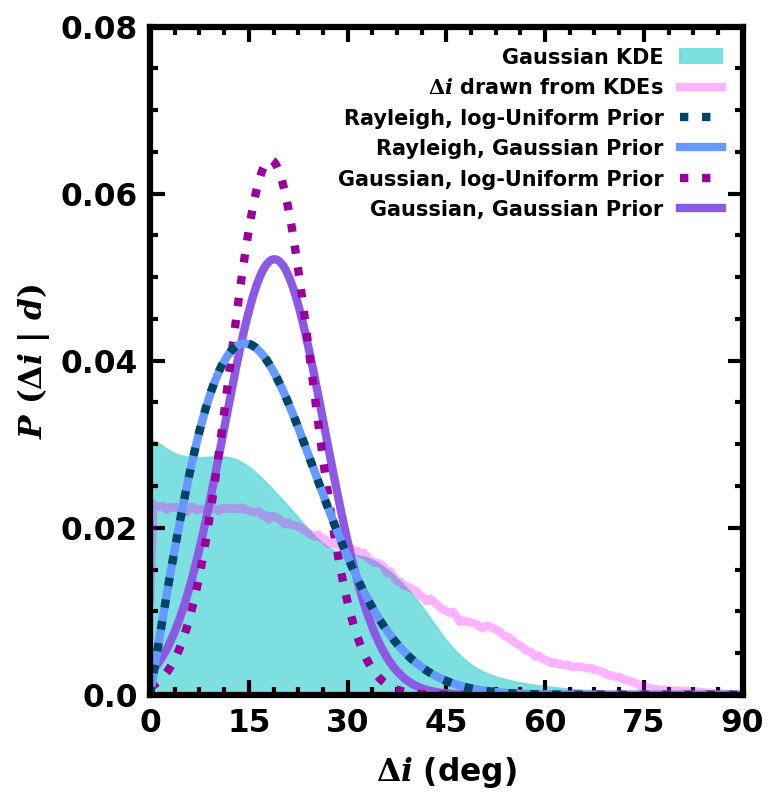

In [480]:

fig = plt.figure(figsize=(5, 5.5), dpi=150)
ax = fig.add_subplot(111)

ax.minorticks_on()

Delta_i_hist_fontsize = 15

ax.set_xlabel(r'$\Delta i$ (deg)', fontsize=Delta_i_hist_fontsize, labelpad=8)
ax.set_ylabel(r'$P$ $(\Delta i$ | $d)$', fontsize=Delta_i_hist_fontsize)


ax.fill_between(x_grid[:, 0], density_estimation_total_positive_x, color=kde_color, alpha=0.9, label='Gaussian KDE', zorder=1)

ax.plot(x_grid_plot[:-1], i_diff_dist_from_kde,lw=4, linestyle='-', color='magenta', alpha=0.3, label=r'$\Delta i$ drawn from KDEs', zorder=model_zorder)


# for targetnum in range(len(condensed_df_stassun['Simbad Name'].values)):

#     target_str = condensed_df_stassun['Simbad Name'][targetnum].replace(' ', '')
#     if '/' in condensed_df_stassun['Simbad Name'][targetnum]:
#         target_str = target_str.replace('/', '-')

#     Posteriors = pd.read_csv(distribution_dir + 'Prob_' + target_str + '.csv')
#     P_Delta_i_target = np.array(Posteriors['P(Delta i | i)'].values)
#     # if targetnum == 0:
#     #     ax_twin.plot(x_grid, P_Delta_i_target, color='#336699', alpha=0.3, zorder=2, label='Sample Posteriors')
#     # else:
    
#     if targetnum == 0:
#         ax.plot(x_grid, 0.01*P_Delta_i_target/max(P_Delta_i_target), color='#3333ff', lw=1.5, alpha=0.2, zorder=2, label=r'$\Delta i$ Posteriors')
#     else:
#         ax.plot(x_grid, 0.01*P_Delta_i_target/max(P_Delta_i_target), color='#3333ff', lw=1.5, alpha=0.2, zorder=2)

for HBM_key in list(Delta_i_HBM_files.keys()):
    model_profile = Delta_i_HBM_files[HBM_key]['Model Profile']
    if HBM_key == 'Rayleigh, log-Uniform Prior':
        model_linestyle = ':'
        model_color = '#004466'  # '#002b80'
        model_zorder = 6
    if HBM_key == 'Rayleigh, Gaussian Prior':
        model_linestyle = '-'
        model_color = '#6699ff'  # '#33cccc'  # '#0099cc'
        model_zorder = 5
    if HBM_key == 'Gaussian, log-Uniform Prior':
        model_linestyle = ':'
        model_color = '#990099'  # '#621068'  # '#4d004d'
        model_zorder = 4
    if HBM_key == 'Gaussian, Gaussian Prior':
        model_linestyle = '-'
        model_color = '#8c59e4'  # '#bf00ff'
        model_zorder = 3


    # ax_twin.plot(ivals, model_profile, lw=4, linestyle=model_linestyle, color=model_color, label=HBM_key, zorder=model_zorder)
    ax.plot(ivals, model_profile, lw=4, linestyle=model_linestyle, color=model_color, label=HBM_key, zorder=model_zorder)


# ax.set_ylim(0, 12)

xticks_hist = np.arange(0, 105, 15)
ax.set_xticks(xticks_hist)
ax.set_xticklabels(xticks_hist)
ax.set_xlim(0, 90)

yticks_hist = np.arange(0, 0.0925 + 0.02, 0.02)
ax.set_yticks(yticks_hist)
ax.set_yticklabels(yticks_hist)
ax.set_ylim(0, 0.08)  # 1.2*max(density_estimation))
# ax_twin.set_ylim(0, 8)

ax.legend(loc='upper right', prop={'size': 10}, ncol=1, markerfirst=False)  # , bbox_to_anchor=(0.24, 0.90, 0.5, 0.10))  # , bbox_to_anchor=(0., 0.5, 0.5, 0.35))
# ax_twin.legend(loc='upper right', prop={'size': 12}, ncol=1, bbox_to_anchor=(0.50, 0.53, 0.5, 0.40))

for spine in ax.spines.values():
    spine.set_zorder(100)

ax.tick_params(which='minor', length=4, width=2, labelsize=Delta_i_hist_fontsize)
ax.tick_params(which='major', length=7, width=2, labelsize=Delta_i_hist_fontsize)

# fig.subplots_adjust(left=0.16, bottom=0.10, right=0.93, top=0.975, wspace=0.12, hspace=0.35)
fig.subplots_adjust(left=0.18, bottom=0.12, right=0.97, top=0.93, wspace=0.12, hspace=0.35)


if do_all_radii == False:
    save_hist_string = 'Delta_i_Histogram_' + resolution_text + '_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text + '_'  + date_str + '.pdf'
else:
    save_hist_string = 'Delta_i_Histogram_' + resolution_text + '_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text + '_all_'  + date_str + '.pdf'

if plot_transparent == True:
    fig.savefig(test_figures_directory + save_hist_string, dpi=300, transparent=True)
else:
    fig.savefig(test_figures_directory + save_hist_string, dpi=300, transparent=False)

plt.show()


In [466]:
condensed_df_stassun.columns

Index(['Target', 'Simbad Name', 'RA', 'DEC', 'SpType', 'SpType Unc',
       'i pp disk (deg)', 'i pp disk Unc', 'Rstar (Rsun)', 'Rstar Unc',
       'Mstar (Msun)', 'Mstar Unc', 'Prot (d)', 'Prot Unc', 'vsini (km/s)',
       'vsini Unc', 'Teff (K)', 'Teff Unc', 'Age (Myr)', 'Age Unc',
       'i star (deg)', 'i star +Unc', 'i star -Unc', 'disk diff',
       'disk diff +Unc', 'disk diff -Unc', 'Veq', 'Veq Unc'],
      dtype='object')

[ 9.90942387 24.10394277 18.74478908 15.22394235 13.43633628 10.05223804
 60.76927122 21.60521606 16.66646406 14.22729572 12.57796088 32.08976531
  8.18605261 33.34404702 13.78404399 14.0928996  10.85037455 16.86607468
 13.11651401 12.70551286 15.37919777 13.4768929  26.27003729 21.61524594
 20.57725016 22.64684118 16.78849513 20.52899495 24.0094865  11.26297442
 45.9245744  22.15218478 11.57999656 14.68907868  8.26201305 10.17253359
 11.18350418]


/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_60280/3987153838.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(cbar_ticks, fontsize=16)


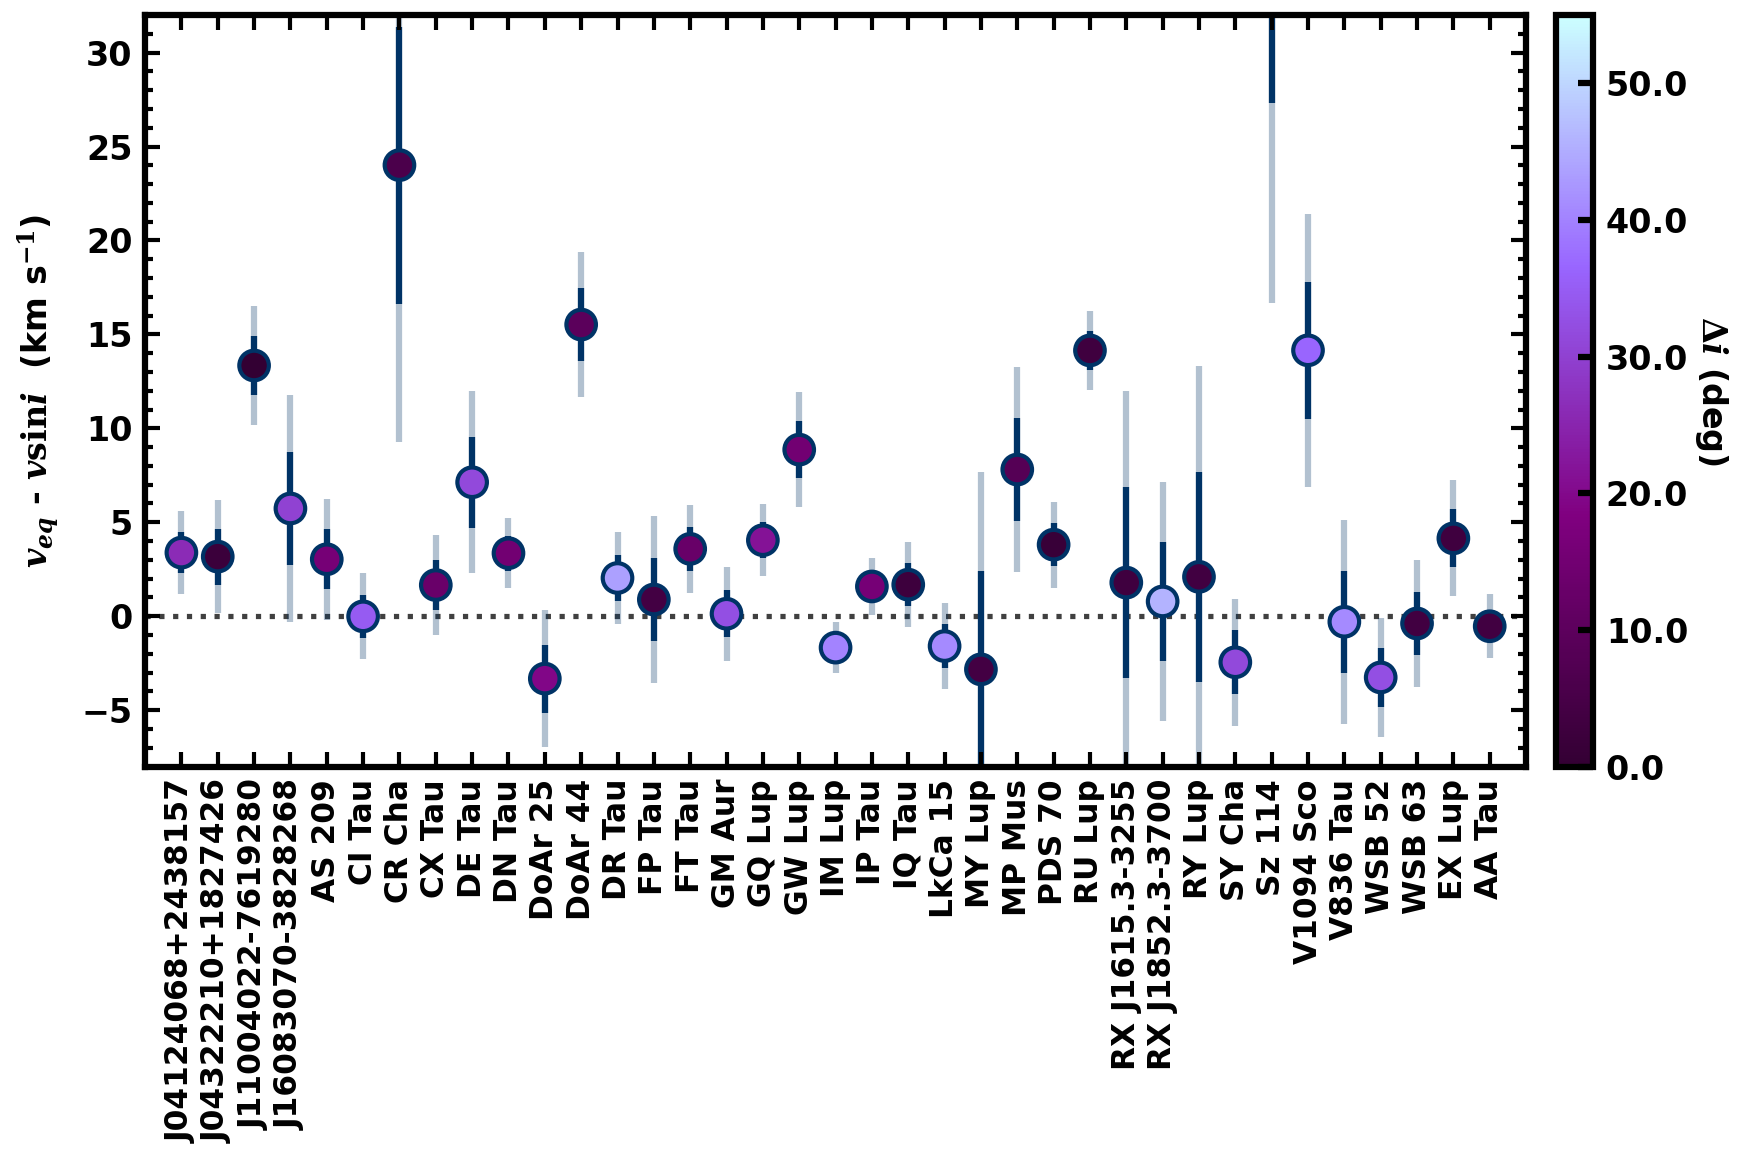

In [467]:
x_spacing = 0.5
point_size = 8
ymin, ymax = -8, 32  # 57.5

veq_vsini_figwidth, veq_vsini_figheight = 12, 8



# ------------------------- STASSUN RADII -------------------------- # 

vsinis_stassun = np.array(condensed_df_stassun['vsini (km/s)'].values)
vsini_errs_stassun = np.array(condensed_df_stassun['vsini Unc'].values)
veqs_stassun = np.array(condensed_df_stassun['Veq'].values)
veq_errs_stassun = np.array(condensed_df_stassun['Veq Unc'].values)
masses_stassun = np.array(condensed_df_stassun['Mstar (Msun)'].values)
masses_err_stassun = np.array(condensed_df_stassun['Mstar Unc'].values)
radii_stassun = np.array(condensed_df_stassun['Rstar (Rsun)'].values)
radii_err_stassun = np.array(condensed_df_stassun['Rstar Unc'].values)

vlimit_stassun = np.sqrt((6.674e-20 * masses_stassun * 1.989e30) / (radii_stassun * 6.96e5))
# print(vlimit_stassun)

# for vsini_err_i in range(len(vsini_errs_stassun)):
#     if vsini_errs_stassun[vsini_err_i] == 'ulimit':
#         vsini_errs_stassun[vsini_err_i] = 0.00000

veqs_minus_vsinis_stassun = veqs_stassun - vsinis_stassun
veqs_minus_vsinis_err_stassun_1sig = []
veqs_minus_vsinis_err_stassun_2sig = []
for vsini_err_i in range(len(vsinis_stassun)):
    veqs_minus_vsinis_err_stassun_1sig.append(np.sqrt(float(vsini_errs_stassun[vsini_err_i])**2 + veq_errs_stassun[vsini_err_i]**2))
    veqs_minus_vsinis_err_stassun_2sig.append(2*np.sqrt(float(vsini_errs_stassun[vsini_err_i])**2 + veq_errs_stassun[vsini_err_i]**2))

print(veqs_stassun)

x_array = np.arange(0, x_spacing*len(veqs_minus_vsinis_stassun), x_spacing)

if len(vsinis_stassun) > 1:

    colormap = choose_cmap('cyber grape', reverse_cmap=False)
    max_cbar_limit = 55  # 
    parameter_z_norm = plt.Normalize(0, max_cbar_limit)
    point_colors = [colormap(parameter_z_norm(bep)) for bep in condensed_df_stassun['disk diff'].values]


    fig4 = plt.figure(figsize=(veq_vsini_figwidth, veq_vsini_figheight), dpi=150)
    ax = fig4.add_subplot(111)
    # ax.set_title(r'$v_{eq}$ - $v\mathrm{sin}i$')
    ax.set_ylabel(r'$v_{eq}$ - $v\mathrm{sin}i$  (km s$^{-1}$)', fontsize=16, labelpad=10)

    where_ymin = np.where(veqs_minus_vsinis_stassun == min(veqs_minus_vsinis_stassun))[0]
    where_ymax = np.where(veqs_minus_vsinis_stassun == max(veqs_minus_vsinis_stassun))[0]

    xmin, xmax = min(x_array) - x_spacing, max(x_array) + x_spacing
    # ymin, ymax =  min(veqs_minus_vsinis_stassun) - 0.15*(max(veqs_minus_vsinis_stassun) - min(veqs_minus_vsinis_stassun)), max(veqs_minus_vsinis_stassun) + 0.15*(max(veqs_minus_vsinis_stassun) - min(veqs_minus_vsinis_stassun))
    
    ax.plot([xmin, xmax], [0, 0], linestyle=':', color=zeroline_color, lw=2.5, alpha=1., zorder=-3)
    ax.scatter(x_array, veqs_minus_vsinis_stassun, edgecolors=point_color, linewidth=2, s=np.pi*point_size**2, color=point_colors, linestyle='None')
    ax.errorbar(x_array, veqs_minus_vsinis_stassun, yerr=veqs_minus_vsinis_err_stassun_1sig, elinewidth=3, linewidth=0, capsize=0, ecolor=point_color, capthick=12, zorder=-1)
    ax.errorbar(x_array, veqs_minus_vsinis_stassun, yerr=veqs_minus_vsinis_err_stassun_2sig, elinewidth=3, linewidth=0, capsize=0, ecolor=point_color, capthick=12, alpha=0.3, zorder=-2)

    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=parameter_z_norm, cmap=colormap), ax=ax, use_gridspec=True, shrink=1., fraction=0.05, pad=0.02)  # location='top', 
    cbar.set_label(r'$\Delta i$ (deg)', labelpad=20, rotation=270, fontsize=16, weight='bold')
    cbar_ticks = cbar.get_ticks()  # np.arange(0, 105, 15)
    # cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks, fontsize=16)

    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', length=4, width=2)
    ax.tick_params(axis='x', which='minor', length=0, width=0)
    ax.tick_params(which='major', length=7, width=2, labelsize=16)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)  # ymin,  ymax)

    # test_targs = condensed_df_stassun['Simbad Name'].values
    xlabels = [targ_label.replace('2MASS ', '') for targ_label in condensed_df_stassun['Simbad Name'].values]
    ax.set_xticks(x_array)
    xticklabels = ax.set_xticklabels(xlabels, fontsize=15, rotation=90)

    fig4.tight_layout()

    ax.set_rasterized(True)


    save_veq_vsini_string = 'veq_vsini_' + resolution_text + '_' +  light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text + '_'  + date_str + '.pdf'

    if plot_transparent == True:
        fig4.savefig(test_figures_directory + save_veq_vsini_string, dpi=300, transparent=True)
    else:
        fig4.savefig(test_figures_directory + save_veq_vsini_string, dpi=300, transparent=False)


    plt.show()



# # ------------------------- ALL RADII -------------------------- # 
ymin, ymax = -8, 40  # 57.5

if do_all_radii == True:
    vsinis_all = np.array(condensed_df_all['vsini (km/s)'].values)
    vsini_errs_all = np.array(condensed_df_all['vsini Unc'].values)
    veqs_all = np.array(condensed_df_all['Veq'].values)
    veq_errs_all = np.array(condensed_df_all['Veq Unc'].values)
    masses_all = np.array(condensed_df_all['Mstar (Msun)'].values)
    masses_err_all = np.array(condensed_df_all['Mstar Unc'].values)
    radii_all = np.array(condensed_df_all['Rstar (Rsun)'].values)
    radii_err_all = np.array(condensed_df_all['Rstar Unc'].values)

    vlimit_all = np.sqrt((6.674e-20 * masses_all * 1.989e30) / (radii_all * 6.96e5))

    # for vsini_err_i in range(len(vsini_errs_all)):
    #     if vsini_errs_all[vsini_err_i] == 'ulimit':
    #         vsini_errs_all[vsini_err_i] = 0.00000

    veqs_minus_vsinis_all = veqs_all - vsinis_all
    veqs_minus_vsinis_err_all_1sig = []
    veqs_minus_vsinis_err_all_2sig = []
    for vsini_err_i in range(len(vsinis_all)):
        veqs_minus_vsinis_err_all_1sig.append(np.sqrt(float(vsini_errs_all[vsini_err_i])**2 + veq_errs_all[vsini_err_i]**2))
        veqs_minus_vsinis_err_all_2sig.append(2*np.sqrt(float(vsini_errs_all[vsini_err_i])**2 + veq_errs_all[vsini_err_i]**2))

    print(veqs_all)

    x_array = np.arange(0, x_spacing*len(veqs_minus_vsinis_all), x_spacing)

    if len(vsinis_all) > 1:

        colormap = choose_cmap('cyber grape', reverse_cmap=False)
        max_cbar_limit = 55  # 
        parameter_z_norm = plt.Normalize(0, max_cbar_limit)
        point_colors = [colormap(parameter_z_norm(bep)) for bep in condensed_df_all['disk diff'].values]


        fig4 = plt.figure(figsize=(veq_vsini_figwidth, veq_vsini_figheight), dpi=150)
        ax = fig4.add_subplot(111)
        # ax.set_title(r'$v_{eq}$ - $v\mathrm{sin}i$')
        ax.set_ylabel(r'$v_{eq}$ - $v\mathrm{sin}i$  (km s$^{-1}$)', fontsize=16, labelpad=10)

        where_ymin = np.where(veqs_minus_vsinis_all == min(veqs_minus_vsinis_all))[0]
        where_ymax = np.where(veqs_minus_vsinis_all == max(veqs_minus_vsinis_all))[0]

        xmin, xmax = min(x_array) - x_spacing, max(x_array) + x_spacing
        
        ax.plot([xmin, xmax], [0, 0], linestyle=':', color=zeroline_color, lw=2.5, alpha=1., zorder=-3)
        ax.scatter(x_array, veqs_minus_vsinis_all, edgecolors=point_color, linewidth=2, s=np.pi*point_size**2, color=point_colors, linestyle='None')
        ax.errorbar(x_array, veqs_minus_vsinis_all, yerr=veqs_minus_vsinis_err_all_1sig, elinewidth=3, linewidth=0, capsize=0, ecolor=point_color, capthick=12, zorder=-1)
        ax.errorbar(x_array, veqs_minus_vsinis_all, yerr=veqs_minus_vsinis_err_all_2sig, elinewidth=3, linewidth=0, capsize=0, ecolor=point_color, capthick=12, alpha=0.3, zorder=-2)

        cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=parameter_z_norm, cmap=colormap), ax=ax, use_gridspec=True, shrink=1., fraction=0.05, pad=0.02)  # location='top', 
        cbar.set_label(r'$\Delta i$ (deg)', labelpad=20, rotation=270, fontsize=16, weight='bold')
        cbar_ticks = cbar.get_ticks()  # np.arange(0, 105, 15)
        # cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticks, fontsize=16)

        ax.minorticks_on()
        ax.tick_params(axis='y', which='minor', length=4, width=2)
        ax.tick_params(axis='x', which='minor', length=0, width=0)
        ax.tick_params(which='major', length=7, width=2, labelsize=16)

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)  # ymin,  ymax)

        # test_targs = condensed_df_all['Simbad Name'].values
        xlabels = [targ_label.replace('2MASS ', '') for targ_label in condensed_df_all['Simbad Name'].values]
        ax.set_xticks(x_array)
        xticklabels = ax.set_xticklabels(xlabels, fontsize=15, rotation=90)

        fig4.tight_layout()

        ax.set_rasterized(True)


        save_veq_vsini_string = 'veq_vsini_' + resolution_text + '_' +  light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text + '_all_'  + date_str + '.pdf'

        if plot_transparent == True:
            fig4.savefig(test_figures_directory + save_veq_vsini_string, dpi=300, transparent=True)
        else:
            fig4.savefig(test_figures_directory + save_veq_vsini_string, dpi=300, transparent=False)


        plt.show()


/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_60280/1018601544.py:499: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(cbar_ticks, fontsize=parplot_fontsize)


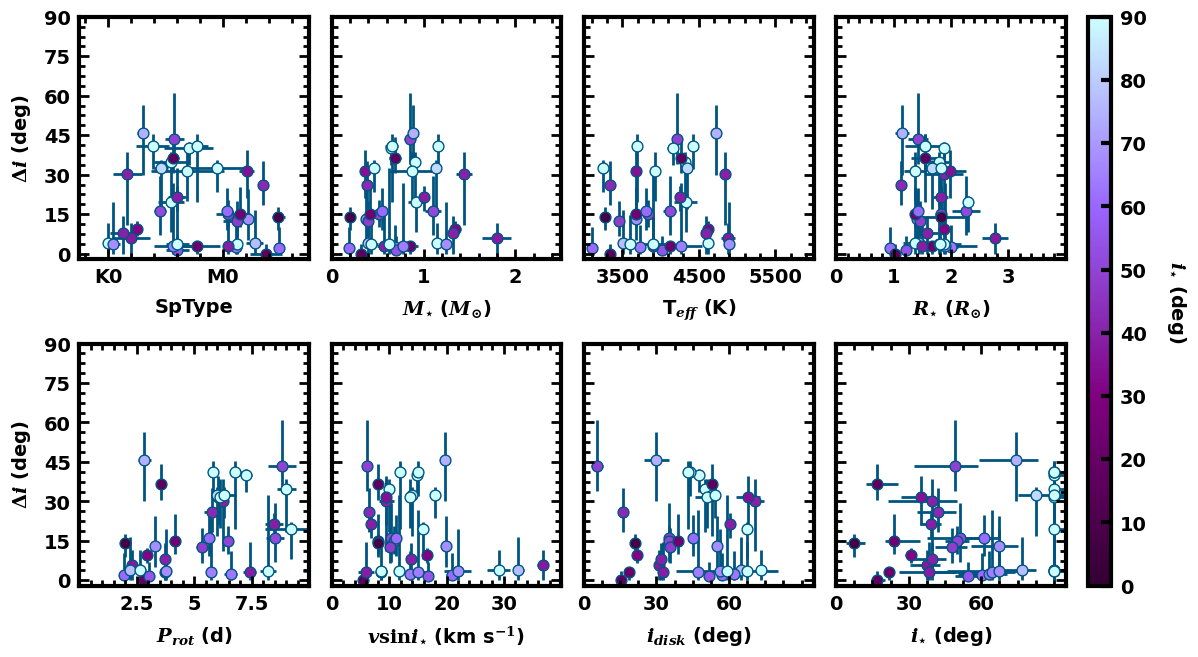

In [468]:
parplot_fontsize = 14
parplot_title_fontsize = 14
# parplot_color = '#958bda'  # '#669999'
# parplot_ylabel = 'Fraction of Sample'
# parplot_linecolor = '#2f0431'


# possible_variables = ['star inclination', 'disk inclination', 'mass', 'Teff', 'SpT', 'disk diff', 'Prot', 'Age', 'vsini', 'radius']


target_labels_on = False

save_figs = True


z_colors_on = True

if z_colors_on == False:
    fig_width = 6
else:
    fig_width = 7
fig_height = 6


# font_size = 15
point_size = 4.4


colormap = choose_cmap('cyber grape', reverse_cmap=False)






x_variations = ['SpT', 'mass','Teff', 'radius', 'Prot', 'vsini', 'disk inclination', 'star inclination']
y_variable = 'disk diff'
z_variable = 'star inclination'


grid_width = 5
grid_height = 2

fig = plt.figure(figsize=(12, 6.5))
gs = gridspec.GridSpec(grid_height , grid_width , width_ratios=[1, 1, 1, 1, 0.10])  # , wspace=0.12, hspace=0.35)
axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width-1)]
ax_keys = list(hists_to_create.keys())

for ax_i, ax in enumerate(axes):

    ax.minorticks_on()

    x_variable = x_variations[ax_i]

    plot_variables = [x_variable, y_variable, z_variable]

    if 'star inclination' in plot_variables:
        axis_bool = [index for index in range(len(plot_variables)) if 'star inclination' in plot_variables[index]][0]
        if axis_bool == 0:
            x_column = 'i star (deg)'
            x_column_err_p = 'i star -Unc'
            x_column_err_m = 'i star +Unc'
            x_label = r'$i_{\mathdefault{\star}}$ (deg)'
            x_text = 'i_Star'
            xlims = [0, 95]
        if axis_bool == 1:
            y_column = 'i star (deg)'
            y_column_err_p = 'i star -Unc'
            y_column_err_m = 'i star +Unc'
            y_label = r'$i_{\mathdefault{\star}}$ (deg)'
            ylims = [0, 95]
            y_text = 'i_Star'
        if axis_bool == 2:
            z_column = 'i star (deg)'
            z_column_err_p = 'i star -Unc'
            z_column_err_m = 'i star +Unc'
            z_label = r'$i_{\mathdefault{\star}}$ (deg)'
            zlims = [0, 90]
            z_text = 'i_Star'
    if 'disk inclination' in plot_variables:
        axis_bool = [index for index in range(len(plot_variables)) if 'disk inclination' in plot_variables[index]][0]
        if axis_bool == 0:
            x_column = 'i pp disk (deg)'
            x_column_err_p = 'i pp disk Unc'
            x_column_err_m = 'i pp disk Unc'
            x_label = r'$i_{disk}$ (deg)'
            xlims = [0, 95]
            x_text = 'i_Disk'
        if axis_bool == 1:
            y_column = 'i pp disk (deg)'
            y_column_err_p = 'i pp disk Unc'
            y_column_err_m = 'i pp disk Unc'
            y_label = r'$i_{disk}$ (deg)'
            ylims = [0, 95]
            y_text = 'i_Disk'
        if axis_bool == 2:
            z_column = 'i pp disk (deg)'
            z_column_err_p = 'i pp disk Unc'
            z_column_err_m = 'i pp disk Unc'
            z_label = r'$i_{disk}$ (deg)'
            zlims = [0, 90]
            z_text = 'i_Disk'
    if 'mass' in plot_variables:
        axis_bool = [index for index in range(len(plot_variables)) if 'mass' in plot_variables[index]][0]
        if axis_bool == 0:
            x_column = 'Mstar (Msun)'
            x_column_err_p = 'Mstar Unc'
            x_column_err_m = 'Mstar Unc'
            x_label = r'$M_{\mathdefault{\star}}$ ($M_{\odot}$)'
            xlims = [0.15, 2]
            x_text = 'Mstar'
        if axis_bool == 1:
            y_column = 'Mstar (Msun)'
            y_column_err_p = 'Mstar Unc'
            y_column_err_m = 'Mstar Unc'
            y_label = r'$M_{\mathdefault{\star}}$ ($M_{\odot}$)'
            ylims = [0.15, 2]
            y_text = 'Mstar'
        if axis_bool == 2:
            z_column = 'Mstar (Msun)'
            z_column_err_p = 'Mstar Unc'
            z_column_err_m = 'Mstar Unc'
            z_label = r'$M_{\mathdefault{\star}}$ ($M_{\odot}$)'
            zlims = [0.15, 2]
            z_text = 'Mstar'
    if 'radius' in plot_variables:
        axis_bool = [index for index in range(len(plot_variables)) if 'radius' in plot_variables[index]][0]
        if axis_bool == 0:
            x_column = 'Rstar (Rsun)'
            x_column_err_p = 'Rstar Unc'
            x_column_err_m = 'Rstar Unc'
            x_label = r'$R_{\mathdefault{\star}}$ ($R_{\odot}$)'
            xlims = [0.5, 4]
            x_text = 'Rstar'
        if axis_bool == 1:
            y_column = 'Rstar (Rsun)'
            y_column_err_p = 'Rstar Unc'
            y_column_err_m = 'Rstar Unc'
            y_label = r'$R_{\mathdefault{\star}}$ ($R_{\odot}$)'
            ylims = [0.5, 4]
            y_text = 'Rstar'
        if axis_bool == 2:
            z_column = 'Rstar (Rsun)'
            z_column_err_p = 'Rstar Unc'
            z_column_err_m = 'Rstar Unc'
            z_label = r'$R_{\mathdefault{\star}}$ ($R_{\odot}$)'
            zlims = [0.5, 4]
            z_text = 'Rstar'
    if 'vsini' in plot_variables:
        vsinis = np.array(condensed_df_stassun['vsini (km/s)'].values)
        vsini_errs = np.array(condensed_df_stassun['vsini Unc'].values)
        veqs = np.array(condensed_df_stassun['Veq'].values)
        veq_errs = np.array(condensed_df_stassun['Veq Unc'].values)

        test_targs = condensed_df_stassun['Target'].values
        
        # for vsini_err_i in range(len(vsini_errs)):
        #     if vsini_errs[vsini_err_i] == 'ulimit':
        #         vsini_errs[vsini_err_i] = 0.000001
        
        axis_bool = [index for index in range(len(plot_variables)) if 'vsini' in plot_variables[index]][0]
        if axis_bool == 0:
            x_column = 'vsini (km/s)'
            x_column_err_p = 'vsini Unc'
            x_column_err_m = 'vsini Unc'
            x_label = r'$v\mathrm{sin}i_{\mathdefault{\star}}$ (km s$^{-1}$)'
            xlims = [0, 40]
            x_text = 'vsini'
        if axis_bool == 1:
            y_column = 'vsini (km/s)'
            y_column_err_p = 'vsini Unc'
            y_column_err_m = 'vsini Unc'
            y_label = r'$v\mathrm{sin}i_{\mathdefault{\star}}$ (km s$^{-1}$)'
            ylims = [0, 40]
            y_text = 'vsini'
        if axis_bool == 2:
            z_column = 'vsini (km/s)'
            z_column_err_p = 'vsini Unc'
            z_column_err_m = 'vsini Unc'
            z_label = r'$v\mathrm{sin}i_{\mathdefault{\star}}$ (km s$^{-1}$)'
            zlims = [0, 40]
            z_text = 'vsini'
    if 'Prot' in plot_variables:
        axis_bool = [index for index in range(len(plot_variables)) if 'Prot' in plot_variables[index]][0]
        if axis_bool == 0:
            x_column = 'Prot (d)'
            x_column_err_p = 'Prot Unc'
            x_column_err_m = 'Prot Unc'
            x_label = r'$P_{rot}$ (d)'
            xlims = [0, 14]
            x_text = 'Prot'
        if axis_bool == 1:
            y_column = 'Prot (d)'
            y_column_err_p = 'Prot Unc'
            y_column_err_m = 'Prot Unc'
            y_label = r'$P_{rot}$ (d)'
            ylims = [0, 14]
            y_text = 'Prot'
        if axis_bool == 2:
            z_column = 'Prot (d)'
            z_column_err_p = 'Prot Unc'
            z_column_err_m = 'Prot Unc'
            z_label = r'$P_{rot}$ (d)'
            zlims = [0, 14]
            z_text = 'Prot'
    if 'Teff' in plot_variables:
        axis_bool = [index for index in range(len(plot_variables)) if 'Teff' in plot_variables[index]][0]
        if axis_bool == 0:
            x_column = 'Teff (K)'
            x_column_err_p = 'Teff Unc'
            x_column_err_m = 'Teff Unc'
            x_label = r'T$_{eff}$ (K)'
            xlims = [3000, 6000]
            x_text = 'Teff'
        if axis_bool == 1:
            y_column = 'Teff (K)'
            y_column_err_p = 'Teff Unc'
            y_column_err_m = 'Teff Unc'
            y_label = r'T$_{eff}$ (K)'
            ylims = [3000, 6000]
            y_text = 'Teff'
        if axis_bool == 2:
            z_column = 'Teff (K)'
            z_column_err_p = 'Teff Unc'
            z_column_err_m = 'Teff Unc'
            z_label = r'T$_{eff}$ (K)'
            zlims = [3000, 6000]
            z_text = 'Teff'

    if 'SpT' in plot_variables:
        axis_bool = [index for index in range(len(plot_variables)) if 'SpT' in plot_variables[index]][0]
        if axis_bool == 0:
            x_column = 'SpType'
            x_column_err_p = 'SpType Unc'
            x_column_err_m = 'SpType Unc'
            x_label = 'SpType'
            xlims = [3.75, 5.75]
            x_text = 'SpT'
        if axis_bool == 1:
            y_column = 'SpType'
            y_column_err_p = 'SpType Unc'
            y_column_err_m = 'SpType Unc'
            y_label = 'SpType'
            ylims = [3.75, 5.75]
            y_text = 'SpT'
        if axis_bool == 2:
            z_column = 'SpType'
            z_column_err_p = 'SpType Unc'
            z_column_err_m = 'SpType Unc'
            z_label = 'SpType'
            zlims = [3.75, 5.75]
            z_text = 'SpT'
    if 'disk diff' in plot_variables:
        axis_bool = [index for index in range(len(plot_variables)) if 'disk diff' in plot_variables[index]]
        for axis_num in axis_bool:
            if axis_num == 0:
                x_column = 'disk diff'
                x_column_err_p = 'disk diff +Unc'
                x_column_err_m = 'disk diff -Unc'
                x_label = r'$\Delta i$ (deg)'
                xlims = [-2, 90]
                x_text = 'Delta_i'
            if axis_num == 1:
                y_column = 'disk diff'
                y_column_err_p = 'disk diff +Unc'
                y_column_err_m = 'disk diff -Unc'
                y_label = r'$\Delta i$ (deg)'
                ylims = [-2, 90]
                y_text = 'Delta_i'
            if axis_num == 2:
                z_column = 'disk diff'
                z_column_err_p = 'disk diff +Unc'
                z_column_err_m = 'disk diff -Unc'
                z_label = r'$\Delta i$ (deg)'
                zlims = [0, 90]
                z_text = 'Delta_i'
    if 'Age' in plot_variables:
        axis_bool = [index for index in range(len(plot_variables)) if 'Age' in plot_variables[index]][0]
        if axis_bool == 0:
            x_column = 'Age (Myr)'
            x_column_err_p = 'Age Unc'
            x_column_err_m = 'Age Unc'
            x_label = 'Age (Myr)'
            xlims = [0, 16]
            x_text = 'Age'
        if axis_bool == 1:
            y_column = 'Age (Myr)'
            y_column_err_p = 'Age Unc'
            y_column_err_m = 'Age Unc'
            y_label = 'Age (Myr)'
            ylims = [0, 16]
            y_text = 'Age'
        if axis_bool == 2:
            z_column = 'Age (Myr)'
            z_column_err_p = 'Age Unc'
            z_column_err_m = 'Age Unc'
            z_label = 'Age (Myr)'
            zlims = [0, 10]  # np.ceil(np.nanmax(condensed_df_stassun[z_column].values))]
            z_text = 'Age'

    map_min = zlims[0]
    map_max = zlims[1]
    parameter_z_norm = plt.Normalize(map_min, map_max)

    # -------------------------- STASSUN RADII PARAMETERS -------------------------- #

    parameter_x_stassun = np.array(condensed_df_stassun[x_column].values)
    parameter_x_err_p_stassun = np.array(condensed_df_stassun[x_column_err_p].values)
    parameter_x_err_m_stassun = np.array(condensed_df_stassun[x_column_err_m].values)
    parameter_y_stassun = np.array(condensed_df_stassun[y_column].values)
    parameter_y_err_p_stassun = np.array(condensed_df_stassun[y_column_err_p].values)
    parameter_y_err_m_stassun = np.array(condensed_df_stassun[y_column_err_m].values)
    parameter_z_stassun = np.array(condensed_df_stassun[z_column].values)
    parameter_z_err_p_stassun = np.array(condensed_df_stassun[z_column_err_p].values)
    parameter_z_err_m_stassun = np.array(condensed_df_stassun[z_column_err_m].values)
    targets_list_stassun = np.array(condensed_df_stassun['Simbad Name'].values)

    parameter_x_err_stassun = [parameter_x_err_m_stassun, parameter_x_err_p_stassun]
    parameter_y_err_stassun = [parameter_y_err_m_stassun, parameter_y_err_p_stassun]
    parameter_z_err_stassun = [parameter_z_err_m_stassun, parameter_z_err_p_stassun]

    # if x_column == 'vsini (km/s)':
    #     for err_i in range(len(parameter_x_err_stassun[0])):
    #         if parameter_x_err_stassun[0][err_i] == 'ulimit':
    #             parameter_x_err_stassun[0][err_i] = 0.000001
    #         if parameter_x_err_stassun[1][err_i] == 'ulimit':
    #             parameter_x_err_stassun[1][err_i] = 0.000001
    # if y_column == 'vsini (km/s)':
    #     for err_i in range(len(parameter_y_err_stassun[0])):
    #         if parameter_y_err_stassun[0][err_i] == 'ulimit':
    #             parameter_y_err_stassun[0][err_i] = 0.000001
    #         if parameter_y_err_stassun[1][err_i] == 'ulimit':
    #             parameter_y_err_stassun[1][err_i] = 0.000001
    # if z_column == 'vsini (km/s)':
    #     for err_i in range(len(parameter_z_err_stassun[0])):
    #         if parameter_z_err_stassun[0][err_i] == 'ulimit':
    #             parameter_z_err_stassun[0][err_i] = 0.000001
    #         if parameter_z_err_stassun[1][err_i] == 'ulimit':
    #             parameter_z_err_stassun[1][err_i] = 0.000001


    # -------------------------- ALL RADII PARAMETERS -------------------------- #
    if do_all_radii == True:
        
        parameter_x_all = np.array(condensed_df_all[x_column].values)
        parameter_x_err_p_all = np.array(condensed_df_all[x_column_err_p].values)
        parameter_x_err_m_all = np.array(condensed_df_all[x_column_err_m].values)
        parameter_y_all = np.array(condensed_df_all[y_column].values)
        parameter_y_err_p_all = np.array(condensed_df_all[y_column_err_p].values)
        parameter_y_err_m_all = np.array(condensed_df_all[y_column_err_m].values)
        parameter_z_all = np.array(condensed_df_all[z_column].values)
        parameter_z_err_p_all = np.array(condensed_df_all[z_column_err_p].values)
        parameter_z_err_m_all = np.array(condensed_df_all[z_column_err_m].values)
        targets_list_all = np.array(condensed_df_all['Simbad Name'].values)

        parameter_x_err_all = [parameter_x_err_m_all, parameter_x_err_p_all]
        parameter_y_err_all = [parameter_y_err_m_all, parameter_y_err_p_all]
        parameter_z_err_all = [parameter_z_err_m_all, parameter_z_err_p_all]

        # if x_column == 'vsini (km/s)':
        #     for err_i in range(len(parameter_x_err_all[0])):
        #         if parameter_x_err_all[0][err_i] == 'ulimit':
        #             parameter_x_err_all[0][err_i] = 0.000001
        #         if parameter_x_err_all[1][err_i] == 'ulimit':
        #             parameter_x_err_all[1][err_i] = 0.000001
        # if y_column == 'vsini (km/s)':
        #     for err_i in range(len(parameter_y_err_all[0])):
        #         if parameter_y_err_all[0][err_i] == 'ulimit':
        #             parameter_y_err_all[0][err_i] = 0.000001
        #         if parameter_y_err_all[1][err_i] == 'ulimit':
        #             parameter_y_err_all[1][err_i] = 0.000001
        # if z_column == 'vsini (km/s)':
        #     for err_i in range(len(parameter_z_err_all[0])):
        #         if parameter_z_err_all[0][err_i] == 'ulimit':
        #             parameter_z_err_all[0][err_i] = 0.000001
        #         if parameter_z_err_all[1][err_i] == 'ulimit':
        #             parameter_z_err_all[1][err_i] = 0.000001



    point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z_stassun]
    point_edgecolors = [edge_color]*len(point_colors)
    if z_colors_on == True:
        point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z_stassun]
    else:
        point_colors = [point_color_no_z]*len(point_colors)


    for par_i in range(len(parameter_y_stassun)):
        ax.scatter([parameter_x_stassun[par_i]], [parameter_y_stassun[par_i]], color=point_colors[par_i], edgecolors=point_edgecolors[par_i], s=np.pi*point_size**2, linestyle='None')
        ax.errorbar([parameter_x_stassun[par_i]], [parameter_y_stassun[par_i]], xerr=[[parameter_x_err_stassun[0][par_i]],[parameter_x_err_stassun[1][par_i]]], yerr=[[parameter_y_err_stassun[0][par_i]], [parameter_y_err_stassun[1][par_i]]],
                    elinewidth=2, linewidth=0, capsize=0, ecolor=point_edgecolors[par_i], capthick=2, zorder=-1)

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    ax.tick_params(which='minor', length=4, width=2, labelsize=parplot_fontsize) # pad=6
    ax.tick_params(which='major', length=7, width=2, labelsize=parplot_fontsize)

    if len(parameter_x_stassun) == 1:
        ax.text(0.10, 0.90, targets_list_stassun[0], horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    else:
        if target_labels_on == True:
            for par_xi, var_x in enumerate(parameter_x_stassun):
                ax.text(parameter_x_stassun[par_xi], parameter_y_stassun[par_xi]+np.random.uniform(0.5, 1.5, 1)[0], targets_list_stassun[par_xi], horizontalalignment='center', verticalalignment='bottom', fontsize=8)  # , transform=ax.transAxes)

    if x_column == 'SpType':
        sptype_designations = {'0': 'B',
                            '0.5': 'B5',
                            '1': 'A0',
                            '1.5': 'A5',
                            '2': 'F0',
                            '2.5': 'F5',
                            '3': 'G0',
                            '3.5': 'G5',
                            '4': 'K0',
                            '4.5': 'K5',
                            '5': 'M0',
                            '5.5': 'M5',
                            }

        # designation_numbers = [0, 1, 2, 3, 4, 5, 6]

        xtickvals = ax.get_xticks()
        xticklabs = []
        xticks = []
        for xtick in xtickvals:
            if xtick < xlims[1]:
                if (np.mod(xtick,1) == 0) and (xtick >= xlims[0]):
                    xticks.append(xtick)
                    xticklabs.append(sptype_designations[str(int(xtick))])
                elif (np.mod(xtick,0.5) == 0) and (xtick >= xlims[0]):
                    xticks.append(xtick)
                    xticklabs.append(sptype_designations['{:.1f}'.format(xtick)])
        ax.set_xticks(xticks)
        xticklabels = ax.set_xticklabels(xticklabs, fontsize=parplot_fontsize)

    if (y_column == 'disk diff') or (y_column == 'i star (deg)') or (y_column == 'i pp disk (deg)'):
        ytickvals = np.arange(0, 105, 15)
        yticks = [int(ytick) for ytick in ytickvals]
        ax.set_yticks(yticks)
        yticklabels = ax.set_yticklabels(yticks, fontsize=parplot_fontsize)

    if (x_column == 'disk diff') or (x_column == 'i star (deg)') or (x_column == 'i pp disk (deg)'):
            xtickvals = np.arange(0, 105, 15)
            xticks = [int(xtick) for xtick in xtickvals]
            ax.set_xticks(xticks)
            xticklabels = ax.set_xticklabels(xticks, fontsize=parplot_fontsize)


    if x_variable == 'mass':
        ax.set_xlim(0, 2.5)
        xtickvals = [0, 1, 2]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if x_variable == 'radius':
        xtickvals = [0, 1, 2, 3]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if x_variable == 'Prot':
        ax.set_xlim(0, 10)
        xtickvals = [2.5, 5, 7.5]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if (x_variable == 'disk inclination') or (x_variable == 'star inclination'):
        xtickvals = [0, 30, 60]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if x_variable == 'vsini':
        xtickvals = [0, 10, 20, 30]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)

    if x_variable == 'Teff':
        xtickvals = [3500, 4500, 5500]
        ax.set_xticks(xtickvals)
        ax.set_xticklabels(xtickvals, fontsize=hist_fontsize)


    ax.set_xlabel(x_label, fontsize=parplot_fontsize, labelpad=8)
    if np.mod(ax_i, grid_width-1) == 0:
        ax.set_ylabel(y_label, fontsize=hist_fontsize, labelpad=8)
    else:
        ax.set_ylabel(' ')
        ax.set_yticklabels([])


if z_colors_on == True:
    # Add a single colorbar
    cbar_ax = fig.add_subplot(gs[:, -1])
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=parameter_z_norm, cmap=colormap), cax=cbar_ax) # , use_gridspec=True, shrink=1., fraction=0.05, pad=0.02)  # location='top', 
    cbar.set_label(z_label, labelpad=30, rotation=270, fontsize=parplot_fontsize, weight='bold')
    cbar_ticks_floats = cbar.get_ticks()
    cbar_ticks = [int(cbar_tick) for cbar_tick in cbar_ticks_floats]
    cbar.set_ticklabels(cbar_ticks, fontsize=parplot_fontsize)



if target_labels_on == True:
    labels_text = 'labeled'
else:
    labels_text = 'unlabeled'


fig.subplots_adjust(left=0.07, bottom=0.10, right=0.93, top=0.975, wspace=0.12, hspace=0.35)

# SAVE THE FIGURE
if save_figs == True:
    if len(parameter_x_stassun) == 1:
        save_par_vs_Delta_i_string = resolution_text + '_' + targets_list_stassun[0] + '_ParGrid_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text  + '_' + date_str + '.pdf'
    if len(parameter_x_stassun) > 1:
        save_par_vs_Delta_i_string = resolution_text + '_ParGrid_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text  + '_' + labels_text + '_' + date_str + '.pdf'

    if plot_transparent == True:
        fig.savefig(test_figures_directory + save_par_vs_Delta_i_string, dpi=300, transparent=True)
    else:
        fig.savefig(test_figures_directory + save_par_vs_Delta_i_string, dpi=300, transparent=False)

    plt.show()



# # -------------------------- ALL RADII -------------------------- #
# if do_all_radii == True:
#     print('len all: ', len(parameter_x_all))

#     fig2 = plt.figure(figsize=(fig_width,fig_height), dpi=150)
#     ax = fig2.add_subplot(111)
#     ax.set_title('Computed with All Radii')
#     ax.set_xlabel(x_label, fontsize=parplot_fontsize, labelpad=10)
#     ax.set_ylabel(y_label, fontsize=parplot_fontsize, labelpad=6)

#     point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z_all]
#     point_edgecolors = [edge_color]*len(point_colors)
#     if z_colors_on == True:
#         point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z_all]
#     else:
#         point_colors = [point_color_no_z]*len(point_colors)

#     for par_i in range(len(parameter_y_all)):
#         ax.scatter([parameter_x_all[par_i]], [parameter_y_all[par_i]], color=point_colors[par_i], edgecolors=point_edgecolors[par_i], s=np.pi*point_size**2, linestyle='None')
#         ax.errorbar([parameter_x_all[par_i]], [parameter_y_all[par_i]], xerr=[[parameter_x_err_all[0][par_i]],[parameter_x_err_all[1][par_i]]], yerr=[[parameter_y_err_all[0][par_i]], [parameter_y_err_all[1][par_i]]],
#                     elinewidth=2, linewidth=0, capsize=0, ecolor=point_edgecolors[par_i], capthick=2, zorder=-1)
#     if z_colors_on == True:
#         cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=parameter_z_norm, cmap=colormap), ax=ax, use_gridspec=True, shrink=1., fraction=0.05, pad=0.02)  # location='top', 
#         cbar.set_label(z_label, labelpad=20, rotation=270, fontsize=parplot_fontsize, weight='bold')

#     ax.set_xlim(xlims)
#     ax.set_ylim(ylims)

#     ax.minorticks_on()
#     ax.tick_params(which='minor', length=4, width=2)
#     ax.tick_params(which='major', length=7, width=2)

#     if len(parameter_x_all) == 1:
#         ax.text(0.10, 0.90, targets_list_all[0], horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
#     else:
#         if target_labels_on == True:
#             for par_xi, var_x in enumerate(parameter_x_all):
#                 ax.text(parameter_x_all[par_xi], parameter_y_all[par_xi]+np.random.uniform(0.5, 1.5, 1)[0], targets_list_all[par_xi], horizontalalignment='center', verticalalignment='bottom', fontsize=8)  # , transform=ax.transAxes)

#     if x_column == 'SpType':
#         sptype_designations = {'0': 'B',
#                             '0.5': 'B5',
#                             '1': 'A0',
#                             '1.5': 'A5',
#                             '2': 'F0',
#                             '2.5': 'F5',
#                             '3': 'G0',
#                             '3.5': 'G5',
#                             '4': 'K0',
#                             '4.5': 'K5',
#                             '5': 'M0',
#                             '5.5': 'M5',
#                             }

#         # designation_numbers = [0, 1, 2, 3, 4, 5, 6]

#         xtickvals = ax.get_xticks()
#         xticklabs = []
#         xticks = []
#         for xtick in xtickvals:
#             if xtick < xlims[1]:
#                 if (np.mod(xtick,1) == 0) and (xtick >= xlims[0]):
#                     xticks.append(xtick)
#                     xticklabs.append(sptype_designations[str(int(xtick))])
#                 elif (np.mod(xtick,0.5) == 0) and (xtick >= xlims[0]):
#                     xticks.append(xtick)
#                     xticklabs.append(sptype_designations['{:.1f}'.format(xtick)])
#         ax.set_xticks(xticks)
#         xticklabels = ax.set_xticklabels(xticklabs, fontsize=parplot_fontsize)

#     if (y_column == 'disk diff') or (y_column == 'i star (deg)') or (y_column == 'i pp disk (deg)'):
#         ytickvals = np.arange(0, 105, 15)
#         yticks = [int(ytick) for ytick in ytickvals]
#         ax.set_yticks(yticks)
#         yticklabels = ax.set_yticklabels(yticks, fontsize=parplot_fontsize)

#     if (x_column == 'disk diff') or (x_column == 'i star (deg)') or (x_column == 'i pp disk (deg)'):
#         xtickvals = np.arange(0, 105, 15)
#         xticks = [int(xtick) for xtick in xtickvals]
#         ax.set_xticks(xticks)
#         xticklabels = ax.set_xticklabels(xticks, fontsize=parplot_fontsize)

#     ax.tick_params(pad=6)
    
#     ax.set_rasterized(True)

#     # SAVE THE FIGURE
#     if len(parameter_x_stassun) == 1:
#         save_par_vs_Delta_i_string = resolution_text + '_' + targets_list_stassun[0] + '_ParGrid_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text  + '_all_' + date_str + '.pdf'
#     if len(parameter_x_stassun) > 1:
#         save_par_vs_Delta_i_string = resolution_text + '_ParGrid_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text  + '_' + labels_text + '_all_' + date_str + '.pdf'

#     if plot_transparent == True:
#         fig2.savefig(test_figures_directory + save_par_vs_Delta_i_string, dpi=300, transparent=True)
#     else:
#         fig2.savefig(test_figures_directory + save_par_vs_Delta_i_string, dpi=300, transparent=False)

#     plt.show()










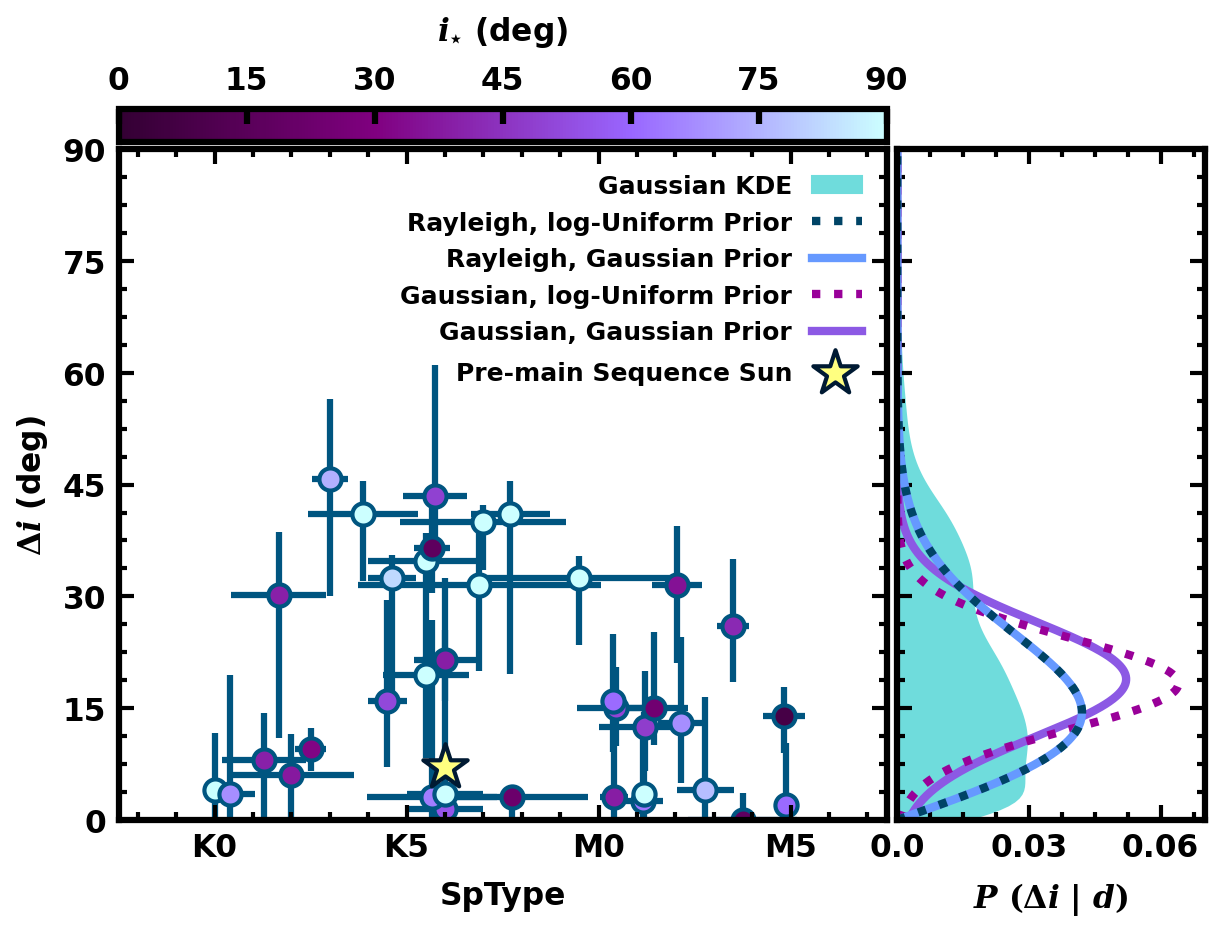

In [475]:

# map_min = zlims[0]
# map_max = zlims[1]

x_column = 'SpType'
x_column_err_p = 'SpType Unc'
x_column_err_m = 'SpType Unc'
x_label = 'SpType'
xlims = [3.75, 5.75]
x_text = 'SpT'

y_column = 'disk diff'
y_column_err_p = 'disk diff +Unc'
y_column_err_m = 'disk diff -Unc'
y_label = r'$\Delta i$ (deg)'
ylims = [-2, 90]
y_text = 'Delta_i'

z_column = 'i star (deg)'
z_column_err_p = 'i star -Unc'
z_column_err_m = 'i star +Unc'
z_label = r'$i_{\mathdefault{\star}}$ (deg)'
zlims = [0, 90]
z_text = 'i_Star'

parameter_z_norm = plt.Normalize(zlims[0], zlims[1])

parameter_x_stassun = np.array(condensed_df_stassun[x_column].values)
parameter_x_err_p_stassun = np.array(condensed_df_stassun[x_column_err_p].values)
parameter_x_err_m_stassun = np.array(condensed_df_stassun[x_column_err_m].values)
parameter_y_stassun = np.array(condensed_df_stassun[y_column].values)
parameter_y_err_p_stassun = np.array(condensed_df_stassun[y_column_err_p].values)
parameter_y_err_m_stassun = np.array(condensed_df_stassun[y_column_err_m].values)
parameter_z_stassun = np.array(condensed_df_stassun[z_column].values)
parameter_z_err_p_stassun = np.array(condensed_df_stassun[z_column_err_p].values)
parameter_z_err_m_stassun = np.array(condensed_df_stassun[z_column_err_m].values)
targets_list_stassun = np.array(condensed_df_stassun['Simbad Name'].values)

parameter_x_err_stassun = [parameter_x_err_m_stassun, parameter_x_err_p_stassun]
parameter_y_err_stassun = [parameter_y_err_m_stassun, parameter_y_err_p_stassun]
parameter_z_err_stassun = [parameter_z_err_m_stassun, parameter_z_err_p_stassun]




grid_height = 2
grid_width = 2

fig_width = 8
fig_height = 6

single_parplot_fontsize = 15

target_labels_on = False

point_size = 6


fig = plt.figure(figsize=(fig_width, fig_height), dpi=150)
gs = gridspec.GridSpec(grid_height , grid_width , width_ratios=[1, 0.40], height_ratios=[0.05, 1])  # , wspace=0.12, hspace=0.35)
axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]
cbar_ax = axes[0]
blank_ax = axes[1]
ax1 = axes[2]
ax2 = axes[3]
# ax2_twin = axes[3].twiny()

ax1.minorticks_on()
ax2.minorticks_on()
# ax2_twin.minorticks_on()

ax1.set_xlabel('SpType', fontsize=single_parplot_fontsize, labelpad=8)
ax1.set_ylabel(r'$\Delta i$ (deg)', fontsize=single_parplot_fontsize, labelpad=6)
ax2.set_xlabel(r'$P$ $(\Delta i$ | $d)$', fontsize=single_parplot_fontsize, labelpad=8)
# ax2_twin.set_xlabel(r'$P$ $(\Delta i$ | $d)$', fontsize=single_parplot_fontsize, labelpad=8)

point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z_stassun]
point_edgecolors = [edge_color]*len(point_colors)
if z_colors_on == True:
    point_colors = [colormap(parameter_z_norm(bep)) for bep in parameter_z_stassun]
else:
    point_colors = [point_color_no_z]*len(point_colors)

for par_i in range(len(parameter_y_stassun)):
    # if parameter_y_stassun[par_i] <= 5:
    #     print(targets_list_stassun[par_i], parameter_x_stassun[par_i])
    ax1.scatter([parameter_x_stassun[par_i]], [parameter_y_stassun[par_i]], color=point_colors[par_i], edgecolors=point_edgecolors[par_i], linewidth=2, s=np.pi*point_size**2, linestyle='None')
    ax1.errorbar([parameter_x_stassun[par_i]], [parameter_y_stassun[par_i]], xerr=[[parameter_x_err_stassun[0][par_i]],[parameter_x_err_stassun[1][par_i]]], yerr=[[parameter_y_err_stassun[0][par_i]], [parameter_y_err_stassun[1][par_i]]],
                elinewidth=3, linewidth=0, capsize=0, ecolor=point_edgecolors[par_i], capthick=0, zorder=-1)




# ---------------------- THE PRE-MAIN SEQUENCE SUN ----------------------  #
Solar_SpType = 4.6
Solar_SpType_err = 0.05
Solar_obliquity = 7.155
Solar_obliquity_err = 0.002
Solar_point_size = 500

sun_color = '#ffff80'  # '#ace600'
ax1.scatter([Solar_SpType], [Solar_obliquity], marker='*', color=sun_color, edgecolors='#001a33', linewidth=2, s=Solar_point_size, linestyle='None')
ax1.scatter([5.615], [60], marker='*', color=sun_color, edgecolors='#001a33', linewidth=2, s=Solar_point_size, linestyle='None')
ax1.text(5.615-0.11, 60, 'Pre-main Sequence Sun', horizontalalignment='right', verticalalignment='center', fontsize=12)

# ax1.errorbar([Solar_SpType], [Solar_obliquity], xerr=[Solar_SpType_err], yerr=[Solar_obliquity_err], elinewidth=3, linewidth=0, capsize=0, ecolor=point_edgecolors[par_i], capthick=0, zorder=-1)   


ax1.set_xlim(xlims)
ax1.set_ylim(ylims)

ax1.tick_params(which='minor', length=4, width=2)
ax1.tick_params(which='major', length=7, width=2)

if len(parameter_x_stassun) == 1:
    ax1.text(0.10, 0.90, targets_list_stassun[0], horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
else:
    if target_labels_on == True:
        for par_xi, var_x in enumerate(parameter_x_stassun):
            ax1.text(parameter_x_stassun[par_xi], parameter_y_stassun[par_xi]+np.random.uniform(0.5, 1.5, 1)[0], targets_list_stassun[par_xi], horizontalalignment='center', verticalalignment='bottom', fontsize=8)  # , transform=ax.transAxes)


sptype_designations = {'0': 'B',
                    '0.5': 'B5',
                    '1': 'A0',
                    '1.5': 'A5',
                    '2': 'F0',
                    '2.5': 'F5',
                    '3': 'G0',
                    '3.5': 'G5',
                    '4': 'K0',
                    '4.5': 'K5',
                    '5': 'M0',
                    '5.5': 'M5',
                    }

xtickvals = np.arange(xlims[0], xlims[1]+0.25, 0.25)
xticklabs = []
xticks = []
for xtick in xtickvals:
    if xtick < xlims[1]:
        if (np.mod(xtick,1) == 0) and (xtick >= xlims[0]):
            xticks.append(xtick)
            xticklabs.append(sptype_designations[str(int(xtick))])
        elif (np.mod(xtick,0.5) == 0) and (xtick >= xlims[0]):
            xticks.append(xtick)
            xticklabs.append(sptype_designations['{:.1f}'.format(xtick)])
ax1.set_xticks(xticks)
xticklabels = ax1.set_xticklabels(xticklabs, fontsize=single_parplot_fontsize)

ax1.tick_params(pad=6)
ax1.set_rasterized(True)


if z_colors_on == True:
    # Add a single colorbar
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=parameter_z_norm, cmap=colormap), cax=cbar_ax, orientation='horizontal') # , use_gridspec=True, shrink=1., fraction=0.05, pad=0.02)  # location='top', 
    cbar.set_label(z_label, labelpad=12, fontsize=single_parplot_fontsize, weight='bold')  # rotation=270
    # cbar_ticks_floats = cbar.get_ticks()
    # cbar_ticks = [int(cbar_tick) for cbar_tick in cbar_ticks_floats]
    cbar_ticks = np.arange(0, 105, 15)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks, fontsize=single_parplot_fontsize)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')





# ax2.barh(Delta_i_bin_edges[:-1] + 0.5*Delta_i_bin_width, Delta_i_hist, edgecolor=point_edgecolors, color='None', lw=2, height=Delta_i_bin_width, align='center', label='MAP Values', alpha=0.6, zorder=1)
# ax2.barh(x_grid[:, 0], density_estimation, edgecolor='None', color=point_edgecolors, lw=2, height=Delta_i_bin_width, align='center', label='MAP Values', alpha=0.3, zorder=1)

ax2.fill_between(density_estimation_total_positive_x, x_grid[:, 0], color=kde_color, alpha=1, label='Gaussian KDE', zorder=1)
# ax2.plot(density_estimation, x_grid[:, 0], color=point_edgecolors[0], alpha=0.3, label='KDE', zorder=1)


for HBM_key in list(Delta_i_HBM_files.keys()):
    model_profile = Delta_i_HBM_files[HBM_key]['Model Profile']
    if HBM_key == 'Rayleigh, log-Uniform Prior':
        model_linestyle = ':'
        model_color = '#004466'  # '#002b80'
        model_zorder = 6
    if HBM_key == 'Rayleigh, Gaussian Prior':
        model_linestyle = '-'
        model_color = '#6699ff'  # '#33cccc'  # '#0099cc'
        model_zorder = 5
    if HBM_key == 'Gaussian, log-Uniform Prior':
        model_linestyle = ':'
        model_color = '#990099'  # '#621068'  # '#4d004d'
        model_zorder = 4
    if HBM_key == 'Gaussian, Gaussian Prior':
        model_linestyle = '-'
        model_color = '#8c59e4'  # '#bf00ff'
        model_zorder = 3
    # ax2_twin.plot(model_profile, ivals, lw=4, linestyle=model_linestyle, color=model_color, label=HBM_key, zorder=model_zorder)
    ax2.plot(model_profile, ivals, lw=4, linestyle=model_linestyle, color=model_color, label=HBM_key, zorder=model_zorder)


for spine in ax2.spines.values():
    spine.set_zorder(100)


ytickvals = np.arange(0, 105, 15)
yticks = [int(ytick) for ytick in ytickvals]
ax1.set_yticks(yticks)
ax2.set_yticks(yticks)
yticklabels = ax1.set_yticklabels(yticks, fontsize=single_parplot_fontsize)
ax2.set_yticklabels([])

ax2_xtickvals = np.arange(0, 0.07 + 0.030, 0.030)
ax2.set_xticks(ax2_xtickvals)
ax2.set_xticklabels(ax2_xtickvals, fontsize=single_parplot_fontsize)

# ax2_twin_xtickvals = np.arange(1, 7 + 2, 2)
# ax2_twin.set_xticks(ax2_twin_xtickvals)
# ax2_twin.set_xticklabels(ax2_twin_xtickvals, fontsize=single_parplot_fontsize)

ax1.set_ylim(0, 90)
ax2.set_ylim(0, 90)
ax2.set_xlim(0, 0.07)
# ax2_twin.set_xlim(0, 8)

ax2.tick_params(labelsize=single_parplot_fontsize)

leg2 = ax2.legend(loc='upper left', prop={'size': 12}, ncol=1, bbox_to_anchor=(-1.7, 0.90, 0.5, 0.1), markerfirst=False) # , rotation=90)  # , bbox_to_anchor=(0., 0.5, 0.5, 0.35))
# leg2_twin = ax2_twin.legend(loc='upper right', prop={'size': 12}, ncol=1, bbox_to_anchor=(-0.55, 0.65, 0.5, 0.30), markerfirst=False) # , rotation=90)  # , bbox_to_anchor=(0., 0.5, 0.5, 0.35))

# for txt in leg2.get_texts():
#     txt.set_rotation(270)

ax2.tick_params(which='minor', length=4, width=2)
ax2.tick_params(which='major', length=7, width=2)




for spine in blank_ax.spines.values():
    spine.set_edgecolor('#ffffff')
blank_ax.set_xticklabels([])
blank_ax.set_yticklabels([])
blank_ax.tick_params(axis='both', which='both', color='#ffffff')





fig.subplots_adjust(left=0.085, bottom=0.10, right=0.99, top=0.89, wspace=0.02, hspace=0.02)
labels_text = 'bep'


# SAVE THE FIGURE
if len(parameter_x_stassun) == 1:
    save_par_vs_Delta_i_HBM_string = resolution_text + '_' + targets_list_stassun[0] + '_ParPlotHBM_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text  + '_' + date_str + '.pdf'
if len(parameter_x_stassun) > 1:
    save_par_vs_Delta_i_HBM_string = resolution_text + '_ParPlotHBM_' + light_or_dark_dext + '_' + transparent_text + '_' + Rshift_text + '_' + Pshift_text  + '_' + labels_text + '_' + date_str + '.pdf'

if plot_transparent == True:
    fig.savefig(test_figures_directory + save_par_vs_Delta_i_HBM_string, dpi=300, transparent=True)
else:
    fig.savefig(test_figures_directory + save_par_vs_Delta_i_HBM_string, dpi=300, transparent=False)

plt.show()

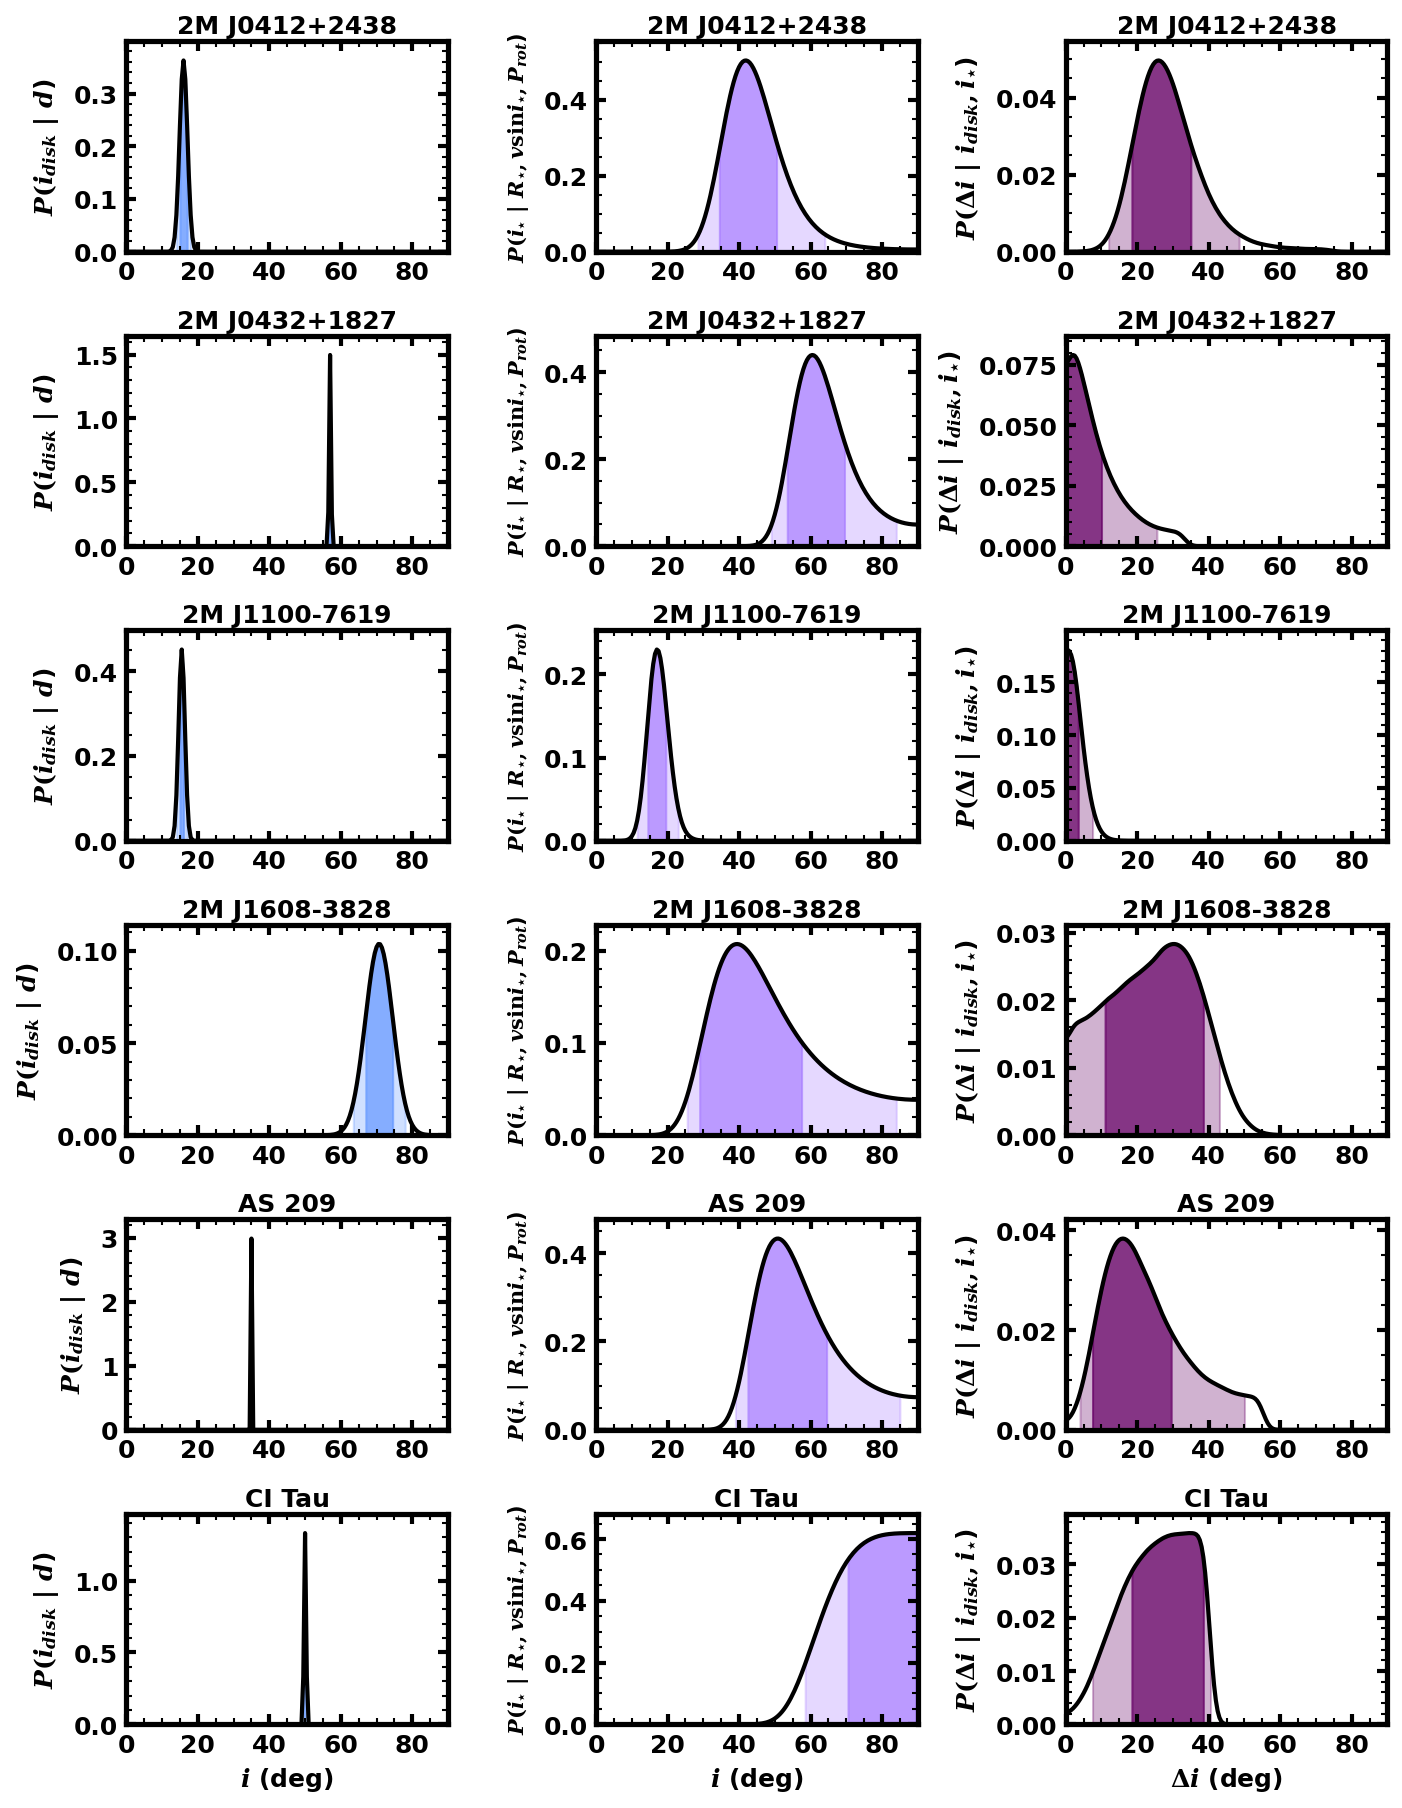

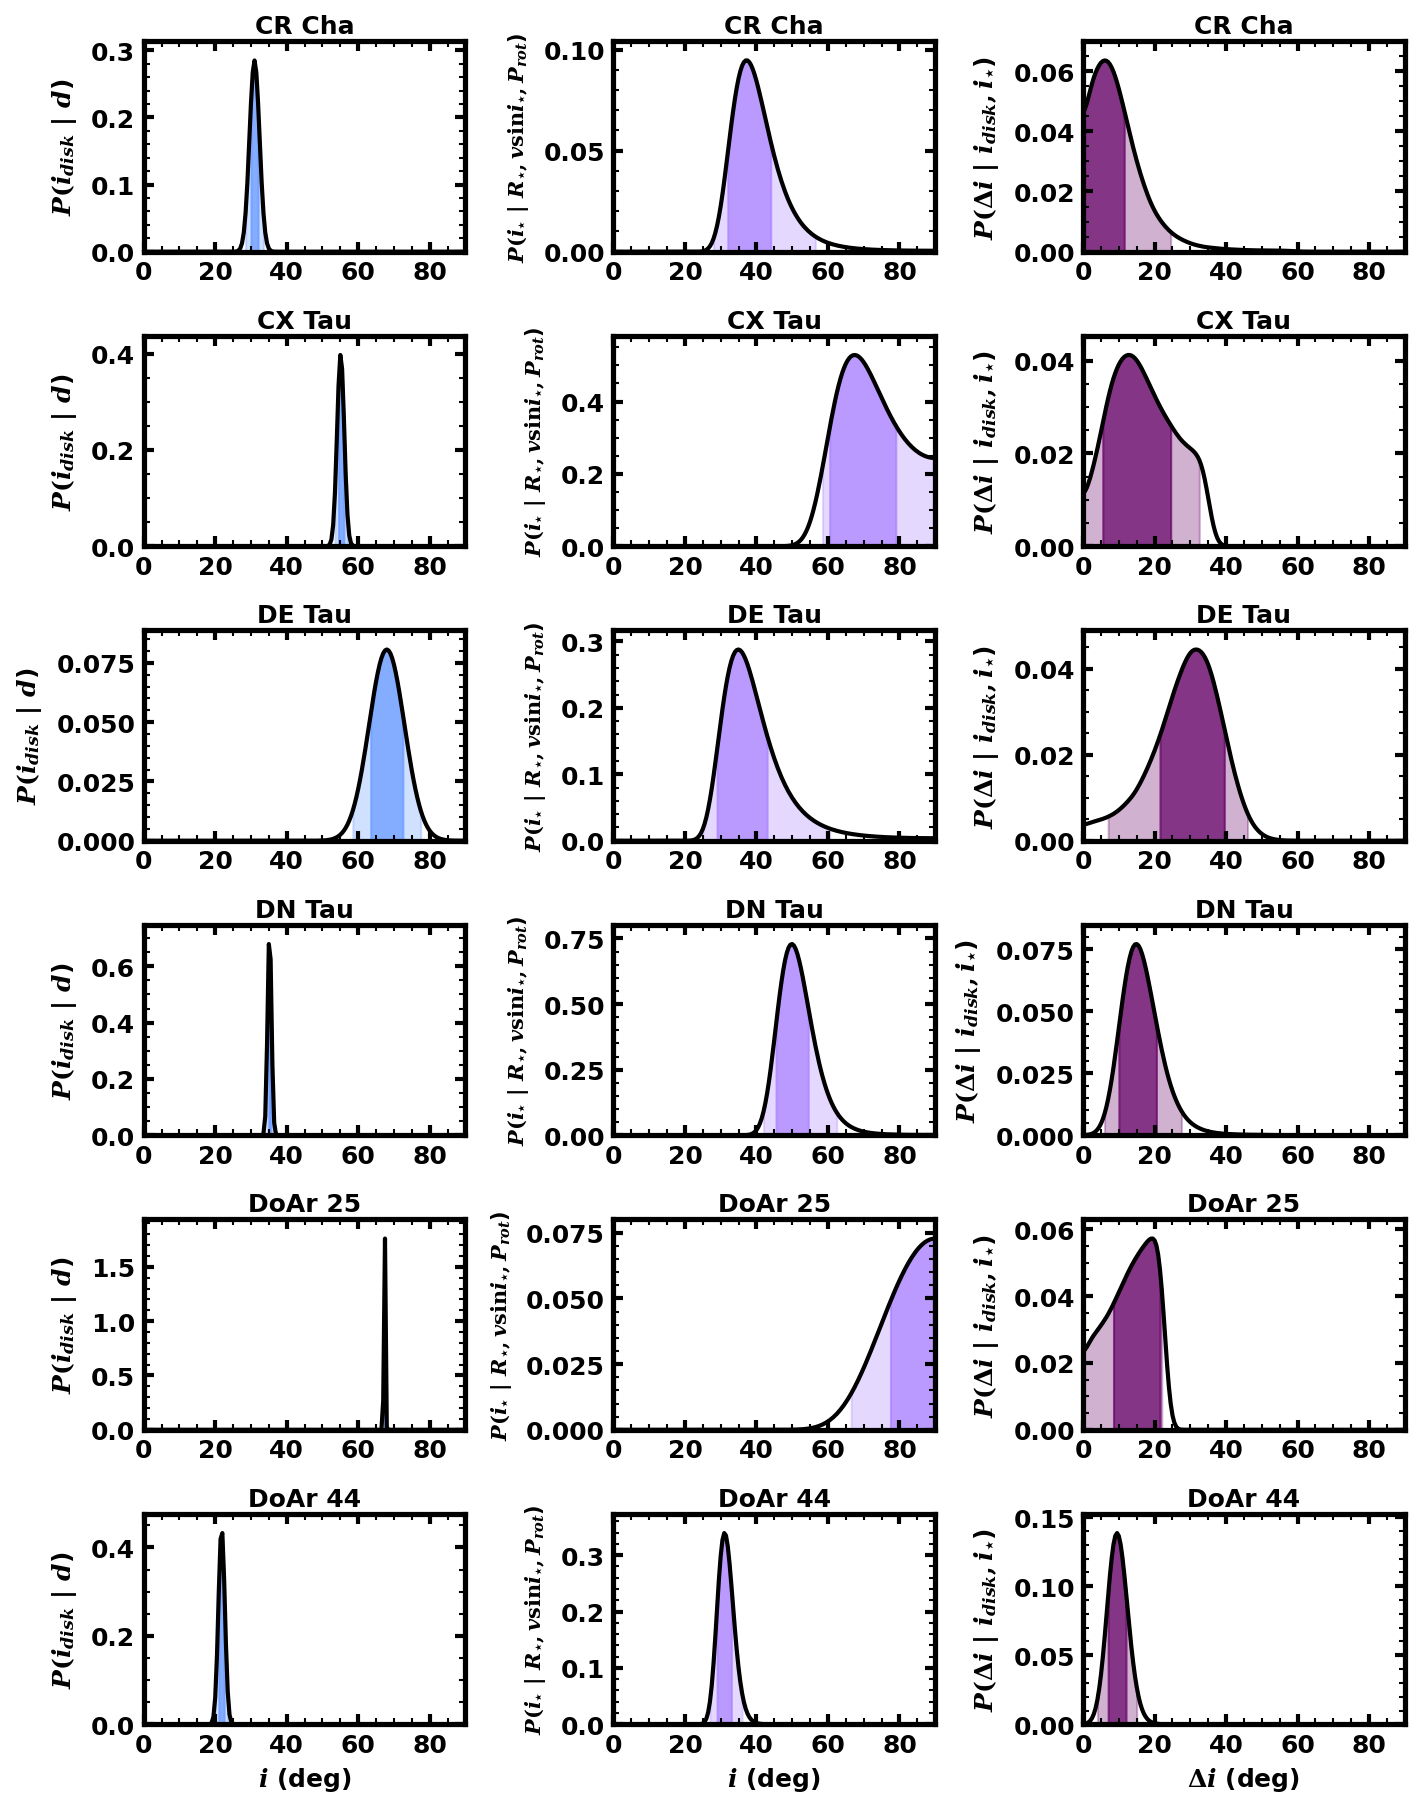

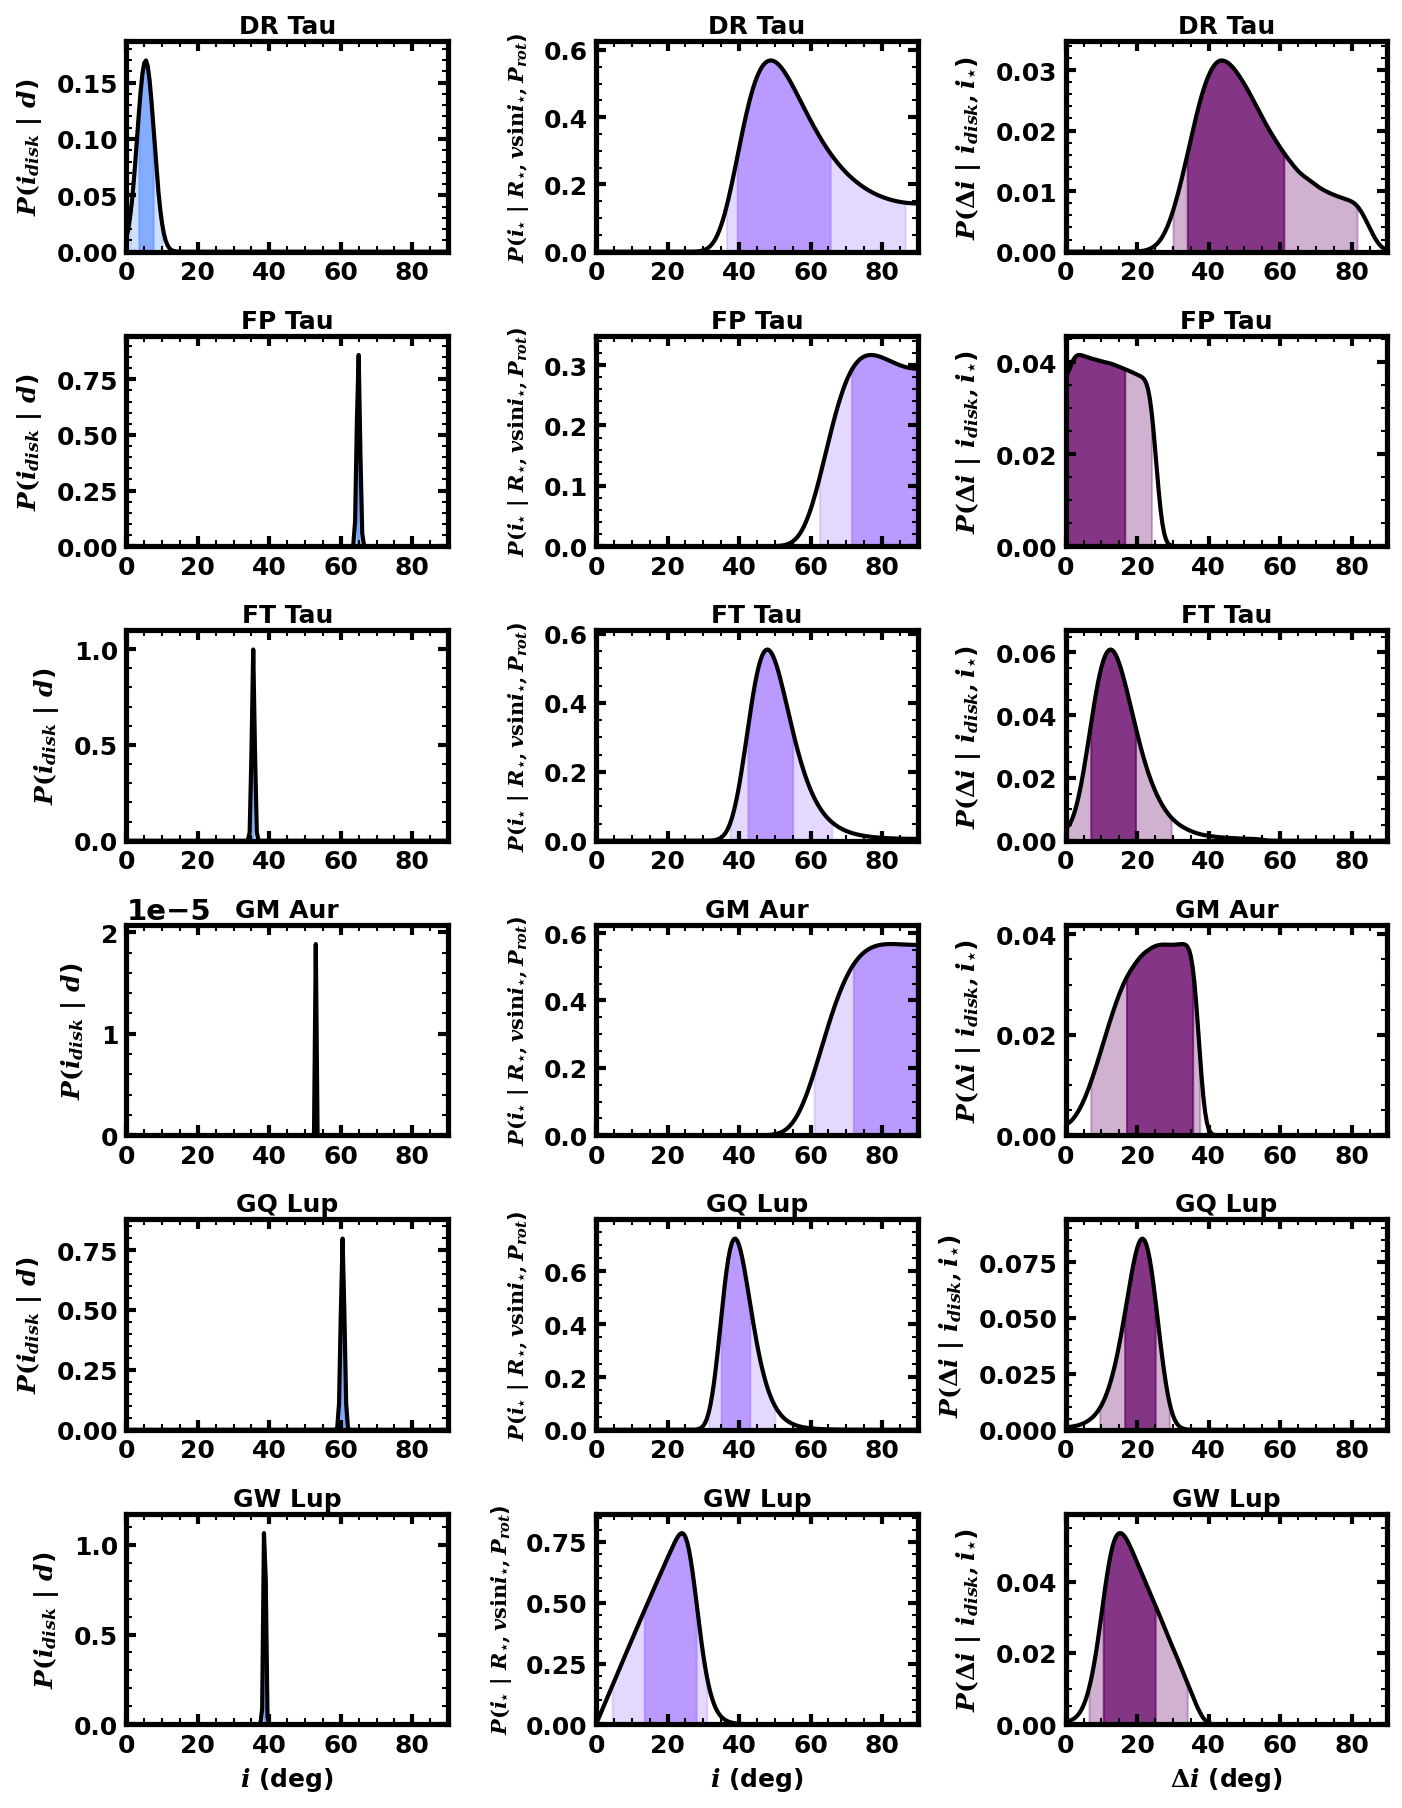

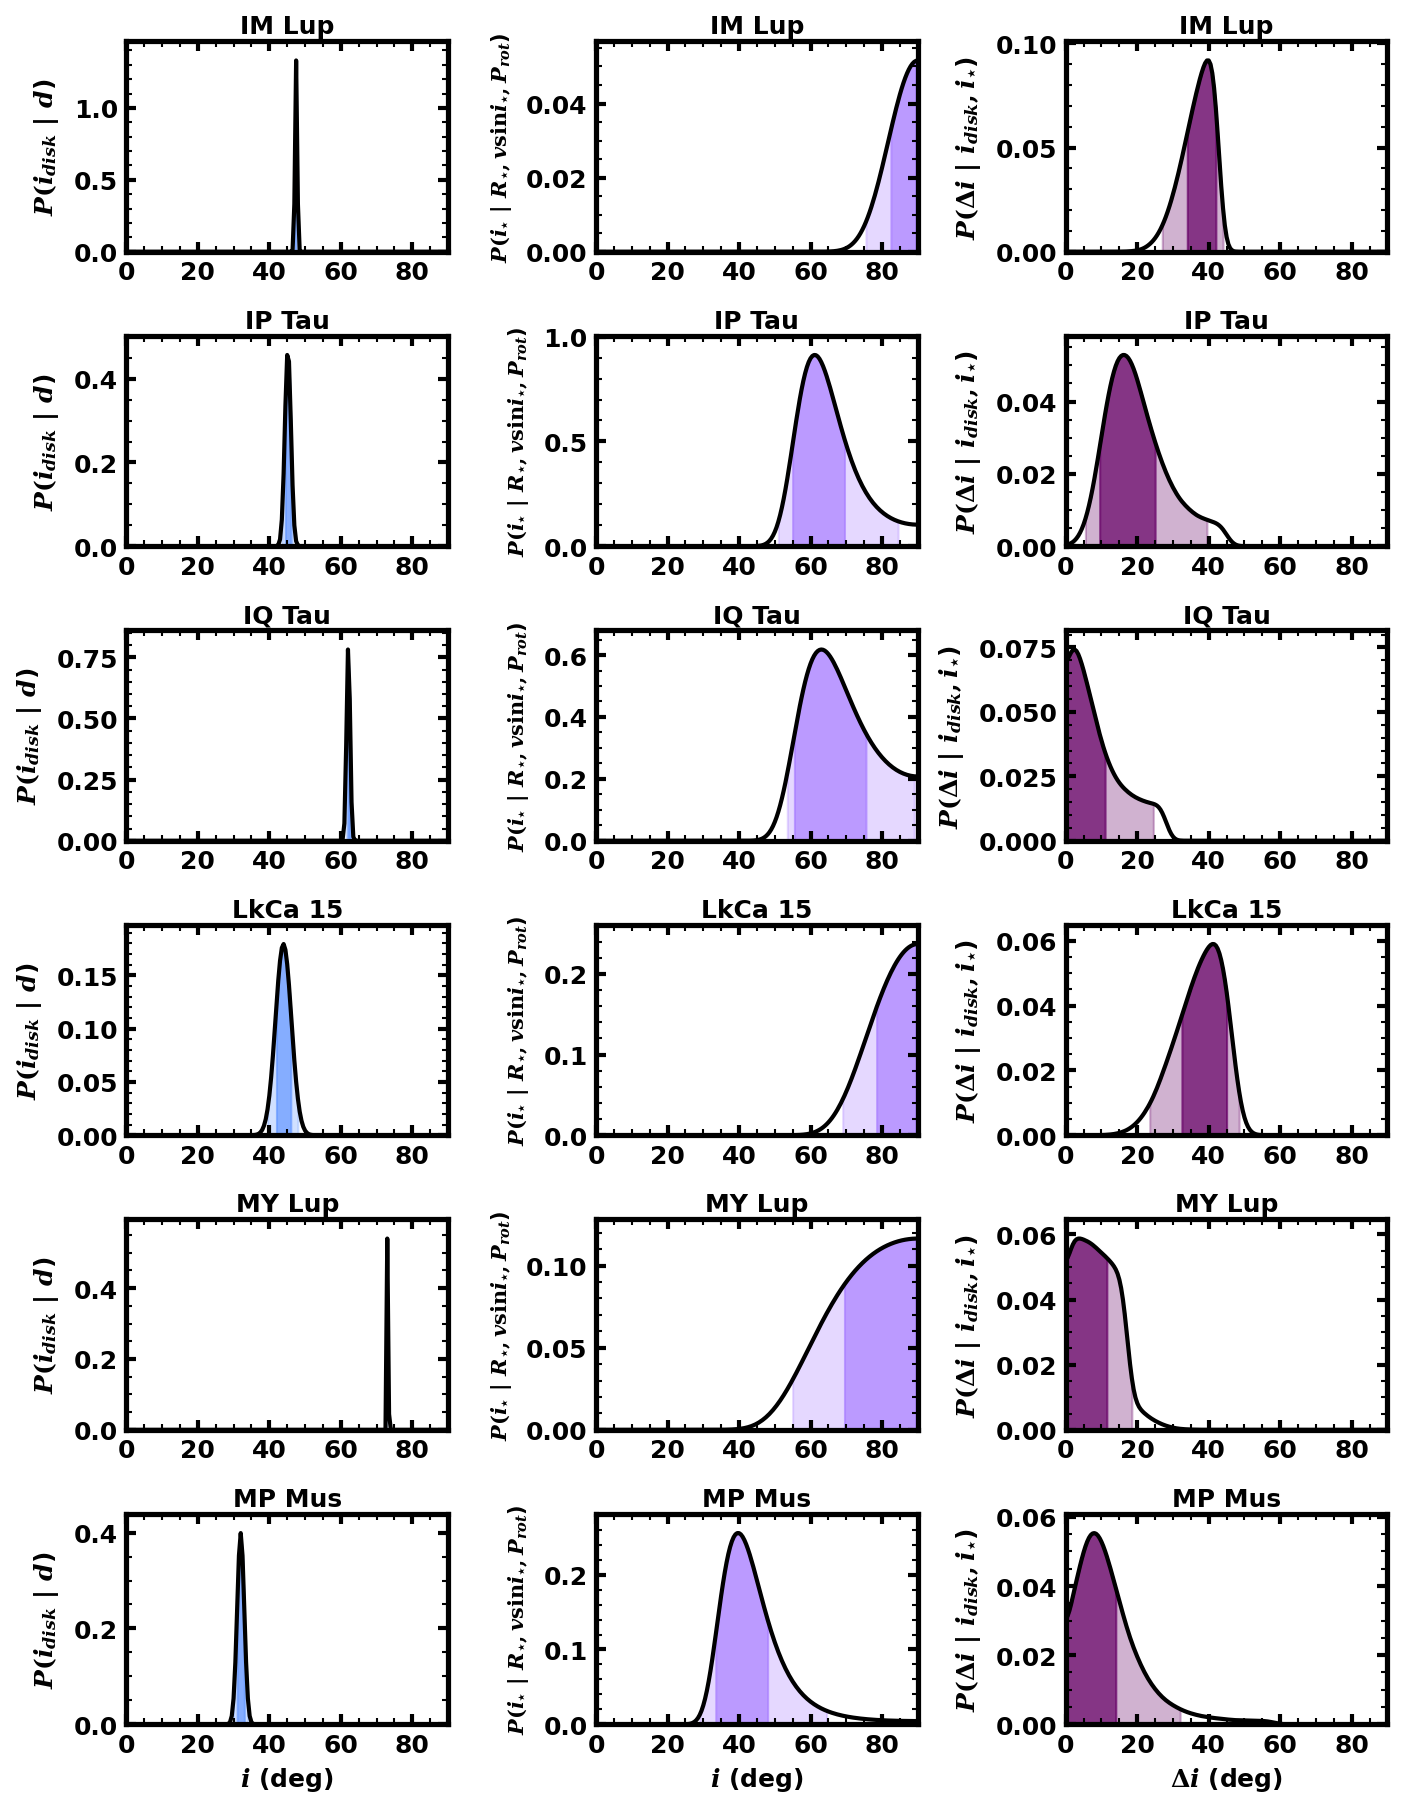

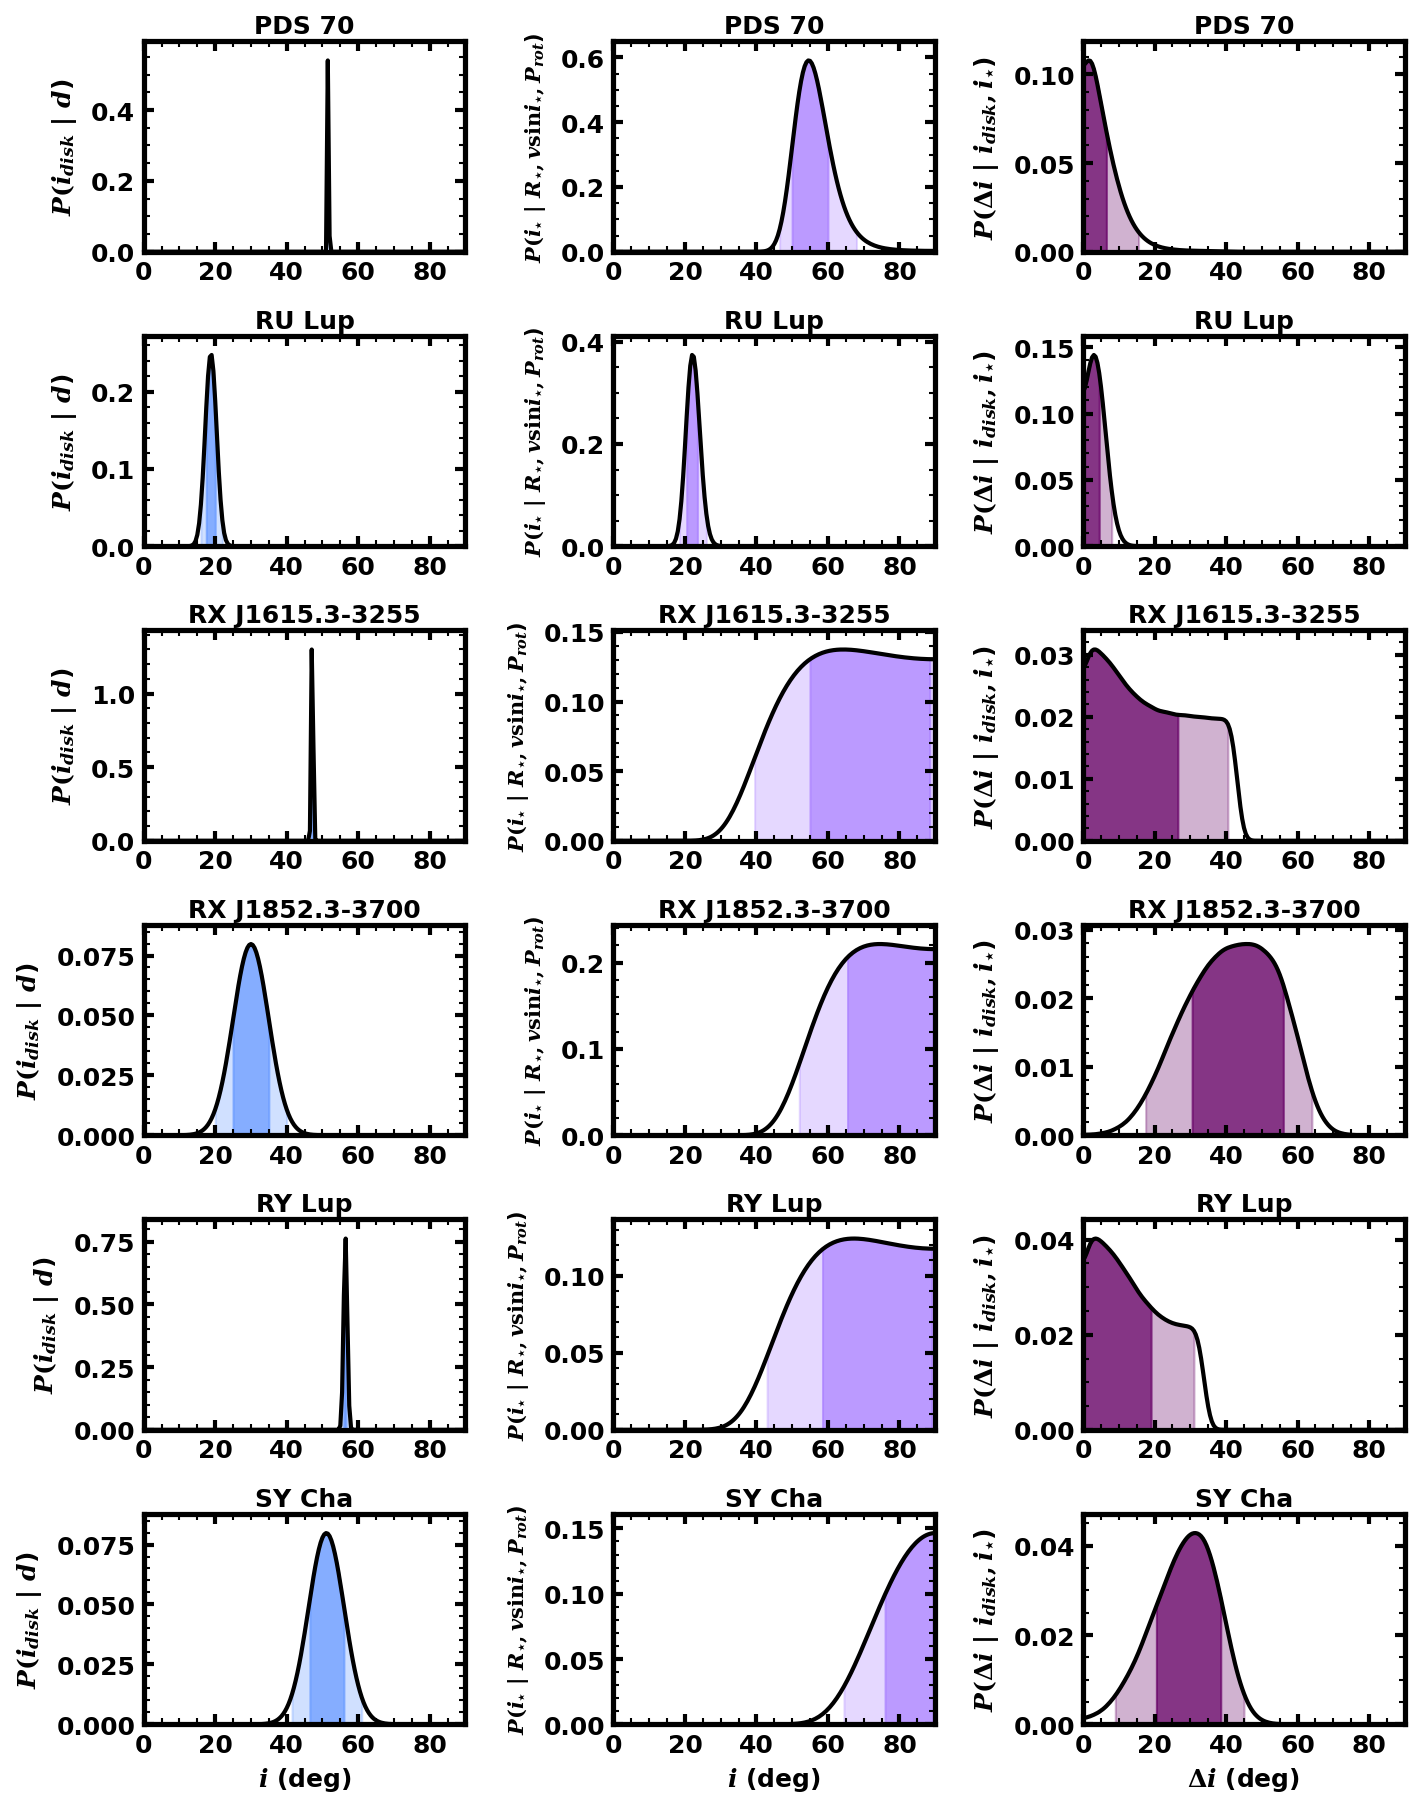

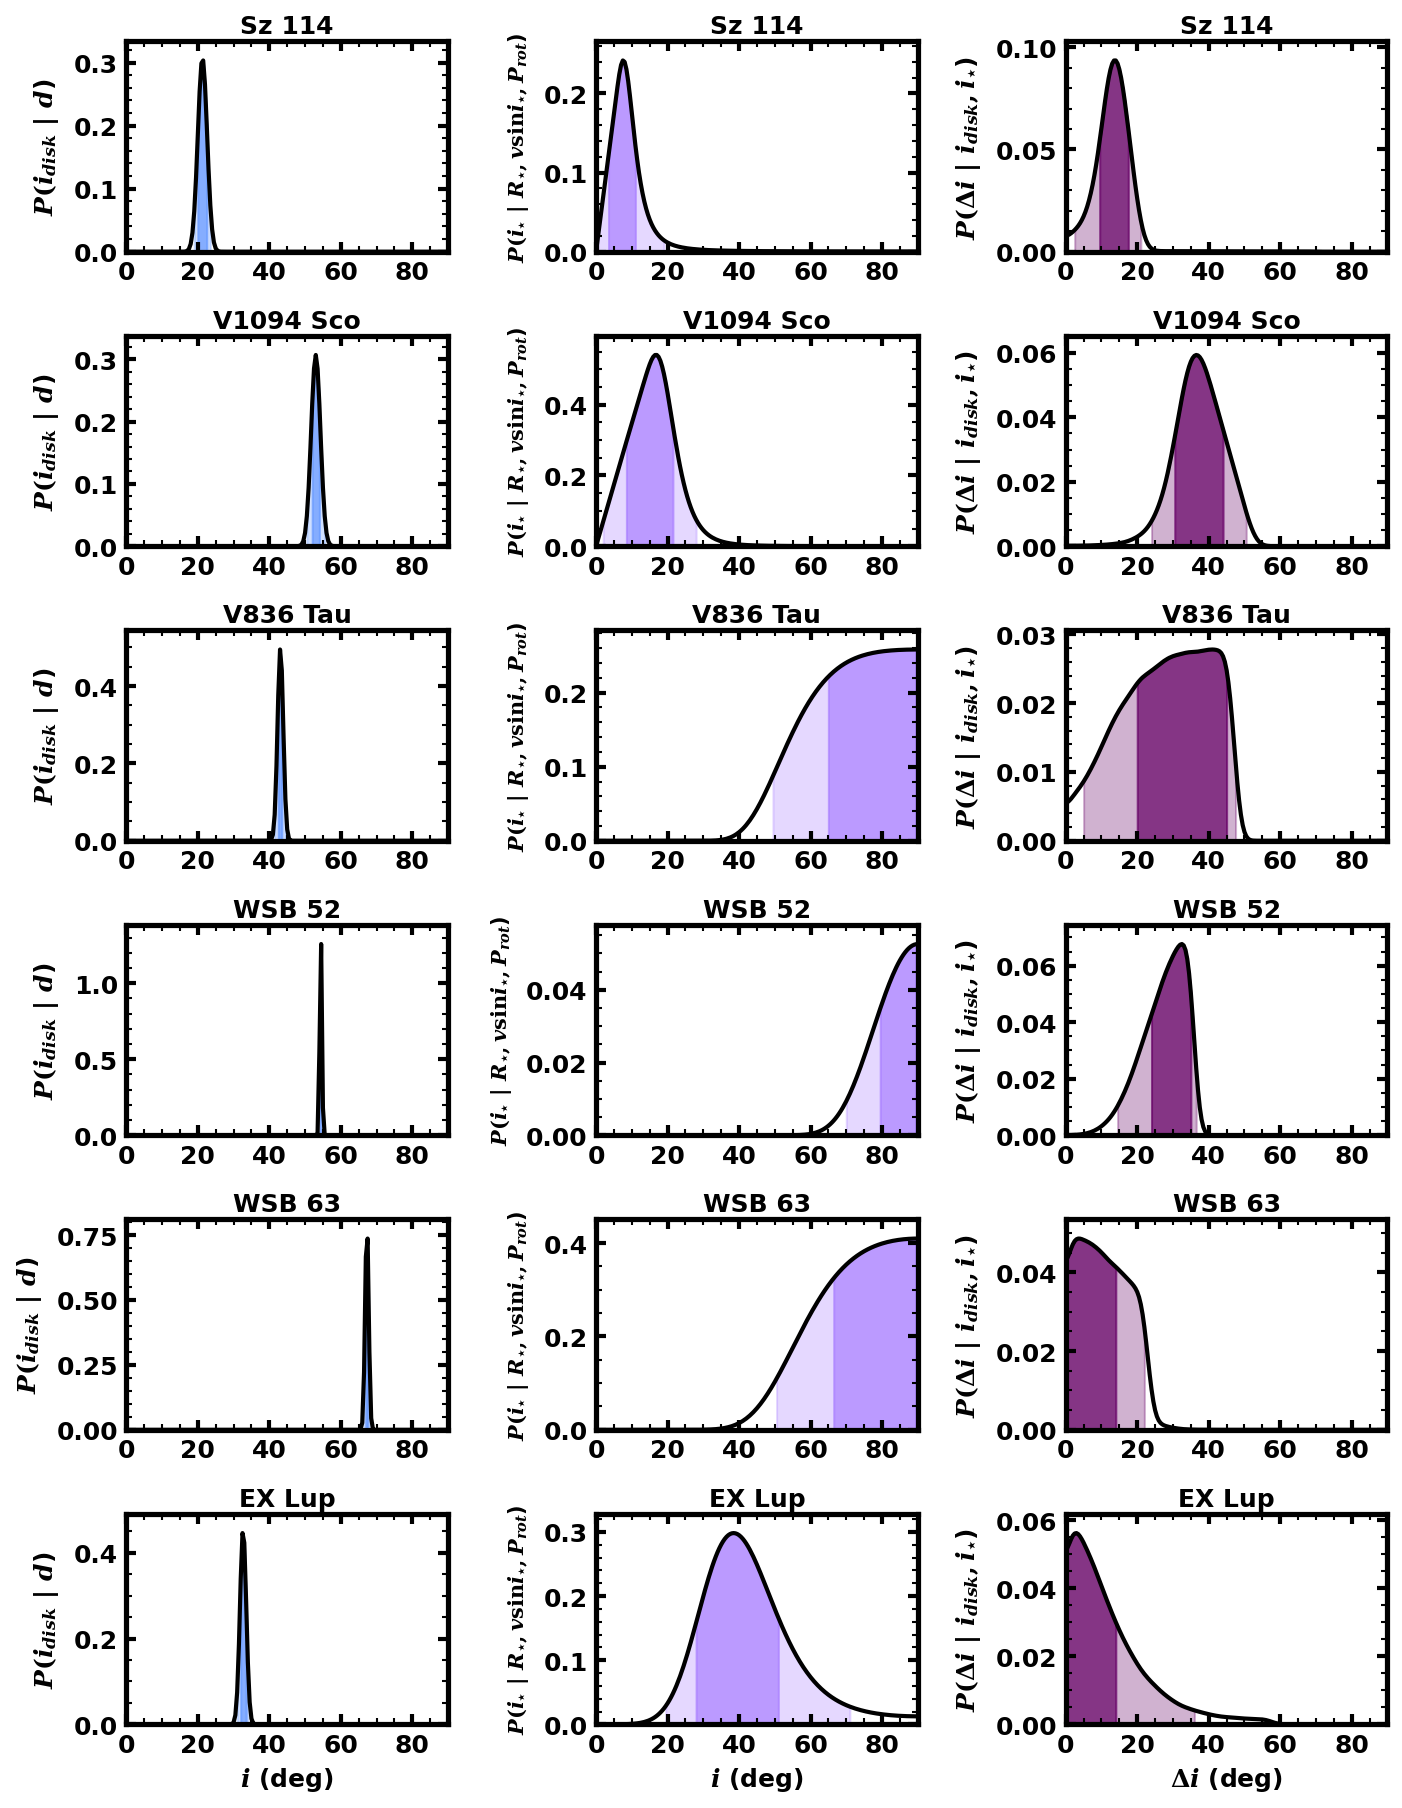

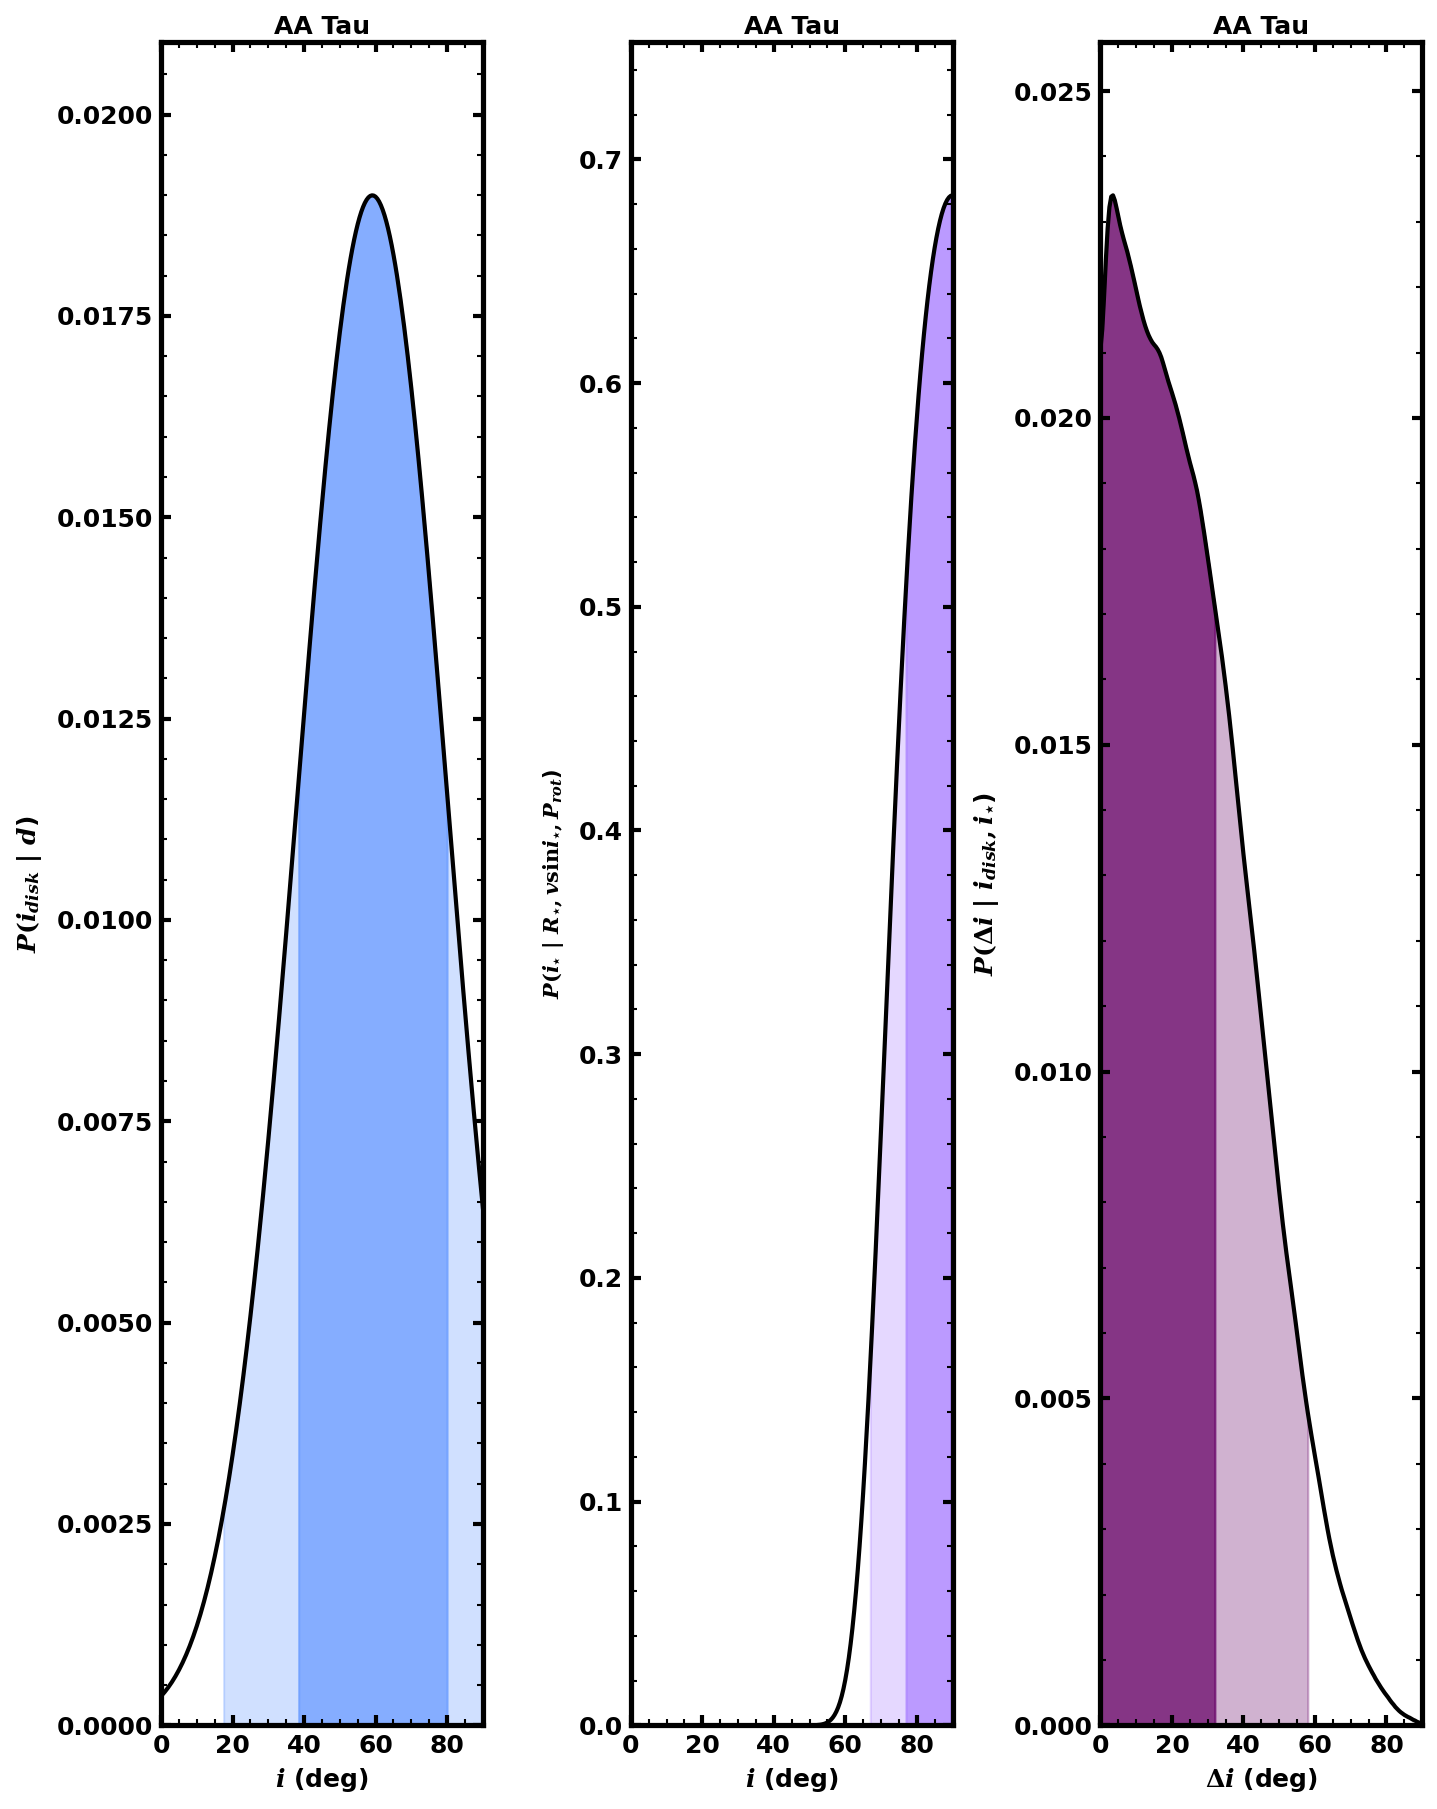

In [470]:
title_fontsize = 12
label_fontsize = 12
tick_fontsize = 12
targetlabel_fontsize = 12

title_weight = 'semibold'

title_pad = 4
label_pad = 6

ccombonum = 4

if ccombonum == 1:
    ccombo = ['#29a366', '#003366', '#007399']
elif ccombonum == 2:
    ccombo = ['#2eb8b8', '#aa80ff', '#660066']
elif ccombonum == 3:
    ccombo = ['#6d931f', '#4d0019', '#007399']
elif ccombonum == 4:
    ccombo = ['#6699ff', '#aa80ff', '#660066']

i_disk_fill_color = ccombo[0]
i_star_fill_color = ccombo[1]
Delta_i_fill_color = ccombo[2]

alpha_sig2 = 0.3
alpha_sig1 = 1 - alpha_sig2


grid_width = 3
grid_height = 6

setnum = 0

fig_height = 12
fig_width = 9.5

frame_numbers_on = False


sig1_widths = []


for targetnum in range(len(condensed_df_stassun['Simbad Name'].values)-1):

    # print(targetnum)

    if targetnum != 0:
        targetnum += 1

    if targetnum >= 36:
        grid_height = len(condensed_df_stassun['Simbad Name'].values) - 36
        # print('grid height: ', grid_height)

    if np.mod(targetnum, 6) == 0:
        setnum += 1

        fig = plt.figure(figsize=(fig_width, fig_height), dpi=150)
        gs = gridspec.GridSpec(grid_height, grid_width, width_ratios=[1, 1, 1])  # , wspace=0.56, hspace=0.40)
        axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]

        for ax_i, ax in enumerate(axes):

            #print(targetnum)

            ax.minorticks_on()
            ax.set_rasterized(True)

            if (np.mod(ax_i, grid_width) == 0) and (ax_i != 0):
                targetnum += 1


            # simbad_name = condensed_df_stassun['Simbad Name'].values[targetnum]
            # if '2MASS' in simbad_name:
            #     target = '2M ' + simbad_name[5:]
            # else:
            #     target = simbad_name

            simbad_name = condensed_df_stassun['Simbad Name'].values[targetnum]
            if '2MASS' in simbad_name:
                if '+' in simbad_name[5:]:
                    split1 = simbad_name[5:].split('+')[0].replace(' ', '')[0:5]
                    split2 = '+' + simbad_name[5:].split('+')[1].replace(' ', '')[0:4]
                if '-' in simbad_name[5:]:
                    split1 = simbad_name[5:].split('-')[0].replace(' ', '')[0:5]
                    split2 = '-' + simbad_name[5:].split('-')[1].replace(' ', '')[0:4]
                target = '2M ' + split1 + split2
            else:
                target = simbad_name

            target_str = condensed_df_stassun['Simbad Name'][targetnum].replace(' ', '')
            if '/' in condensed_df_stassun['Simbad Name'][targetnum]:
                target_str = target_str.replace('/', '-')


            Pdensity = pd.read_csv(distribution_dir + 'Prob_' + target_str + '.csv')
            i_values = Pdensity['i (deg)'].values

            P_i_disk = Pdensity['P(i Disk | i)'].values
            MAP_i_disk = Pdensity['i Disk MAP'].values[0]
            sig1_m_i_disk = Pdensity['i Disk -Unc1'].values[0]
            sig1_p_i_disk = Pdensity['i Disk +Unc1'].values[0]
            sig2_m_i_disk = Pdensity['i Disk -Unc2'].values[0]
            sig2_p_i_disk = Pdensity['i Disk +Unc2'].values[0]

            P_i_star = Pdensity['P(i Star | i)'].values
            MAP_i_star = Pdensity['i Star MAP'].values[0]
            sig1_m_i_star = Pdensity['i Star -Unc1'].values[0]
            sig1_p_i_star = Pdensity['i Star +Unc1'].values[0]
            sig2_m_i_star = Pdensity['i Star -Unc2'].values[0]
            sig2_p_i_star = Pdensity['i Star +Unc2'].values[0]

            P_Delta_i = Pdensity['P(Delta i | i)'].values
            MAP_Delta_i = Pdensity['Delta i MAP'].values[0]
            sig1_m_Delta_i = Pdensity['Delta i -Unc1'].values[0]
            sig1_p_Delta_i = Pdensity['Delta i +Unc1'].values[0]
            sig2_m_Delta_i = Pdensity['Delta i -Unc2'].values[0]
            sig2_p_Delta_i = Pdensity['Delta i +Unc2'].values[0]

            # if np.mod(ax_i, grid_width) == 0:
            #     for spine in ax.spines.values():
            #         spine.set_edgecolor('#ffffff')
            #     ax.set_xticklabels([])
            #     ax.set_yticklabels([])
            #     ax.tick_params(axis='both', which='both', color='#ffffff')
            #     ax.text(0.85, 0.50, target, horizontalalignment='right', verticalalignment='center', fontsize=targetlabel_fontsize, color='#000000', transform=ax.transAxes)

            # else:
            for spine in ax.spines.values():
                spine.set_linewidth(2.5)

            # SPECIFY THE X TICKS
            xticks = [0, 20, 40, 60, 80]
            xticklabels = [str(int(xtick)) for xtick in xticks]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(0, 90)

            # LABEL THE X AXES
            if ax_i >= 3 * (grid_height - 1):
                if (np.mod(ax_i, grid_width) == 0) or (np.mod(ax_i - 1, grid_width) == 0):
                    ax.set_xlabel('$i$ (deg)', fontsize=label_fontsize)
                if np.mod(ax_i - 2, grid_width) == 0:
                    ax.set_xlabel(r'$\Delta i$ (deg)', fontsize=label_fontsize)
            
            # PLOT THE DISK DISTRIBUTION
            if np.mod(ax_i, grid_width) == 0:
                ax.set_title(target, fontsize=title_fontsize, pad=title_pad, fontweight=title_weight)
                ax.set_ylabel(r'$P(i_{disk}$ | $d$)', fontsize=label_fontsize, labelpad=label_pad)

                ax.plot(i_values, P_i_disk, color='#000000', lw=2, zorder=4)
                where_sig1 = np.where((i_values >= MAP_i_disk - sig1_m_i_disk) & (i_values <= MAP_i_disk + sig1_p_i_disk))[0]
                where_sig2 = np.where((i_values >= MAP_i_disk - sig2_m_i_disk) & (i_values <= MAP_i_disk + sig2_p_i_disk))[0]
                ax.fill_between(x=i_values[where_sig1], y1=P_i_disk[where_sig1], color=i_disk_fill_color, alpha=alpha_sig1, zorder=-1)
                ax.fill_between(x=i_values[where_sig2], y1=P_i_disk[where_sig2], color=i_disk_fill_color, alpha=alpha_sig2, zorder=-1)
                ax.set_ylim(0, 1.10*max(P_i_disk))

            # PLOT THE STAR DISTRIBUTION
            if np.mod(ax_i - 1, grid_width) == 0:
                ax.set_title(target, fontsize=title_fontsize, pad=title_pad, fontweight=title_weight)
                ax.set_ylabel(r'$P(i_{\mathdefault{\star}}$ | $R_{\mathdefault{\star}}, v\mathrm{sin}i_{\mathdefault{\star}}, P_{rot}$)', fontsize=label_fontsize-2, labelpad=label_pad)

                ax.plot(i_values, P_i_star, color='#000000', lw=2, zorder=4)
                where_sig1 = np.where((i_values >= MAP_i_star - sig1_m_i_star) & (i_values <= MAP_i_star + sig1_p_i_star))[0]
                where_sig2 = np.where((i_values >= MAP_i_star - sig2_m_i_star) & (i_values <= MAP_i_star + sig2_p_i_star))[0]
                ax.fill_between(x=i_values[where_sig1], y1=P_i_star[where_sig1], color=i_star_fill_color, alpha=alpha_sig1, zorder=-1)
                ax.fill_between(x=i_values[where_sig2], y1=P_i_star[where_sig2], color=i_star_fill_color, alpha=alpha_sig2, zorder=-1)
                ax.set_ylim(0, 1.10*max(P_i_star))

            # PLOT THE STAR DISTRIBUTION
            if np.mod(ax_i - 2, grid_width) == 0:
                ax.set_title(target, fontsize=title_fontsize, pad=title_pad, fontweight=title_weight)
                ax.set_ylabel(r'$P(\Delta i$ | $i_{disk}, i_{\mathdefault{\star}}$)', fontsize=label_fontsize, labelpad=label_pad)
                
                ax.plot(i_values, P_Delta_i, color='#000000', lw=2, zorder=4)
                where_sig1 = np.where((i_values >= MAP_Delta_i - sig1_m_Delta_i) & (i_values <= MAP_Delta_i + sig1_p_Delta_i))[0]
                where_sig2 = np.where((i_values >= MAP_Delta_i - sig2_m_Delta_i) & (i_values <= MAP_Delta_i + sig2_p_Delta_i))[0]
                i_MAP = i_values[P_Delta_i == max(P_Delta_i)]
                ax.fill_between(x=i_values[where_sig1], y1=P_Delta_i[where_sig1], color=Delta_i_fill_color, alpha=alpha_sig1, zorder=-1)
                ax.fill_between(x=i_values[where_sig2], y1=P_Delta_i[where_sig2], color=Delta_i_fill_color, alpha=alpha_sig2, zorder=-1)
                ax.set_ylim(0, 1.10*max(P_Delta_i))

                sig1_widths.append(abs(i_values[where_sig1][-1] - np.mean(i_MAP)))
                sig1_widths.append(abs(i_values[where_sig1][0] - np.mean(i_MAP)))

            ax.tick_params(axis='x', which='major', width=2, length=5, labelsize=tick_fontsize, pad=4)
            ax.tick_params(axis='x', which='minor', width=1, length=3, labelsize=tick_fontsize, pad=4)
            ax.tick_params(axis='y', which='major', width=2, length=5, labelsize=tick_fontsize, pad=4)
            ax.tick_params(axis='y', which='minor', width=1, length=3, labelsize=tick_fontsize, pad=4)

            if frame_numbers_on == True:
                ax.text(0.5, 0.5, ax_i, horizontalalignment='center', verticalalignment='center', fontsize=24, color='red', transform=ax.transAxes)

        
        
        fig.subplots_adjust(left=0.10, bottom=0.04, right=0.985, top=0.975, wspace=0.46, hspace=0.40)
        fig.savefig(test_figures_directory + 'sample_grid_' + str(setnum) + '.pdf', dpi=300, transparent=False)
        plt.show()


In [471]:
# print(sig1_widths)
# print(np.median(sig1_widths))
# print(np.mean(sig1_widths))

In [39]:
# fig = plt.figure(figsize=(8, 12), dpi=150)
# grid_width = 5
# grid_height = 6
# gs = gridspec.GridSpec(grid_height, grid_width, width_ratios=[1, 1, 0.30, 1, 1], wspace=0.08, hspace=0.30)
# axes = [fig.add_subplot(gs[ii, jj]) for ii in range(5) for jj in range(5)]

# label_fontsize = 10
# tick_fontsize = 10

# for ax_i, ax in enumerate(axes):

#     ax.minorticks_on()
#     ax.set_rasterized(True)

#     if np.mod(ax_i - 2, 5) == 0:
#         for spine in ax.spines.values():
#             spine.set_edgecolor('#ffffff')
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#         ax.tick_params(axis='both', which='both', color='#ffffff')
#     else:
#         for spine in ax.spines.values():
#             spine.set_linewidth(2.5)
#         x_ticks = np.arange(0, 90 + 30, 30)
#         x_ticklabels = [str(int(x_tick)) for x_tick_i, x_tick in enumerate(x_ticks) if x_tick_i != len(x_ticks)]
#         ax.set_xticks(x_ticks)
#         ax.set_xticklabels(x_ticklabels)
#         if (np.mod(ax_i, 5) == 0) or np.mod(ax_i - 3, 5) == 0:
#             ax.set_ylabel('P(bep | b, e,  p)', fontsize=label_fontsize)
#         if (np.mod(ax_i - 1, 5) == 0) or np.mod(ax_i - 4, 5) == 0:
#             ax.set_yticklabels([])


#         # ax.set_xticklabels([])
#         # ax.set_yticklabels([])

#         ax.tick_params(axis='both', which='major', width=2, length=5, labelsize=tick_fontsize, pad=6)
#         ax.tick_params(axis='both', which='minor', width=1, length=3, labelsize=tick_fontsize, pad=6)

#         ax.text(0.5, 0.5, ax_i, horizontalalignment='center', verticalalignment='center', fontsize=24, color='red', transform=ax.transAxes)
        


# fig.savefig(test_figures_directory + 'test_grid.pdf', dpi=300, transparent=False)
# plt.show()



In [40]:
# title_fontsize = 9
# label_fontsize = 12
# tick_fontsize = 12
# targetlabel_fontsize = 12

# title_pad = 12
# label_pad = 4

# i_disk_fill_color = '#29a366'
# i_star_fill_color = '#003366'
# Delta_i_fill_color = '#007399'

# alpha_sig2 = 0.3
# alpha_sig1 = 1 - alpha_sig2


# grid_width = 4
# grid_height = 6

# setnum = 0


# frame_numbers_on = False



# for targetnum in range(len(condensed_df_stassun['Simbad Name'].values)-1):

#     if targetnum != 0:
#         targetnum += 1
#     if np.mod(targetnum, grid_height) == 0:
#         setnum += 1

#         fig = plt.figure(figsize=(10, 12), dpi=150)
#         gs = gridspec.GridSpec(grid_height, grid_width, width_ratios=[0.50, 1, 1, 1], wspace=0.56, hspace=0.30)
#         axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]

#         for ax_i, ax in enumerate(axes):

#             #print(targetnum)

#             ax.minorticks_on()
#             ax.set_rasterized(True)

#             if (np.mod(ax_i, grid_width) == 0) and (ax_i != 0):
#                 targetnum += 1

#             simbad_name = condensed_df_stassun['Simbad Name'].values[targetnum]
#             if '2MASS' in simbad_name:
#                 if '+' in simbad_name[5:]:
#                     split1 = simbad_name[5:].split('+')[0] + '\n'
#                     split2 = '+' + simbad_name[5:].split('+')[1]
#                 if '-' in simbad_name[5:]:
#                     split1 = simbad_name[5:].split('-')[0] + '\n'
#                     split2 = '-' + simbad_name[5:].split('-')[1]
#                 target = '2MASS\n' + split1 + split2
#             elif 'RX' in simbad_name:
#                 target = 'RX\n' + simbad_name[3:]
#             else:
#                 target = simbad_name

#             target_str = condensed_df_stassun['Simbad Name'][targetnum].replace(' ', '')
#             if '/' in condensed_df_stassun['Simbad Name'][targetnum]:
#                 target_str = target_str.replace('/', '-')

#             Pdensity = pd.read_csv(distribution_dir + 'Prob_' + target_str + '.csv')
#             i_values = Pdensity['i (deg)'].values

#             P_i_disk = Pdensity['P(i Disk | i)'].values
#             MAP_i_disk = Pdensity['i Disk MAP'].values[0]
#             sig1_m_i_disk = Pdensity['i Disk -Unc1'].values[0]
#             sig1_p_i_disk = Pdensity['i Disk +Unc1'].values[0]
#             sig2_m_i_disk = Pdensity['i Disk -Unc2'].values[0]
#             sig2_p_i_disk = Pdensity['i Disk +Unc2'].values[0]

#             P_i_star = Pdensity['P(i Star | i)'].values
#             MAP_i_star = Pdensity['i Star MAP'].values[0]
#             sig1_m_i_star = Pdensity['i Star -Unc1'].values[0]
#             sig1_p_i_star = Pdensity['i Star +Unc1'].values[0]
#             sig2_m_i_star = Pdensity['i Star -Unc2'].values[0]
#             sig2_p_i_star = Pdensity['i Star +Unc2'].values[0]

#             P_Delta_i = Pdensity['P(Delta i | i)'].values
#             MAP_Delta_i = Pdensity['Delta i MAP'].values[0]
#             sig1_m_Delta_i = Pdensity['Delta i -Unc1'].values[0]
#             sig1_p_Delta_i = Pdensity['Delta i +Unc1'].values[0]
#             sig2_m_Delta_i = Pdensity['Delta i -Unc2'].values[0]
#             sig2_p_Delta_i = Pdensity['Delta i +Unc2'].values[0]

#             if np.mod(ax_i, grid_width) == 0:
#                 for spine in ax.spines.values():
#                     spine.set_edgecolor('#ffffff')
#                 ax.set_xticklabels([])
#                 ax.set_yticklabels([])
#                 ax.tick_params(axis='both', which='both', color='#ffffff')
#                 ax.text(0.85, 0.50, target, horizontalalignment='right', verticalalignment='center', fontsize=targetlabel_fontsize, color='#000000', transform=ax.transAxes)

#             else:
#                 for spine in ax.spines.values():
#                     spine.set_linewidth(2.5)

#                 # SPECIFY THE X TICKS
#                 xticks = [0, 20, 40, 60, 80]
#                 xticklabels = [str(int(xtick)) for xtick in xticks]
#                 ax.set_xticks(xticks)
#                 ax.set_xticklabels(xticklabels)
#                 ax.set_xlim(0, 90)

#                 # LABEL THE X AXES
#                 if ax_i >= 21:
#                     if (np.mod(ax_i - 1, grid_width) == 0) or (np.mod(ax_i - 2, grid_width) == 0):
#                         ax.set_xlabel('$i$ (deg)', fontsize=label_fontsize)
#                     if np.mod(ax_i - 3, grid_width) == 0:
#                         ax.set_xlabel(r'$\Delta i$ (deg)', fontsize=label_fontsize)
                
#                 # PLOT THE DISK DISTRIBUTION
#                 if np.mod(ax_i - 1, grid_width) == 0:
#                     # if ax_i < grid_width:
#                     #     ax.set_title(r'Distribution of $i_{disk}$', fontsize=title_fontsize, pad=title_pad)
#                     ax.set_ylabel(r'$P(i_{disk}$ | $i$)', fontsize=label_fontsize, labelpad=label_pad)

#                     ax.plot(i_values, P_i_disk, color='#000000', lw=2, zorder=4)
#                     where_sig1 = np.where((i_values >= MAP_i_disk - sig1_m_i_disk) & (i_values <= MAP_i_disk + sig1_p_i_disk))[0]
#                     where_sig2 = np.where((i_values >= MAP_i_disk - sig2_m_i_disk) & (i_values <= MAP_i_disk + sig2_p_i_disk))[0]
#                     ax.fill_between(x=i_values[where_sig1], y1=P_i_disk[where_sig1], color=i_disk_fill_color, alpha=alpha_sig1, zorder=-1)
#                     ax.fill_between(x=i_values[where_sig2], y1=P_i_disk[where_sig2], color=i_disk_fill_color, alpha=alpha_sig2, zorder=-1)
#                     ax.set_ylim(0, 1.10*max(P_i_disk))

#                 # PLOT THE STAR DISTRIBUTION
#                 if np.mod(ax_i - 2, grid_width) == 0:
#                     # if ax_i < grid_width:
#                     #     ax.set_title(r'Distribution of $i_{\mathdefault{\star}}$', fontsize=title_fontsize, pad=title_pad)
#                     ax.set_ylabel(r'$P(i_{\mathdefault{\star}}$ | $i$)', fontsize=label_fontsize, labelpad=label_pad)

#                     ax.plot(i_values, P_i_star, color='#000000', lw=2, zorder=4)
#                     where_sig1 = np.where((i_values >= MAP_i_star - sig1_m_i_star) & (i_values <= MAP_i_star + sig1_p_i_star))[0]
#                     where_sig2 = np.where((i_values >= MAP_i_star - sig2_m_i_star) & (i_values <= MAP_i_star + sig2_p_i_star))[0]
#                     ax.fill_between(x=i_values[where_sig1], y1=P_i_star[where_sig1], color=i_star_fill_color, alpha=alpha_sig1, zorder=-1)
#                     ax.fill_between(x=i_values[where_sig2], y1=P_i_star[where_sig2], color=i_star_fill_color, alpha=alpha_sig2, zorder=-1)
#                     ax.set_ylim(0, 1.10*max(P_i_star))

#                 # PLOT THE STAR DISTRIBUTION
#                 if np.mod(ax_i - 3, grid_width) == 0:
#                     # if ax_i < grid_width:
#                     #     ax.set_title(r'Distribution of $\Delta i$', fontsize=title_fontsize, pad=title_pad)
#                     ax.set_ylabel(r'$P(\Delta i$ | $i$)', fontsize=label_fontsize, labelpad=label_pad)
                    
#                     ax.plot(i_values, P_Delta_i, color='#000000', lw=2, zorder=4)
#                     where_sig1 = np.where((i_values >= MAP_Delta_i - sig1_m_Delta_i) & (i_values <= MAP_Delta_i + sig1_p_Delta_i))[0]
#                     where_sig2 = np.where((i_values >= MAP_Delta_i - sig2_m_Delta_i) & (i_values <= MAP_Delta_i + sig2_p_Delta_i))[0]
#                     ax.fill_between(x=i_values[where_sig1], y1=P_Delta_i[where_sig1], color=Delta_i_fill_color, alpha=alpha_sig1, zorder=-1)
#                     ax.fill_between(x=i_values[where_sig2], y1=P_Delta_i[where_sig2], color=Delta_i_fill_color, alpha=alpha_sig2, zorder=-1)
#                     ax.set_ylim(0, 1.10*max(P_Delta_i))

#                 ax.tick_params(axis='x', which='major', width=2, length=5, labelsize=tick_fontsize, pad=4)
#                 ax.tick_params(axis='x', which='minor', width=1, length=3, labelsize=tick_fontsize, pad=4)
#                 ax.tick_params(axis='y', which='major', width=2, length=5, labelsize=tick_fontsize, pad=4)
#                 ax.tick_params(axis='y', which='minor', width=1, length=3, labelsize=tick_fontsize, pad=4)

#                 if frame_numbers_on == True:
#                     ax.text(0.5, 0.5, ax_i, horizontalalignment='center', verticalalignment='center', fontsize=24, color='red', transform=ax.transAxes)
        
#         fig.subplots_adjust(left=0.05, bottom=0.04, right=0.985, top=0.99, wspace=0.70)  # , hspace=0)
#         fig.savefig(test_figures_directory + 'test_grid' + str(setnum) + '.pdf', dpi=300, transparent=False)
#         plt.show()



In [54]:
np.random.seed(4)
lenbep = 3
array_nans = []
for bep_i in range(lenbep):
    boop = np.arange(0., 20, 1)
    put_nan = np.random.randint(0, len(boop), 4)
    boop[put_nan] = float('nan')
    array_nans.append(boop)

# where_nan = np.argwhere(np.isnan(bep))
# print(np.transpose(where_nan))
# elements = np.arange(0, len(bep[0]), 1)
# print(elements)


# Make a copy just in case you need the original for degugging or something
array_nonans = np.copy(array_nans)

for array_i, temp_array in enumerate(array_nans):
    # Identify locations and elements where there are nans
    nans, args = np.isnan(temp_array), lambda z: z.nonzero()[0]
    # Linearly interpolate over the nans and place the interpolated values into the new array
    array_nonans[array_i][args(nans)] = np.interp(x=args(nans), xp=args(~nans), fp=temp_array[~nans])

print(array_nans)
print(' ')
print(array_nonans)


[array([ 0., nan,  2.,  3.,  4., nan,  6.,  7., nan,  9., 10., 11., 12.,
       13., nan, 15., 16., 17., 18., 19.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., nan, nan, nan, 10., 11., 12.,
       13., 14., 15., 16., 17., nan, 19.]), array([ 0.,  1.,  2.,  3., nan,  5.,  6.,  7., nan,  9., 10., 11., 12.,
       nan, 14., 15., 16., 17., nan, 19.])]
 
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19.]]


In [104]:
# # -------------------- STELLAR RADIUS HISTOGRAM -------------------- #

# bin_width = 0.25
# hist_bins = np.arange(0.3, 3.6 + bin_width, bin_width)
# bin_vals, bin_edges = np.histogram(condensed_df_stassun['Rstar (Rsun)'].values, bins=hist_bins)
# bin_vals_fraction = bin_vals / sum(bin_vals)

# fig = plt.figure(figsize=(6,5.5), dpi=150)
# ax = fig.add_subplot(111)
# ax.minorticks_on()
# if do_stassun_radii == True:
#     ax.set_title('Stellar Radius (S19)', fontsize=16)
# else:
#     ax.set_title('Stellar Radius (All)', fontsize=16)
# ax.set_xlabel(r'$R_{*} (R_{\odot}$)', fontsize=hist_fontsize)
# ax.set_ylabel(hist_ylabel, fontsize=hist_fontsize)

# ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_fraction, edgecolor=hist_linecolor, color=hist_color, lw=2, width=bin_width, align='center')
# # ax.hist(condensed_df_stassun['Rstar (Rsun)'].values, edgecolor='black', color=hist_color, lw=2, bins=bin_edges, alpha=0.2)

# xmin, xmax = min(hist_bins), max(hist_bins)
# ymin, ymax = 0, 0.5  # 14  # 1.15*max(bin_vals)
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# ax.text(0.05, 0.88, 'Mean: ' + str(np.mean(condensed_df_stassun['Rstar (Rsun)'].values).round(2)), horizontalalignment='left', verticalalignment='bottom', zorder=2, transform=ax.transAxes)
# fig.tight_layout()
# if do_stassun_radii == True:
#     fig.savefig(test_figures_directory + 'parameter_distributions_stassun_' + date_str + '.pdf', dpi=300)
# else:
#     fig.savefig(test_figures_directory + 'parameter_distributions_all_' + date_str + '.pdf', dpi=300)




# # -------------------- STELLAR INCLINATION HISTOGRAM -------------------- #

# bin_width = 5
# hist_bins = np.arange(0, 90 + bin_width, bin_width)
# bin_vals, bin_edges = np.histogram(condensed_df_stassun['i star (deg)'].values, bins=hist_bins)
# bin_vals_fraction = bin_vals / sum(bin_vals)

# fig = plt.figure(figsize=(6,5), dpi=150)
# ax = fig.add_subplot(111)
# ax.minorticks_on()
# if do_stassun_radii == True:
#     ax.set_title('Stellar Inclination (with S19 Radii)', fontsize=16)
# else:
#     ax.set_title('Stellar Inclination (with All Radii)', fontsize=16)
# ax.set_xlabel(r'$i_{\mathdefault{\star}}$ (deg)', fontsize=hist_fontsize)
# ax.set_ylabel(hist_ylabel, fontsize=hist_fontsize)
# # ax.hist(condensed_df_stassun['i star (deg)'].values, edgecolor='black', color=hist_color, lw=2, bins=bin_edges)
# ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_fraction, edgecolor=hist_linecolor, color=hist_color, lw=2, width=bin_width, align='center')
# xmin, xmax = min(hist_bins), max(hist_bins)
# ymin, ymax = 0, 0.5  # 16  # 1.15*max(bin_vals)
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# ax.text(0.05, 0.88, 'Mean: ' + str(np.mean(condensed_df_stassun['i star (deg)'].values).round(2)), horizontalalignment='left', verticalalignment='bottom', zorder=2, transform=ax.transAxes)
# fig.tight_layout()
# if do_stassun_radii == True:
#     fig.savefig(test_figures_directory + 'i_star_distribution_stassun_' + date_str + '.pdf', dpi=300)
# else:
#     fig.savefig(test_figures_directory + 'i_star_distribution_all_' + date_str + '.pdf', dpi=300)





# # -------------------- DISK INCLINATION HISTOGRAM -------------------- #

# bin_width = 5
# hist_bins = np.arange(0, 90 + bin_width, bin_width)
# bin_vals, bin_edges = np.histogram(condensed_df_stassun['i pp disk (deg)'].values, bins=hist_bins)
# bin_vals_fraction = bin_vals / sum(bin_vals)

# fig = plt.figure(figsize=(6,5), dpi=150)
# ax = fig.add_subplot(111)
# ax.minorticks_on()
# ax.set_title('Disk Inclination', fontsize=16)
# ax.set_xlabel(r'$i_{disk}$ (deg)', fontsize=hist_fontsize)
# ax.set_ylabel(hist_ylabel, fontsize=hist_fontsize)
# # ax.hist(condensed_df_stassun['i pp disk (deg)'].values, edgecolor='black', color=hist_color, lw=2, bins=bin_edges)
# ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_fraction, edgecolor=hist_linecolor, color=hist_color, lw=2, width=bin_width, align='center')
# xmin, xmax = min(hist_bins), max(hist_bins)
# ymin, ymax = 0, 0.5  # 7
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# ax.text(0.05, 0.88, 'Mean: ' + str(np.mean(condensed_df_stassun['i pp disk (deg)'].values).round(2)), horizontalalignment='left', verticalalignment='bottom', zorder=2, transform=ax.transAxes)
# fig.tight_layout()
# fig.savefig(test_figures_directory + 'i_disk_distribution_' + date_str + '.pdf', dpi=300)


# # -------------------- STELLAR ROTATION HISTOGRAM -------------------- #

# bin_width = 0.5
# hist_bins = np.arange(1, 10 + bin_width, bin_width)
# bin_vals, bin_edges = np.histogram(condensed_df_stassun['Prot (d)'].values, bins=hist_bins)
# bin_vals_fraction = bin_vals / sum(bin_vals)

# fig = plt.figure(figsize=(6,5), dpi=150)
# ax = fig.add_subplot(111)
# ax.minorticks_on()
# ax.set_title('Rotation Period', fontsize=16)
# ax.set_xlabel(r'$P_{rot}$ (d)', fontsize=hist_fontsize)
# ax.set_ylabel(hist_ylabel, fontsize=hist_fontsize)
# # ax.hist(condensed_df_stassun['Prot (d)'].values, edgecolor='black', color=hist_color, lw=2, bins=bin_edges)
# ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_fraction, edgecolor=hist_linecolor, color=hist_color, lw=2, width=bin_width, align='center')
# xmin, xmax = min(hist_bins), max(hist_bins)
# ymin, ymax = 0, 0.5  # 7  # 1.15*max(bin_vals)
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# ax.text(0.05, 0.88, 'Mean: ' + str(np.mean(condensed_df_stassun['Prot (d)'].values).round(2)), horizontalalignment='left', verticalalignment='bottom', zorder=2, transform=ax.transAxes)
# fig.tight_layout()
# fig.savefig(test_figures_directory + 'Prot_distribution_' + date_str + '.pdf', dpi=300)




# # -------------------- STELLAR VSINI HISTOGRAM -------------------- #

# bin_width = 2
# hist_bins = np.arange(2, 40 + bin_width, bin_width)
# bin_vals, bin_edges = np.histogram(condensed_df_stassun['vsini (km/s)'].values, bins=hist_bins)
# bin_vals_fraction = bin_vals / sum(bin_vals)

# fig = plt.figure(figsize=(6,5), dpi=150)
# ax = fig.add_subplot(111)
# ax.minorticks_on()
# ax.set_title(r'Stellar $v\mathrm{sin}i$', fontsize=16)
# ax.set_xlabel(r'$v\mathrm{sin}i$ (km s$^{-1}$)', fontsize=hist_fontsize)
# ax.set_ylabel(hist_ylabel, fontsize=hist_fontsize)
# # ax.hist(condensed_df_stassun['vsini (km/s)'].values, edgecolor='black', color=hist_color, lw=2, bins=bin_edges)
# ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_fraction, edgecolor=hist_linecolor, color=hist_color, lw=2, width=bin_width, align='center')
# xmin, xmax = min(hist_bins), max(hist_bins)
# ymin, ymax = 0, 0.5  # 9  # 1.15*max(bin_vals)
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# ax.text(0.05, 0.88, 'Mean: ' + str(np.mean(condensed_df_stassun['vsini (km/s)'].values).round(2)), horizontalalignment='left', verticalalignment='bottom', zorder=2, transform=ax.transAxes)
# fig.tight_layout()
# fig.savefig(test_figures_directory + 'vsini_distribution_' + date_str + '.pdf', dpi=300)




# # -------------------- STELLAR SPTYPE HISTOGRAM -------------------- #

# bin_width = 0.15
# hist_bins = np.arange(3.80, 5.70 + bin_width, bin_width)
# bin_vals, bin_edges = np.histogram(condensed_df_stassun['SpType'].values, bins=hist_bins)
# bin_vals_fraction = bin_vals / sum(bin_vals)

# fig = plt.figure(figsize=(6,5), dpi=150)
# ax = fig.add_subplot(111)
# ax.minorticks_on()
# ax.set_title(r'Stellar SpType', fontsize=16)
# ax.set_xlabel('SpType', fontsize=hist_fontsize)
# ax.set_ylabel(hist_ylabel, fontsize=hist_fontsize)
# # ax.hist(condensed_df_stassun['SpType'].values, edgecolor='black', color=hist_color, lw=2, bins=bin_edges)
# ax.bar(bin_edges[:-1] + 0.5*bin_width , bin_vals_fraction, edgecolor=hist_linecolor, color=hist_color, lw=2, width=bin_width, align='center')
# xmin, xmax = min(hist_bins), max(hist_bins)
# ymin, ymax = 0, 0.5  # 12  # 1.15*max(bin_vals)

# sptype_designations = {'3.75': 'G7.5',
#                        '4.00': 'K0',
#                        '4.25': 'K2.5',
#                        '4.50': 'K5',
#                        '4.75': 'K7.5',
#                        '5.00': 'M0',
#                        '5.25': 'M2.5',
#                        '5.50': 'M5',
#                        '5.75': 'M7.5',
#                        }

# keys_list = list(sptype_designations.keys())
# xtickvals = [float(key) for key in keys_list]
# xticklabs = []
# xticks = []
# for xtick_i, xtick in enumerate(xtickvals):
#     if (np.mod(xtick,0.5) == 0):  #  and (xtick >= xlims[0]):
#         xticks.append(xtick)
#         xticklabs.append(sptype_designations[keys_list[xtick_i]])
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticklabs, fontsize=16)

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

# ax.text(0.05, 0.88, 'Mean: ' + str(np.mean(condensed_df_stassun['SpType'].values).round(2)), horizontalalignment='left', verticalalignment='bottom', zorder=2, transform=ax.transAxes)
# fig.tight_layout()
# fig.savefig(test_figures_directory + 'SpType_distribution_' + date_str + '.pdf', dpi=300)

In [530]:
# for bep in condensed_df_stassun.index:
#     if condensed_df_stassun['i star (deg)'][condensed_df_stassun.index == bep].values[0] == 90.:
#         # print(condensed_df_stassun['Target'][condensed_df_stassun.index == bep].values[0])
#         print(condensed_df_stassun[condensed_df_stassun.index == bep])


# f = open(primordial_disks_directory+'Primordial_Disks_Targets_' + date_str + '.txt', 'w')
# for bep in range(len(condensed_df_stassun['Simbad Name'].values)):
#     f.write(condensed_df_stassun['Simbad Name'].values[bep] + ', ')
# f.close()

# f = open(primordial_disks_directory+'Primordial_Disks_RAandDEC_' + date_str + '.txt', 'w')
# for bep in range(len(condensed_df_stassun['RA'].values)):
#     f.write(condensed_df_stassun['RA'].values[bep] + ' ' + condensed_df_stassun['DEC'].values[bep] + ', ')
# f.close()

In [531]:
print('These targets need vsinis: ')
for targ_i, targ in enumerate(condensed_df_stassun['Target'].values):
      temp_df = condensed_df_stassun[condensed_df_stassun['Target'] == targ]
      # if (temp_df['SpType'].values[0] < Sptype_cutoff):
      if (np.isnan(temp_df['Prot (d)'].values[0]) == False) and (np.isnan(temp_df['vsini (km/s)'].values[0]) == True):
            RA_split = temp_df['RA'].values[0].split(' ')
            DEC_split = temp_df['DEC'].values[0].split(' ')
            line_str = RA_split[0] + ':' + RA_split[1] + ':' + RA_split[2] + ' ' + DEC_split[0] + ':' + DEC_split[1] + ':' + DEC_split[2] + ' ' + temp_df['Simbad Name'].values[0].replace(' ', '')
            print(line_str)

print('\n\nThese targets need rotation periods: ')
for targ_i, targ in enumerate(condensed_df_stassun['Target'].values):
      temp_df = condensed_df_stassun[condensed_df_stassun['Target'] == targ]
      # if (temp_df['SpType'].values[0] < Sptype_cutoff):
      if (np.isnan(temp_df['Prot (d)'].values[0]) == True) and (np.isnan(temp_df['vsini (km/s)'].values[0]) == False):
            RA_split = temp_df['RA'].values[0].split(' ')
            DEC_split = temp_df['DEC'].values[0].split(' ')
            line_str = RA_split[0] + ':' + RA_split[1] + ':' + RA_split[2] + ' ' + DEC_split[0] + ':' + DEC_split[1] + ':' + DEC_split[2] + ' ' + temp_df['Simbad Name'].values[0].replace(' ', '')
            print(line_str)

These targets need vsinis: 


These targets need rotation periods: 


In [319]:
# # Make sure that we are not duplicating any targets that may have been mistaken as two seperate objects but are really 1 object that's referred to by different names

# matching_names = []
# for _, targ1 in enumerate(condensed_df_stassun['Simbad Name']):
#     for _, targ2 in enumerate(condensed_df_stassun['Simbad Name']):
#         temp_df = condensed_df_stassun[condensed_df_stassun['Target'] == targ2]
#         if targ1 != targ2:
#             targ2_altnames = temp_df['all IDs'].values
#             for _, targ2_alt in enumerate(targ2_altnames):
#                 if targ1 in targ2_alt:
#                     matching_names.append([targ1, targ2, targ2_altnames])

# if len(matching_names) == 0:
#     print('No duplicate objects.')
# else:
#     for match in matching_names:
#         print(match)


In [ ]:
# def mode_pm_highest_density_interval(x, pdf_y, sigma=0.6826):

#     # Compute the CDF
#     cdf_y = np.cumsum(pdf_y)[:-1]
#     cdf_y /= cdf_y[-1]
#     cdf_y = np.append(0, cdf_y)

#     # Compute the mode
#     mode = np.array(x)[pdf_y == max(pdf_y)][0]

#     # Compute potential intervals
#     yrange_max = sigma
#     stepnum = 0
#     stepsize = 0.1
#     x2 = []
#     x1 = []
#     steps = []
#     while yrange_max <= 1:
#         yrange_min = stepnum*stepsize
#         yrange_max = stepnum*stepsize + sigma
#         xrange = x[(np.array(cdf_y) >= yrange_min) & (np.array(cdf_y) <= yrange_max)]
#         if len(xrange) > 0:
#             x2.append(xrange[-1])
#             x1.append(xrange[0])
#         else:
#             x2.append(float('nan'))
#             x1.append(float('nan'))
        
#         steps.append(stepnum)
#         stepnum += 1

#     x2 = np.array(x2)
#     x1 = np.array(x1)
#     steps = np.array(steps)

#     # Select minimum credible interval
#     delta_x = x2 - x1
#     min_step = steps[delta_x == min(delta_x)]

#     # print(steps, delta_x)
#     # plt.scatter(steps, delta_x)

#     lower_bound = x1[min_step][0]
#     upper_bound = x2[min_step][0]

#     lower = mode - lower_bound
#     upper = upper_bound - mode

#     if mode == 90:
#         upper = 0
#     if mode == 0:
#         lower = 0


#     return mode, lower, upper

In [ ]:
# if len(vsinis) > 1:

#     colormap = choose_cmap('cyber grape', reverse_cmap=False)
#     parameter_z_norm = plt.Normalize(0, 90)


#     fig4 = plt.figure(figsize=(10,8), dpi=150)
#     ax = fig4.add_subplot(111)
#     if do_all_radii == False:
#         point_colors = [colormap(parameter_z_norm(bep)) for bep in condensed_df_stassun['i star (deg)'].values]
#         ax.set_title(r'v$_{eq} - v$sin$i$ (with S19 Radii)')
#     else:
#         point_colors = [colormap(parameter_z_norm(bep)) for bep in condensed_df_all_radii['i star (deg)'].values]
#         ax.set_title(r'v$_{eq} - v$sin$i$ (with All Radii)')
#     # ax.set_xlabel('Target', fontsize=16, labelpad=10)
#     ax.set_ylabel(r'v$_{eq} - v$sin$i$ (km s$^{-1}$)', fontsize=16, labelpad=10)

#     x_spacing = 0.5
#     x_array = np.arange(0, x_spacing*len(veqs_minus_vsinis), x_spacing)


#     point_size = 6
#     point_color = '#003366'  # '#608000'  # '#b9cc00'  #ffffff

#     where_ymin = np.where(veqs_minus_vsinis == min(veqs_minus_vsinis))[0]
#     where_ymax = np.where(veqs_minus_vsinis == max(veqs_minus_vsinis))[0]

#     xmin, xmax = min(x_array) - x_spacing, max(x_array) + x_spacing
#     # ymin, ymax = min([-5, -(np.max(veqs_minus_vsinis) + 1.25*max(veqs_minus_vsinis_err)), np.min(veqs_minus_vsinis) - 1.25*max(veqs_minus_vsinis_err)]), np.max([-(np.min(veqs_minus_vsinis) - 1.25*max(veqs_minus_vsinis_err)), np.max(veqs_minus_vsinis) + 1.25*max(veqs_minus_vsinis_err)])
#     ymin, ymax =  min(veqs_minus_vsinis) - 0.15*(max(veqs_minus_vsinis) - min(veqs_minus_vsinis)), max(veqs_minus_vsinis) + 0.15*(max(veqs_minus_vsinis) - min(veqs_minus_vsinis))
    
#     ax.plot([xmin, xmax], [0, 0], linestyle='--', color='#000000', lw=1.5, alpha=0.35, zorder=-3)
#     ax.scatter(x_array, veqs_minus_vsinis, edgecolors=point_color, s=np.pi*point_size**2, color=point_colors, linestyle='None')
#     ax.errorbar(x_array, veqs_minus_vsinis, yerr=veqs_minus_vsinis_err, elinewidth=2, linewidth=0, capsize=0, ecolor=point_color, capthick=12, zorder=-1)
#     ax.errorbar(x_array, veqs_minus_vsinis, yerr=2*veqs_minus_vsinis_err, elinewidth=2, linewidth=0, capsize=0, ecolor=point_color, capthick=12, alpha=0.3, zorder=-2)

#     cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=parameter_z_norm, cmap=colormap), ax=ax, use_gridspec=True, shrink=1., fraction=0.05, pad=0.02)  # location='top', 
#     cbar.set_label(r'Stellar $i$ (deg)', labelpad=20, rotation=270, fontsize=16, weight='bold')

#     ax.minorticks_on()
#     ax.tick_params(axis='y', which='minor', length=4, width=2)
#     ax.tick_params(axis='x', which='minor', length=0, width=0)
#     ax.tick_params(which='major', length=7, width=2)

#     ax.set_xlim(xmin, xmax)
#     ax.set_ylim(-10,10)  # ymin,  ymax)

#     test_targs = test_sample_istar['Simbad Name'].values
#     ax.set_xticks(x_array)
#     xticklabels = ax.set_xticklabels(test_targs, fontsize=14, rotation=90)

#     fig4.tight_layout()
#     if do_stassun_radii == True:
#         fig4.savefig(test_figures_directory + 'vsini_vs_veq_stassun_Radii_' + date_str + '.pdf', dpi=300)
#     else:
#         fig4.savefig(test_figures_directory + 'vsini_vs_veq_all_Radii_' + date_str + '.pdf', dpi=300)
#     plt.show()

In [ ]:
# columns = ['Target', 'Simbad Name', 'RA', 'DEC', 'SpType', 'SpType Unc',
#        'i pp disk (deg)', 'i pp disk Unc', 'i star (deg)', 'i star +Unc',
#        'i star -Unc', 'disk diff', 'disk diff +Unc', 'disk diff -Unc',
#        'Rstar (Rsun)', 'Rstar Unc', 'Prot (d)', 'Prot Unc', 'vsini (km/s)',
#        'vsini Unc', 'Veq', 'Veq Unc', 'Mstar (Msun)', 'Mstar Unc', 'Teff (K)',
#        'Teff Unc', 'Age (Myr)', 'Age Unc', '2MASS ID', 'all IDs']
# final_sample = {}
# for col_i, col in enumerate(columns):
#     final_sample[col] = []

# required_parameters = ['Target', 'Simbad Name', 'RA', 'DEC', 'SpType',
#                        'SpType Unc', 'i pp disk (deg)', 'i pp disk Unc',
#                        'i star (deg)', 'i star +Unc',  'i star -Unc', 'disk diff',
#                        'disk diff +Unc', 'disk diff -Unc', 'Rstar (Rsun)',
#                        'Rstar Unc', 'Prot (d)', 'Prot Unc', 'vsini (km/s)',
#                        'vsini Unc', 'Veq', 'Veq Unc','Age (Myr)', 'Age Unc']

# Sptype_cutoff = 3.75  # G  2.5  # F5

# for targ_i, targ in enumerate(condensed_df_stassun['Target'].values):
#        temp_df = condensed_df_stassun[condensed_df_stassun['Target'] == targ]
#        pass_flag = 0
#        for par_i, par in enumerate(required_parameters):
#               if isinstance(temp_df[par].values[0], str) == True:
#                      pass
#               elif np.isnan(temp_df[par].values[0]) == True:
#                      pass_flag = 1
#                      break
#               elif (par == 'SpType') and (temp_df[par].values[0] < Sptype_cutoff):
#                     pass_flag = 1
#                     break
#        if pass_flag == 1:
#              continue
#        else:
#              for final_par_i, final_par in enumerate(columns):
#                      if final_par == 'all IDs':
#                             alternate_IDs = list(customSimbad.query_objectids(temp_df['Simbad Name'].values[0])['ID'])
#                             all_ID_str = ''
#                             for _, allID in enumerate(alternate_IDs):
#                                    if allID != targ:
#                                           all_ID_str += allID + ', '
#                             final_sample['all IDs'].append(all_ID_str)
#                      elif final_par == '2MASS ID':
#                             alternate_IDs = list(customSimbad.query_objectids(temp_df['Simbad Name'].values[0])['ID'])
#                             TwoMASS_ID = float('nan')
#                             for _, allID in enumerate(alternate_IDs):
#                                    if '2MASS' in allID:
#                                           TwoMASS_ID = allID
#                             final_sample['2MASS ID'].append(TwoMASS_ID)
#                      else:
#                             final_sample[final_par].append(temp_df[final_par].values[0])
                            
              


# condensed_df_stassun = pd.DataFrame(final_sample)
# # condensed_df_stassun